In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime as dt
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pmdarima as pm

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data and prepping for ARIMA model

In [7]:
train_df = pd.read_csv('dengue_train_engineered.csv')
test_df = pd.read_csv('dengue_test_engineered.csv')

In [8]:
train_df['week_start_date'] = pd.to_datetime(train_df['week_start_date'])
test_df['week_start_date'] = pd.to_datetime(test_df['week_start_date'])

In [9]:
sj_train = train_df[train_df['city'] == 'sj'].copy()
sj_test = test_df[test_df['city'] == 'sj'].copy()

iq_train = train_df[train_df['city'] == 'iq'].copy()
iq_test = test_df[test_df['city'] == 'iq'].copy()

In [10]:
sj_train.set_index('week_start_date', inplace=True)
sj_test.set_index('week_start_date', inplace=True)
iq_train.set_index('week_start_date', inplace=True)
iq_test.set_index('week_start_date', inplace=True)

In [11]:
sj_train.sort_index(inplace=True)
sj_test.sort_index(inplace=True)
iq_train.sort_index(inplace=True)
iq_test.sort_index(inplace=True)

In [12]:
sj_train_cases = sj_train['total_cases']
iq_train_cases = iq_train['total_cases']

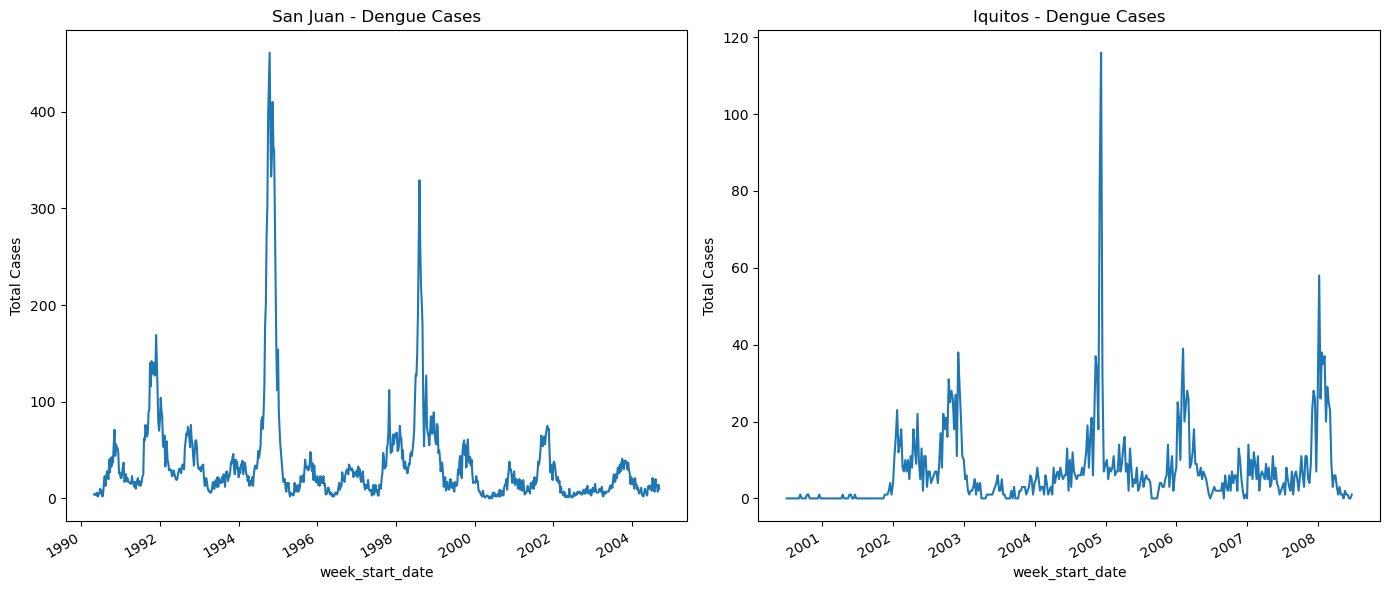

In [13]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sj_train_cases.plot(title='San Juan - Dengue Cases')
plt.ylabel('Total Cases')

plt.subplot(1, 2, 2)
iq_train_cases.plot(title='Iquitos - Dengue Cases')
plt.ylabel('Total Cases')

plt.tight_layout()
plt.show()

In [14]:
print("Missing values - San Juan:", sj_train_cases.isna().sum())
print("Missing values - Iquitos:", iq_train_cases.isna().sum())

Missing values - San Juan: 0
Missing values - Iquitos: 0


In [15]:
print("\nSan Juan Cases - Descriptive Statistics:")
print(sj_train_cases.describe())
print("\nIquitos Cases - Descriptive Statistics:")
print(iq_train_cases.describe())


San Juan Cases - Descriptive Statistics:
count    748.000000
mean      36.566845
std       55.059219
min        0.000000
25%       10.000000
50%       21.000000
75%       39.000000
max      461.000000
Name: total_cases, dtype: float64

Iquitos Cases - Descriptive Statistics:
count    416.000000
mean       7.076923
std       10.538688
min        0.000000
25%        1.000000
50%        4.000000
75%        8.000000
max      116.000000
Name: total_cases, dtype: float64


In [16]:
print("\nSan Juan date range:", sj_train.index.min(), "to", sj_train.index.max())
print("Iquitos date range:", iq_train.index.min(), "to", iq_train.index.max())


San Juan date range: 1990-04-30 00:00:00 to 2004-09-09 00:00:00
Iquitos date range: 2000-07-01 00:00:00 to 2008-06-24 00:00:00


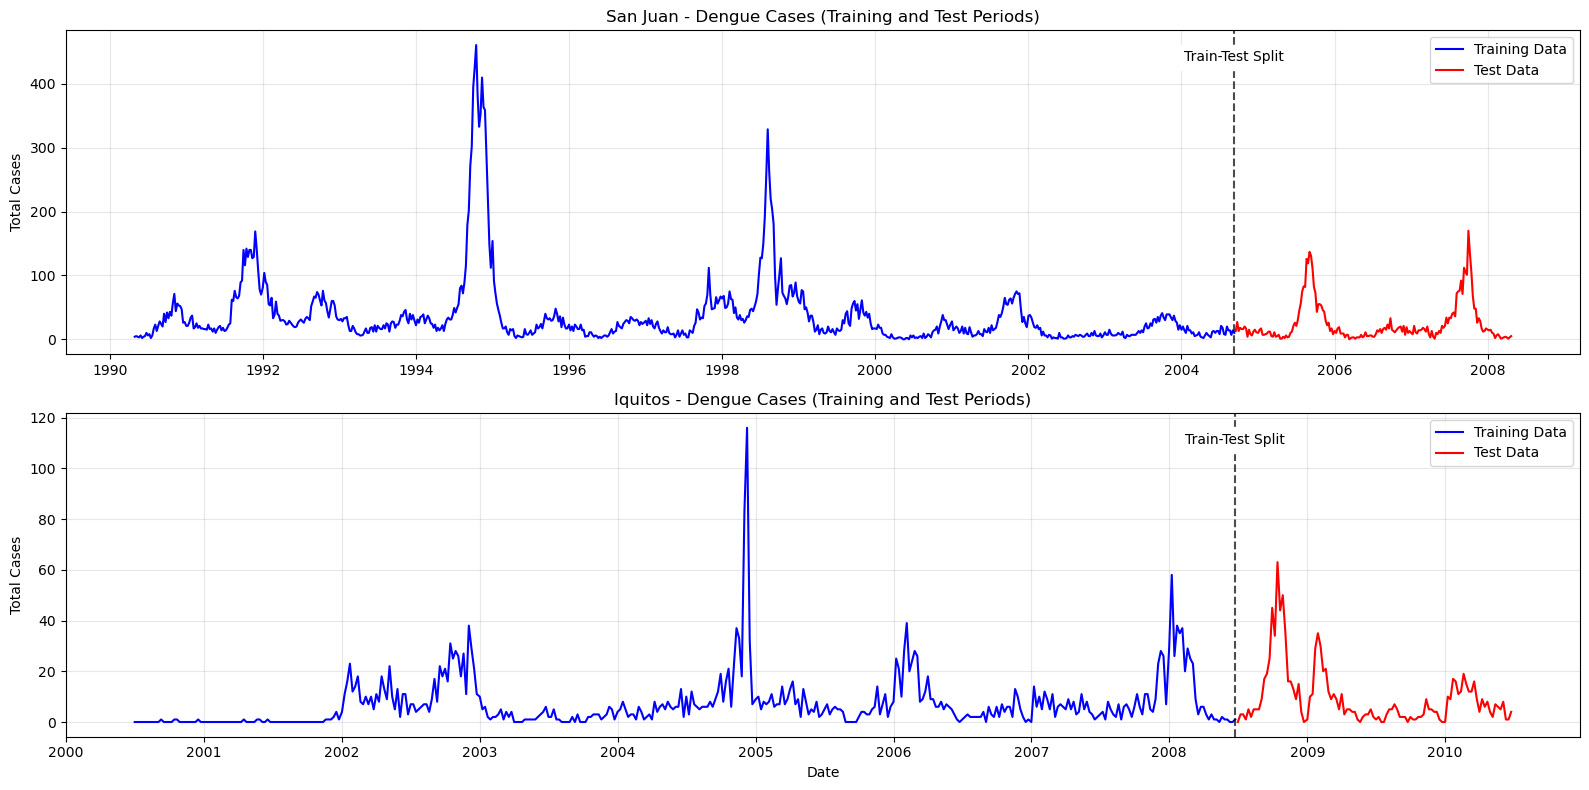

San Juan training period: 1990-04-30 00:00:00 to 2004-09-09 00:00:00
San Juan testing period: 2004-09-16 00:00:00 to 2008-04-22 00:00:00
Iquitos training period: 2000-07-01 00:00:00 to 2008-06-24 00:00:00
Iquitos testing period: 2008-07-01 00:00:00 to 2010-06-25 00:00:00


In [17]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(sj_train_cases.index, sj_train_cases.values, 'b-', label='Training Data')
plt.plot(sj_test.index, sj_test['total_cases'].values, 'r-', label='Test Data')
plt.title('San Juan - Dengue Cases (Training and Test Periods)')
plt.ylabel('Total Cases')
plt.axvline(x=sj_train.index.max(), color='k', linestyle='--', alpha=0.7)
plt.text(sj_train.index.max(), plt.ylim()[1]*0.9, 'Train-Test Split', 
         horizontalalignment='center', backgroundcolor='w')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(iq_train_cases.index, iq_train_cases.values, 'b-', label='Training Data')
plt.plot(iq_test.index, iq_test['total_cases'].values, 'r-', label='Test Data')
plt.title('Iquitos - Dengue Cases (Training and Test Periods)')
plt.ylabel('Total Cases')
plt.xlabel('Date')
plt.axvline(x=iq_train.index.max(), color='k', linestyle='--', alpha=0.7)
plt.text(iq_train.index.max(), plt.ylim()[1]*0.9, 'Train-Test Split', 
         horizontalalignment='center', backgroundcolor='w')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"San Juan training period: {sj_train.index.min()} to {sj_train.index.max()}")
print(f"San Juan testing period: {sj_test.index.min()} to {sj_test.index.max()}")
print(f"Iquitos training period: {iq_train.index.min()} to {iq_train.index.max()}")
print(f"Iquitos testing period: {iq_test.index.min()} to {iq_test.index.max()}")

# Stationary data check

In [24]:
window = 52
sj_rolling_mean = sj_train_cases.rolling(window=window).mean()
sj_rolling_std = sj_train_cases.rolling(window=window).std()

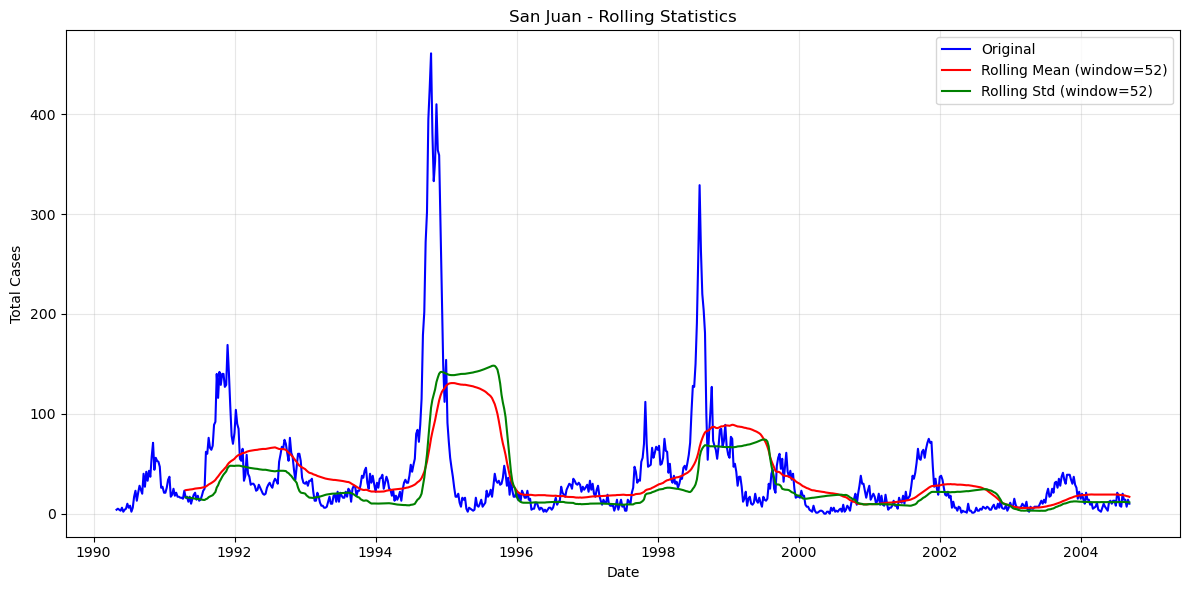

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(sj_train_cases, color='blue', label='Original')
plt.plot(sj_rolling_mean, color='red', label=f'Rolling Mean (window={window})')
plt.plot(sj_rolling_std, color='green', label=f'Rolling Std (window={window})')
plt.title('San Juan - Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
result_sj = adfuller(sj_train_cases.dropna())

print("Stationarity Test for San Juan")
print("ADF Statistic:", result_sj[0])
print("p-value:", result_sj[1])
print("Critical Values:")
for key, value in result_sj[4].items():
    print(f"   {key}: {value}")

if result_sj[1] <= 0.05:
    print("Result: Series is stationary (reject null hypothesis)")
else:
    print("Result: Series is non-stationary (fail to reject null hypothesis)")
print("-------------------------------------")

Stationarity Test for San Juan
ADF Statistic: -4.914390459100143
p-value: 3.269348022161475e-05
Critical Values:
   1%: -3.4392782790913206
   5%: -2.865480319267325
   10%: -2.568868260909806
Result: Series is stationary (reject null hypothesis)
-------------------------------------


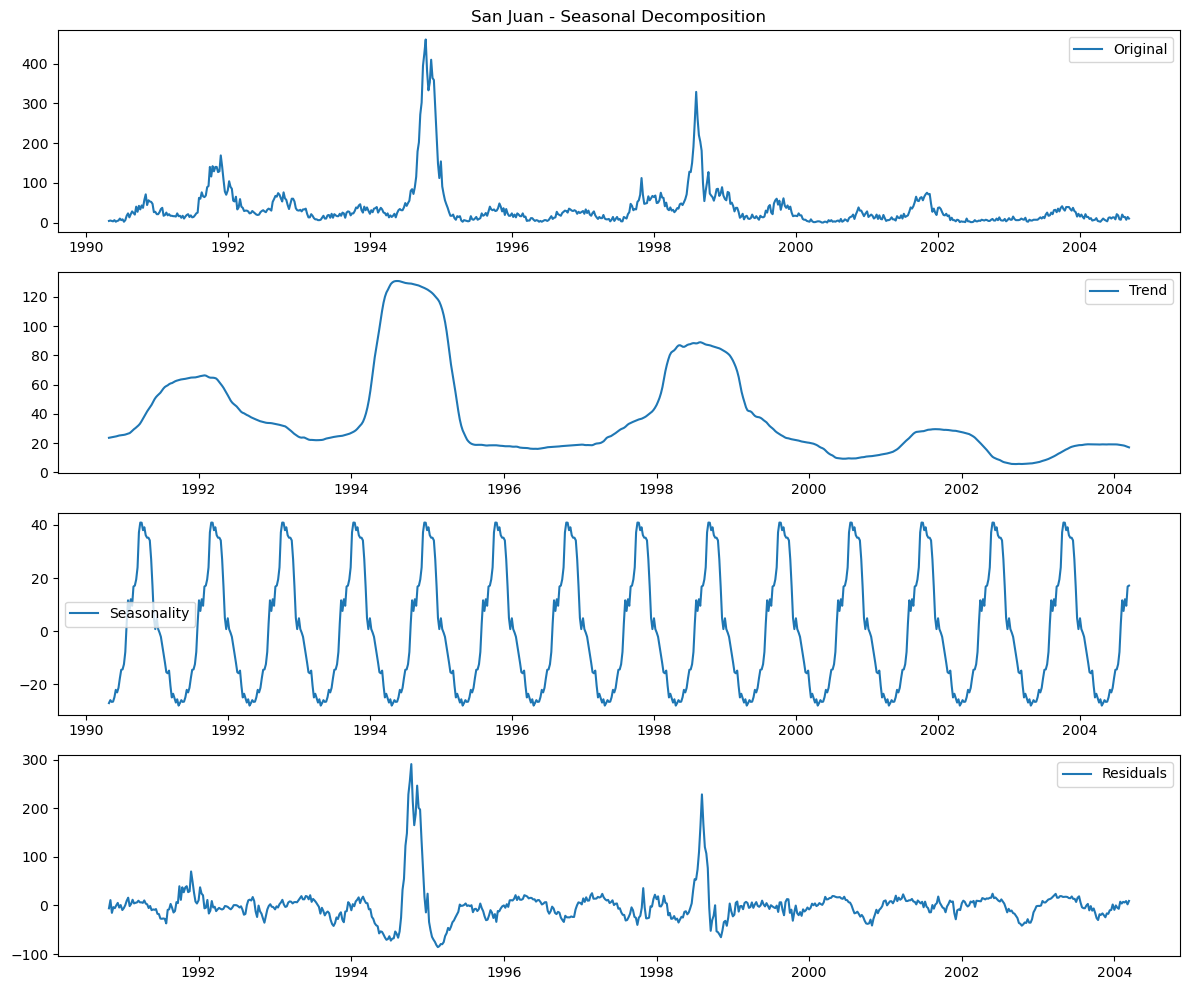

In [27]:
period = 52  # Weekly data, 52 weeks per year
decomposition_sj = seasonal_decompose(sj_train_cases, model='additive', period=period)
trend_sj = decomposition_sj.trend
seasonal_sj = decomposition_sj.seasonal
residual_sj = decomposition_sj.resid

plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(sj_train_cases, label='Original')
plt.title('San Juan - Seasonal Decomposition')
plt.legend()

plt.subplot(412)
plt.plot(trend_sj, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(seasonal_sj, label='Seasonality')
plt.legend()

plt.subplot(414)
plt.plot(residual_sj, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
window = 52
iq_rolling_mean = iq_train_cases.rolling(window=window).mean()
iq_rolling_std = iq_train_cases.rolling(window=window).std()

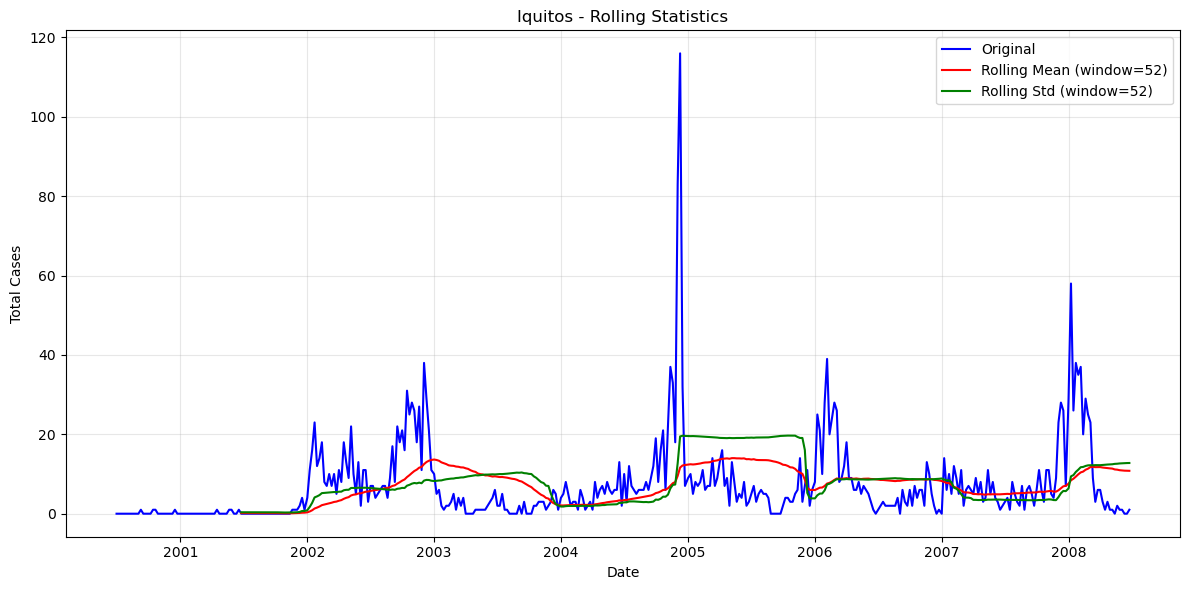

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(iq_train_cases, color='blue', label='Original')
plt.plot(iq_rolling_mean, color='red', label=f'Rolling Mean (window={window})')
plt.plot(iq_rolling_std, color='green', label=f'Rolling Std (window={window})')
plt.title('Iquitos - Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
result_iq = adfuller(iq_train_cases.dropna())

print("Stationarity Test for Iquitos")
print("ADF Statistic:", result_iq[0])
print("p-value:", result_iq[1])
print("Critical Values:")
for key, value in result_iq[4].items():
    print(f"   {key}: {value}")

if result_iq[1] <= 0.05:
    print("Result: Series is stationary (reject null hypothesis)")
else:
    print("Result: Series is non-stationary (fail to reject null hypothesis)")
print("-------------------------------------")

Stationarity Test for Iquitos
ADF Statistic: -5.059884794706824
p-value: 1.687049621527217e-05
Critical Values:
   1%: -3.4463612216221775
   5%: -2.8685980017932917
   10%: -2.5705296947685605
Result: Series is stationary (reject null hypothesis)
-------------------------------------


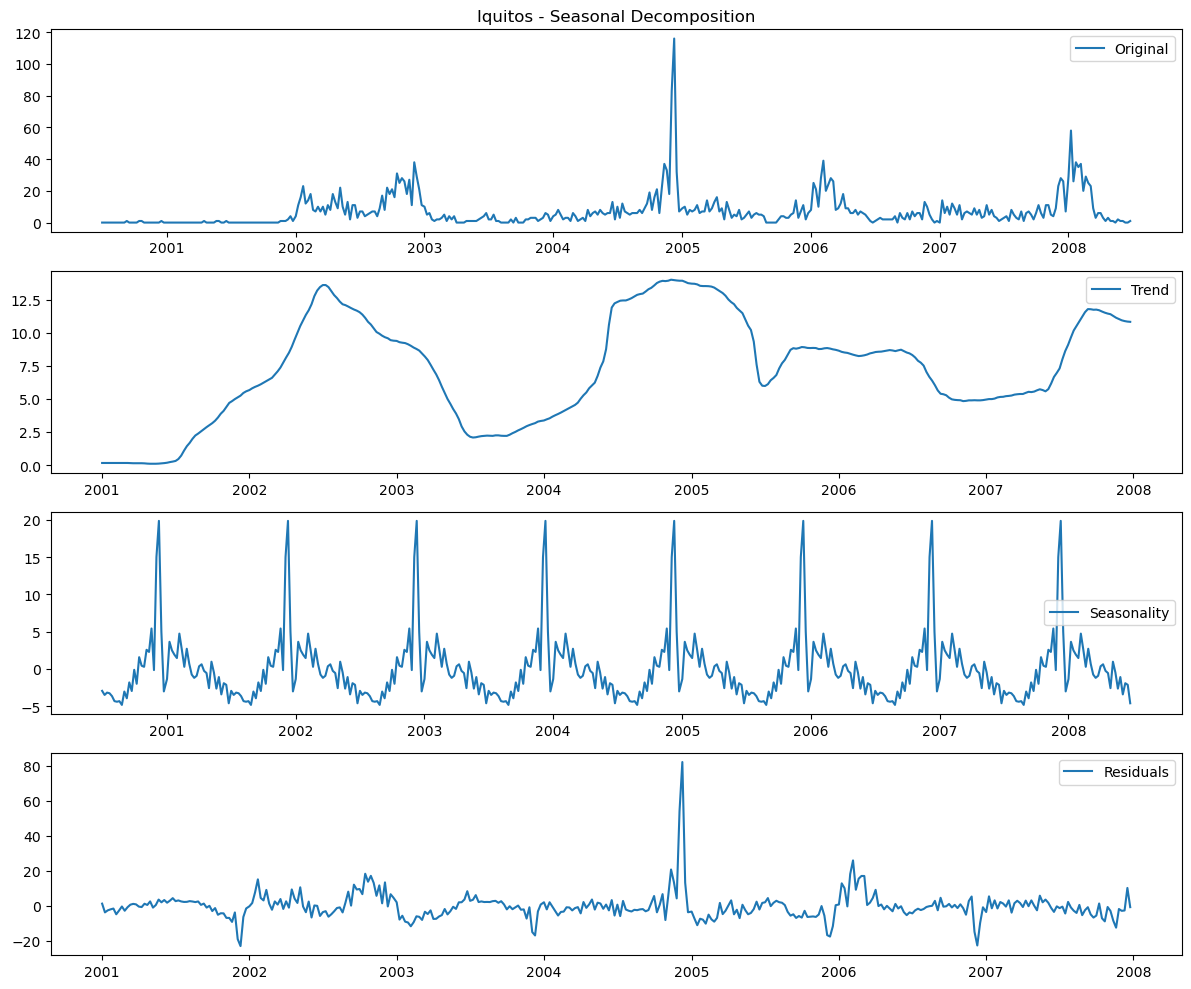

In [31]:
period = 52  # Weekly data, 52 weeks per year
decomposition_iq = seasonal_decompose(iq_train_cases, model='additive', period=period)
trend_iq = decomposition_iq.trend
seasonal_iq = decomposition_iq.seasonal
residual_iq = decomposition_iq.resid

plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(iq_train_cases, label='Original')
plt.title('Iquitos - Seasonal Decomposition')
plt.legend()

plt.subplot(412)
plt.plot(trend_iq, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(seasonal_iq, label='Seasonality')
plt.legend()

plt.subplot(414)
plt.plot(residual_iq, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Interpreting Stationary Test Results

# San Juan Analysis:
- Rolling Statistics:
    - Rolling mean isn't constant over time, it's showing clear shifts. This is most prevelant around major outbreak periods (1992, 1994-95, and 1998-99)
    - Rolling standard deviation (std) also varies, it also increases significantly during outbreaks
    - The variations in both the mean and std typically suggests non-stationarity 

- ADF Results:
    - ADF statistic is -4.9439
    - p-value is small enough to reject the null hypothesis (below 0.05)
    - So even though the visual evidence suggests non-stationarity, the statistical evidence suggests the series is stationary. And that's because the series returns to baseline after outbreaks (the mean is consistent, and the series returns to the mean)

- Seasonal Decomposition:
    - Trend component is showing non-stationarity with major peaks that correspond with the outbreak periods
    - Seasonal component is showing a very regular annual pattern with peaks that most likely correspond with rainy season
    - Residual component still has significant spikes during outbreak periods

# Iquitos Analysis:
- Rollings Statistics:
    - Similar to San Juan the rolling mean and std aren't constant
    - There are major shifts that occur arround 2002-03, 2005, and 2007-08
    - The rolling std does increase during outbreaks

- ADF Results:
    - ADF statistic is -5.0598
    - Similar to San Juan the p-value is small enough to reject the null hypothesis
    - Similar to San Juan in that the test is suggesting stationarity despite the visual evidence of non-stationarity, and again, it's because the series returns to baseline between outbreaks.

- Seasonal Decomposition:
    - Trend component shows clear shifts in the baseline level over time
    - Seasonal component shows annual patterns but with more complexity than San Juan
    - Residual component contains large spikes during major outbreak periods

# Approaching the ARIMA Model:

1. Differencing (d parameter) is worth considering:
    - Even though the ADF tests do suggest stationarity, the visual inspections suggests that differencing might be beneficial
    - I'm going to start with d=0 or d=1 for both San Juan and Iquitos

2. Season Differencing (D parameter) is necessary:
    - The strong seasonal patterns suggest that I should include seasonal differencing
    - I'm going to start with D=1 for the year to year seasonal patterns

3. Seasonal Period (s parameter) is necessary:
    - Both San Juan and Iquitos show clear annual cycles
    - I'm going to use s=52 weekly data

4.  AR and MA components (p, q, P, Q parameters) are necessary:
    - I need to examine ACF and PACF plots to determine these parameters
    - I'll need MA components to model the outbreaks periods/spikes

5. Different Models for each city:
    - While there are similarities between both cities, there are enough differences that warrant separate models for each city
    - SJ has more historical data, and the outbreaks here are more pronounced
    - Iquitos has fewer observations but shows clear seasonal patterns

# Next Steps!
1. Examine ACF and PACF plots to determine appropriate values for p, q, P, and Q.
2. Use SARIMA!

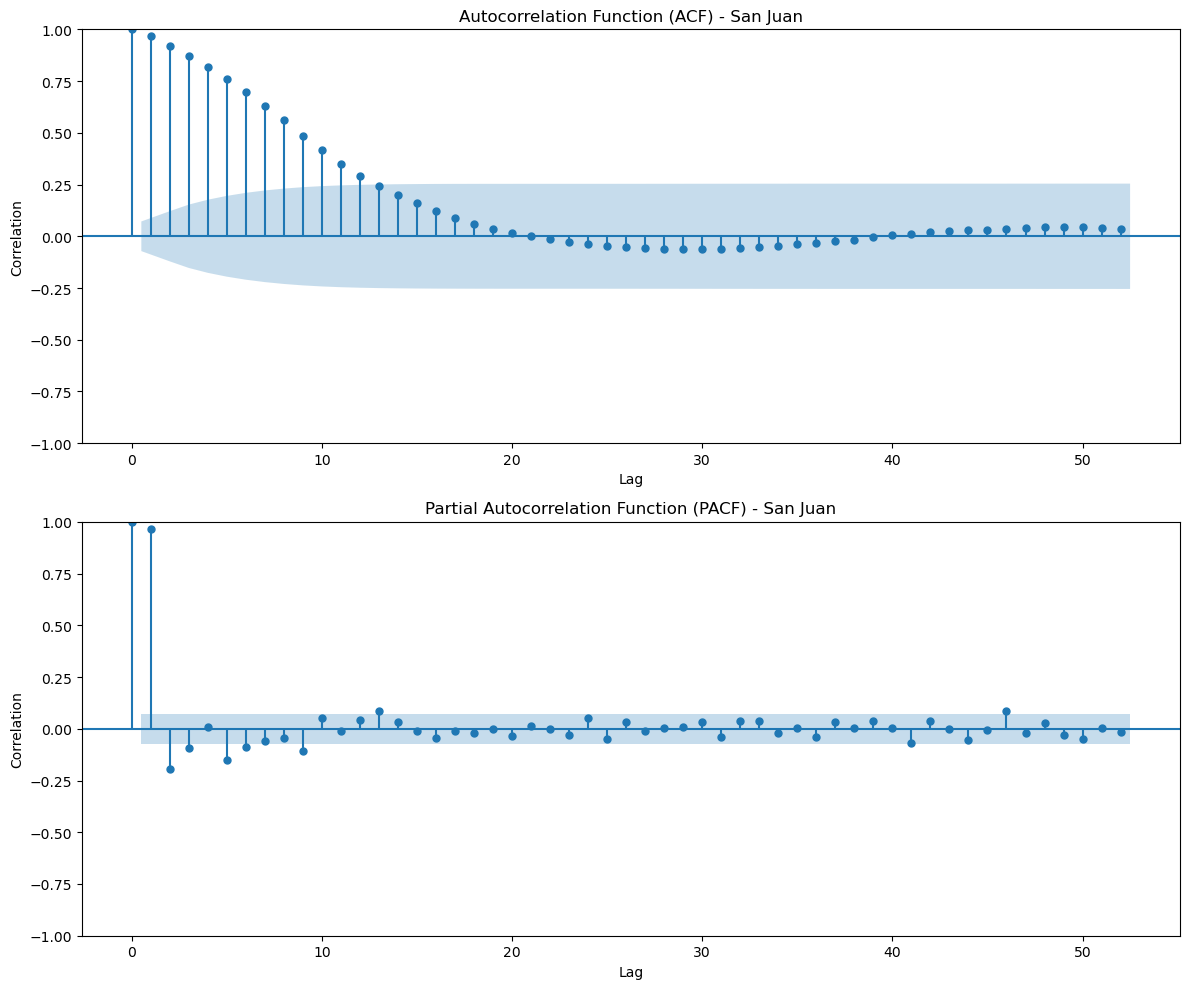

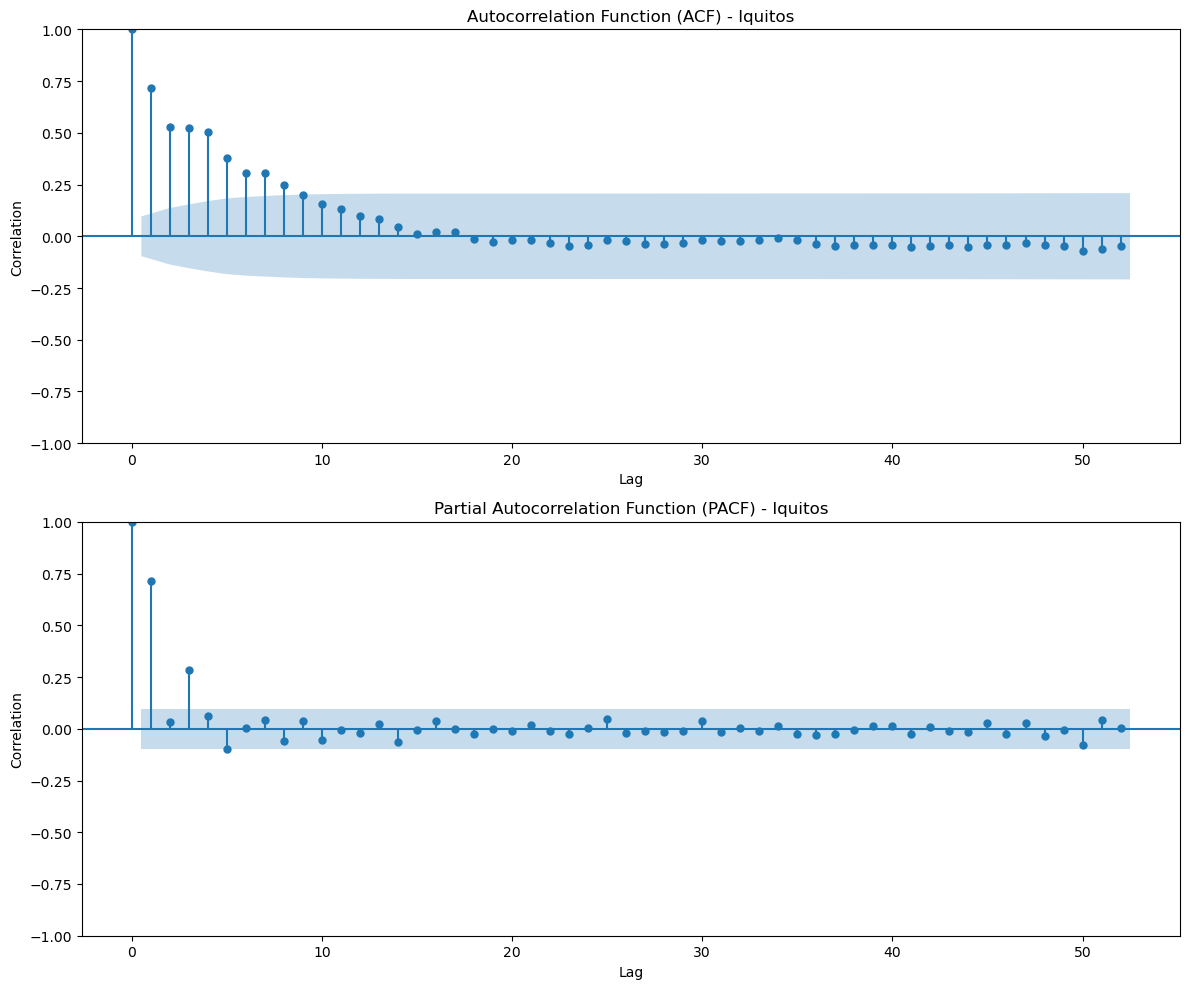

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(sj_train_cases, ax=ax1, lags=52)
ax1.set_title('Autocorrelation Function (ACF) - San Juan')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Correlation')

plot_pacf(sj_train_cases, ax=ax2, lags=52)
ax2.set_title('Partial Autocorrelation Function (PACF) - San Juan')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(iq_train_cases, ax=ax1, lags=52)
ax1.set_title('Autocorrelation Function (ACF) - Iquitos')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Correlation')

plot_pacf(iq_train_cases, ax=ax2, lags=52)
ax2.set_title('Partial Autocorrelation Function (PACF) - Iquitos')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation')

plt.tight_layout()
plt.show()

In [33]:
# First-order differenced series
sj_diff1 = sj_train_cases.diff().dropna()
iq_diff1 = iq_train_cases.diff().dropna()

# Seasonal differenced series (52-week difference)
sj_diff52 = sj_train_cases.diff(52).dropna()
iq_diff52 = iq_train_cases.diff(52).dropna()

# First-order + seasonal differenced series
sj_diff1_52 = sj_diff52.diff().dropna()
iq_diff1_52 = iq_diff52.diff().dropna()

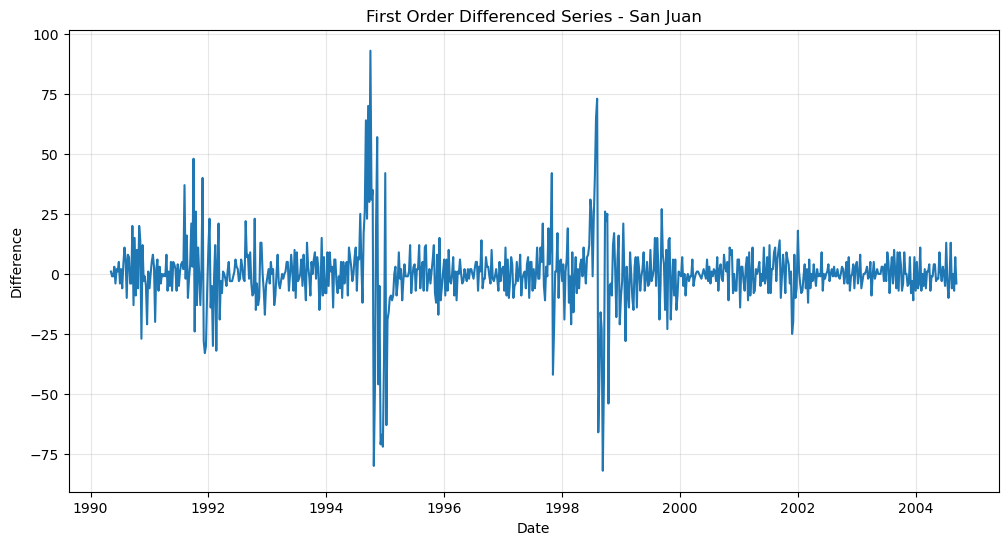

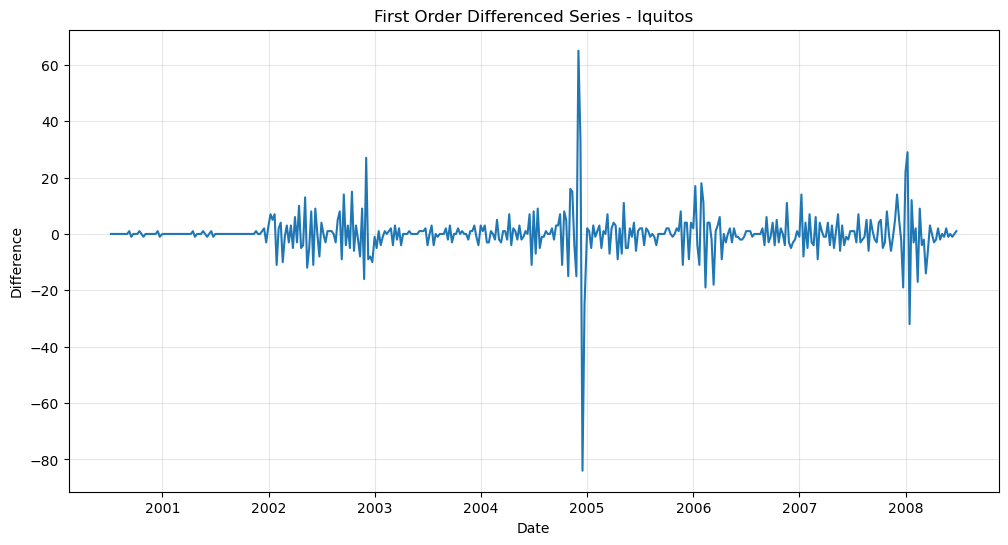

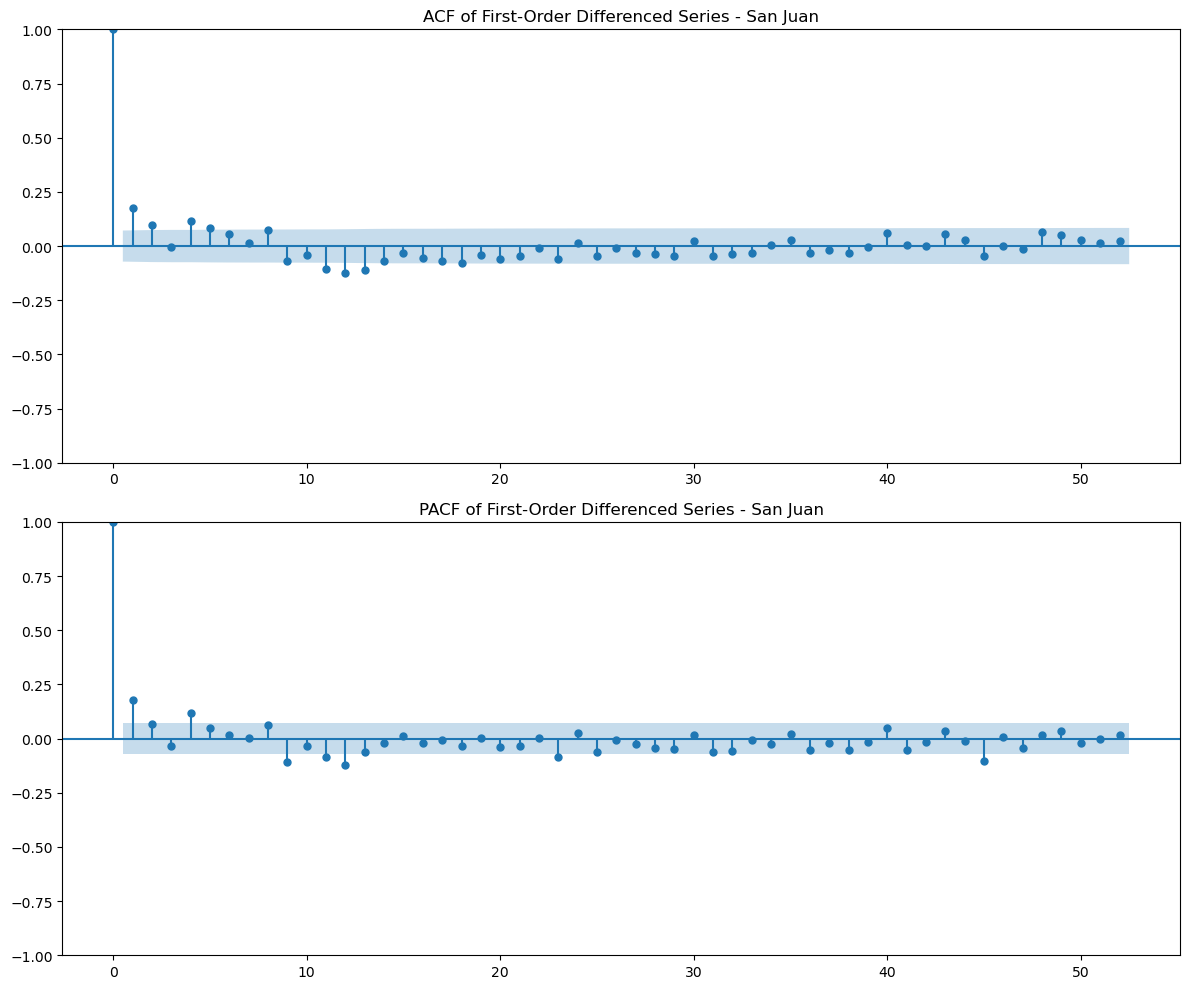

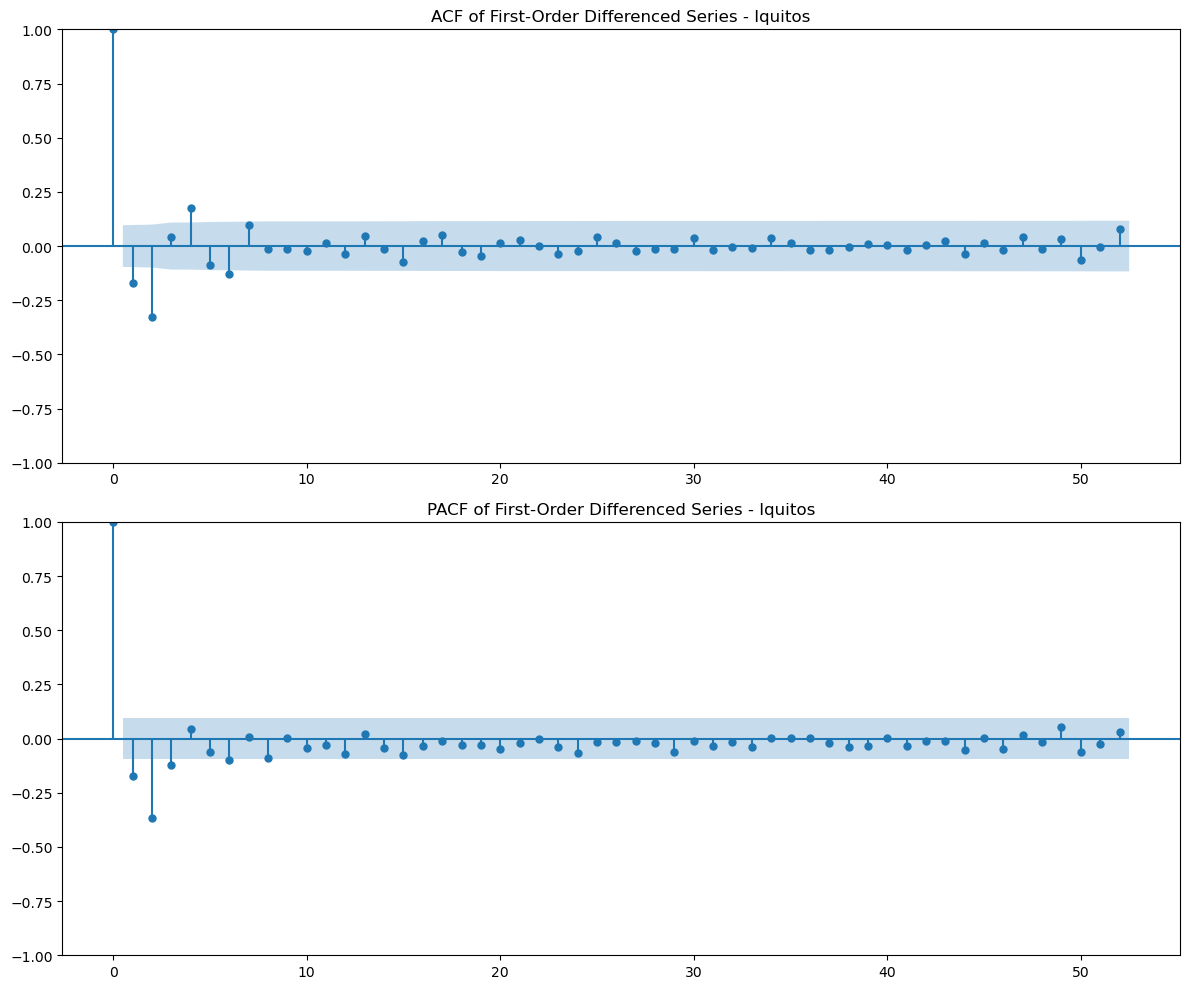

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(sj_diff1)
plt.title('First Order Differenced Series - San Juan')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(iq_diff1)
plt.title('First Order Differenced Series - Iquitos')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.grid(True, alpha=0.3)
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(sj_diff1, ax=ax1, lags=52)
ax1.set_title('ACF of First-Order Differenced Series - San Juan')
plot_pacf(sj_diff1, ax=ax2, lags=52)
ax2.set_title('PACF of First-Order Differenced Series - San Juan')
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(iq_diff1, ax=ax1, lags=52)
ax1.set_title('ACF of First-Order Differenced Series - Iquitos')
plot_pacf(iq_diff1, ax=ax2, lags=52)
ax2.set_title('PACF of First-Order Differenced Series - Iquitos')
plt.tight_layout()
plt.show()

# Interpreting ACF and PACF Plot Results:

# Original Series Plots:
- San Juan:
    - ACF is showing slow decay, the values remain signifcant for about 12-15 lags
    - PACF is showing a strong spike at lag 1 then cuts off sharply 
    - The pattern is typical of an AR(1) or AR(2) process
- Iquitos:
    - ACF is also showing slow decay but it's not pronounced as San Juan
    - PACF also has a strong spike at lag 1 and 2 then it cuts off
    - This pattern suggests an AR(2) process

# First-Differenced Series Plots:
- San Juan:
    - ACF is showing significant negative correlation at lag 1, then mostly insignificant
    - PACF is showing a significant spike at lag 1, then it's mostly insignificant
    - This pattern suggests an ARIMA(0,1,1) model
- Iquitos:
    - ACF is showing significant negative correlation at lag, and then some at lag 2
    - PACF is showing significant spikes at lags 1 and 2, and then it cuts off
    - This suggests an ARIMA(0,1,1) or ARIMA(0,1,2) model

# ARIMA Parameters Based on ACF and PACF Plot Results:

San Juan:

p = 1 or 2: The PACF of the original series cuts off after lag 1 or 2
d = 1: First differencing appears to make the series more stationary
q = 1: Based on the ACF of the differenced series
P = 0 or 1: We don't see strong seasonal patterns in the differenced series
D = 1: For seasonal differencing
Q = 1: For seasonal moving average component
s = 52: For weekly seasonality

Iquitos:

p = 2: The PACF of the original series shows significance at lag 2
d = 1: First differencing improves stationarity
q = 1 or 2: Based on the ACF of the differenced series
P = 0 or 1: Similar to San Juan
D = 1: For seasonal differencing
Q = 1: For seasonal moving average component
s = 52: For weekly seasonality

# Next Steps!:

Try a few different models for each city:
- San Juan: SARIMA(1,1,1)(0,1,1,52) and SARIMA(2,1,1)(1,1,1,52)
- Iquitos: SARIMA(2,1,1)(0,1,1,52) and SARIMA(2,1,2)(1,1,1,52)

Compare models using metrics like AIC/BIC and cross-validation performance. Select the best performing model for each city

# San Juan SARIMA Model

In [35]:
p, d,q = 1, 1, 1
P, D, Q, s = 0, 1, 1, 52

sj_model = SARIMAX(
    sj_train_cases,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [36]:
try:
    sj_results = sj_model.fit(disp=False)
    print("San Juan SARIMA Model Summary:")
    print(sj_results.summary().tables[0])
    print(sj_results.summary().tables[1])
except Exception as e:
    print(f"Error fitting San Juan model: {e}")
    
print(f"AIC: {sj_results.aic:.2f}")

San Juan SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                        total_cases   No. Observations:                  748
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -2649.487
Date:                            Tue, 08 Apr 2025   AIC                           5306.975
Time:                                    16:40:18   BIC                           5324.827
Sample:                                         0   HQIC                          5313.903
                                            - 748                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4792      0.073      6.535      0.000       0.336       0.623
ma.L

# Second SJ SARIMA Model

In [37]:
p, d, q = 2, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 52  # Seasonal parameters

sj_model2 = SARIMAX(
    sj_train_cases,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [48]:
try:
    sj_results2 = sj_model2.fit(disp=False)
    print("\nSan Juan Alternative SARIMA Model Summary:")
    print(sj_results2.summary().tables[0])
    print(sj_results2.summary().tables[1])
except Exception as e:
    print(f"Error fitting alternative San Juan model: {e}")
    
print(f"AIC: {sj_results2.aic:.2f}")


San Juan Alternative SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                        total_cases   No. Observations:                  748
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -2647.480
Date:                            Tue, 08 Apr 2025   AIC                           5306.961
Time:                                    17:12:31   BIC                           5333.739
Sample:                                         0   HQIC                          5317.354
                                            - 748                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6133      0.101     -6.070      0.000      -0.811    

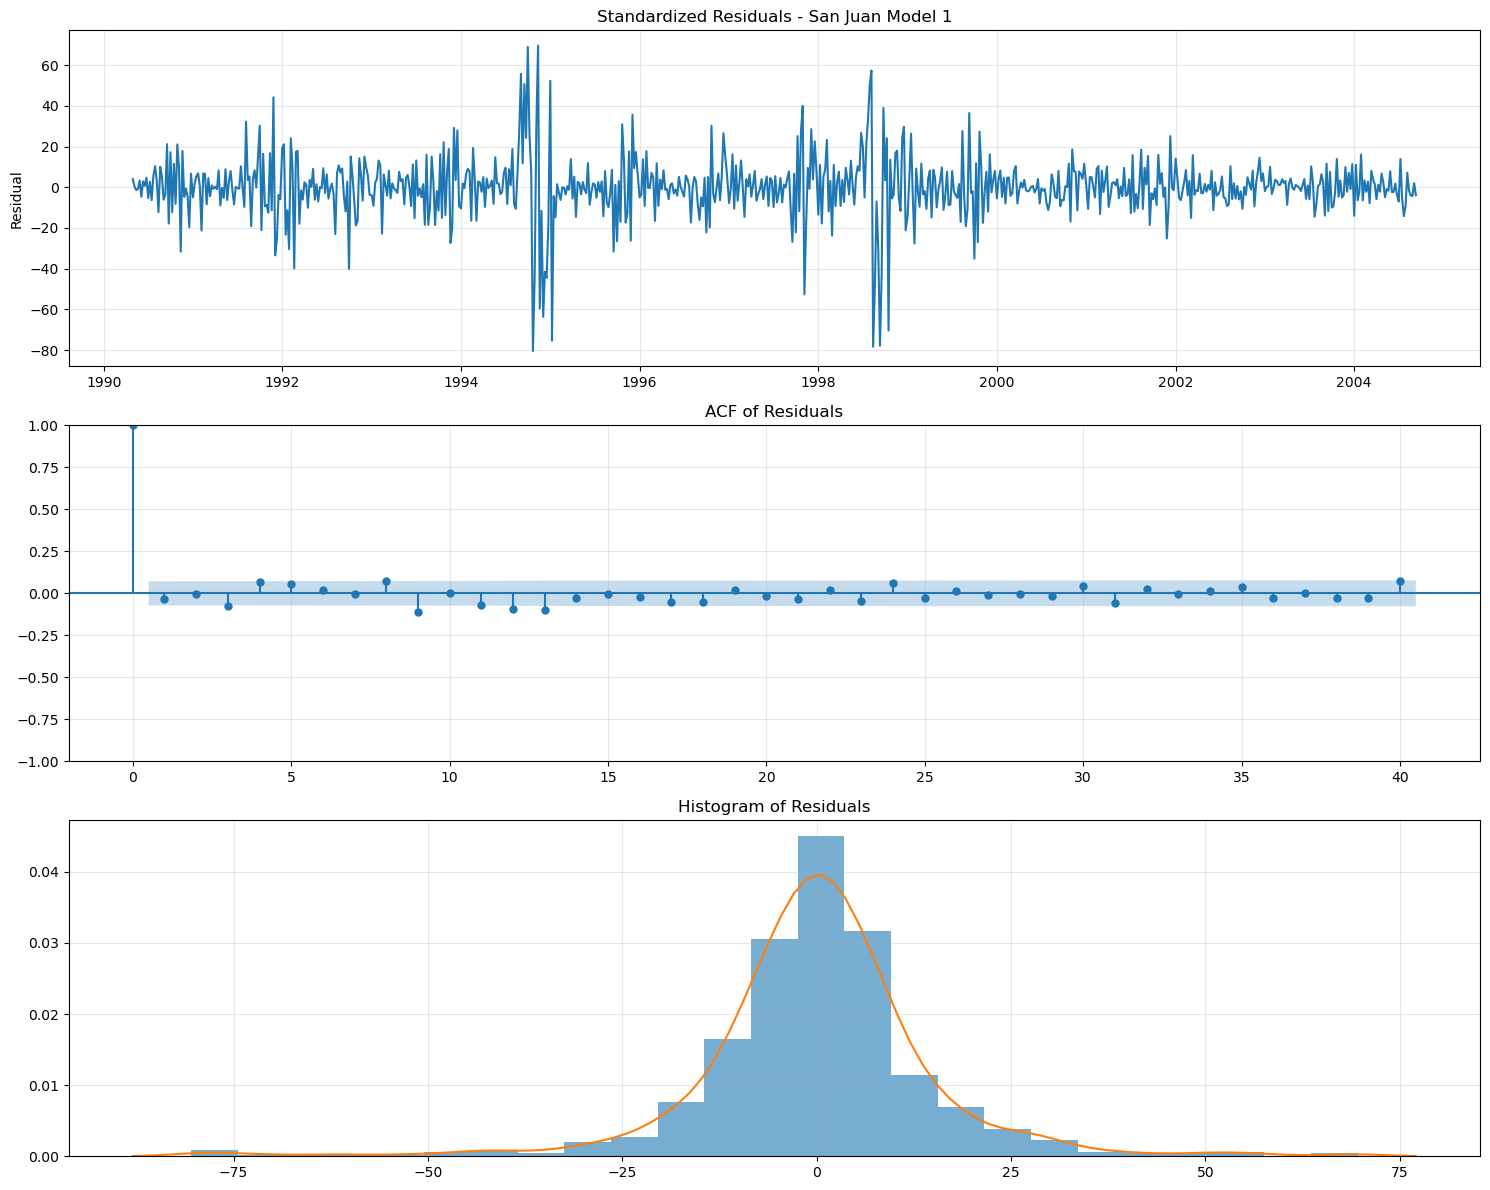

In [39]:
# Plot residual diagnostics for the first model
plt.figure(figsize=(15, 12))

# Standardized residual plot
plt.subplot(311)
plt.plot(sj_results.resid)
plt.title('Standardized Residuals - San Juan Model 1')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

# ACF of residuals
plt.subplot(312)
plot_acf(sj_results.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

# Histogram plus KDE
plt.subplot(313)
plt.hist(sj_results.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

# Add a kernel density estimate
from scipy import stats
kde = stats.gaussian_kde(sj_results.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [40]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(sj_results.resid, lags=[10, 20, 30])
print("Ljung-Box Test for San Juan Model 1:")
print(lb_test)

Ljung-Box Test for San Juan Model 1:
      lb_stat  lb_pvalue
10  24.036784   0.007503
20  47.016488   0.000584
30  55.316360   0.003268


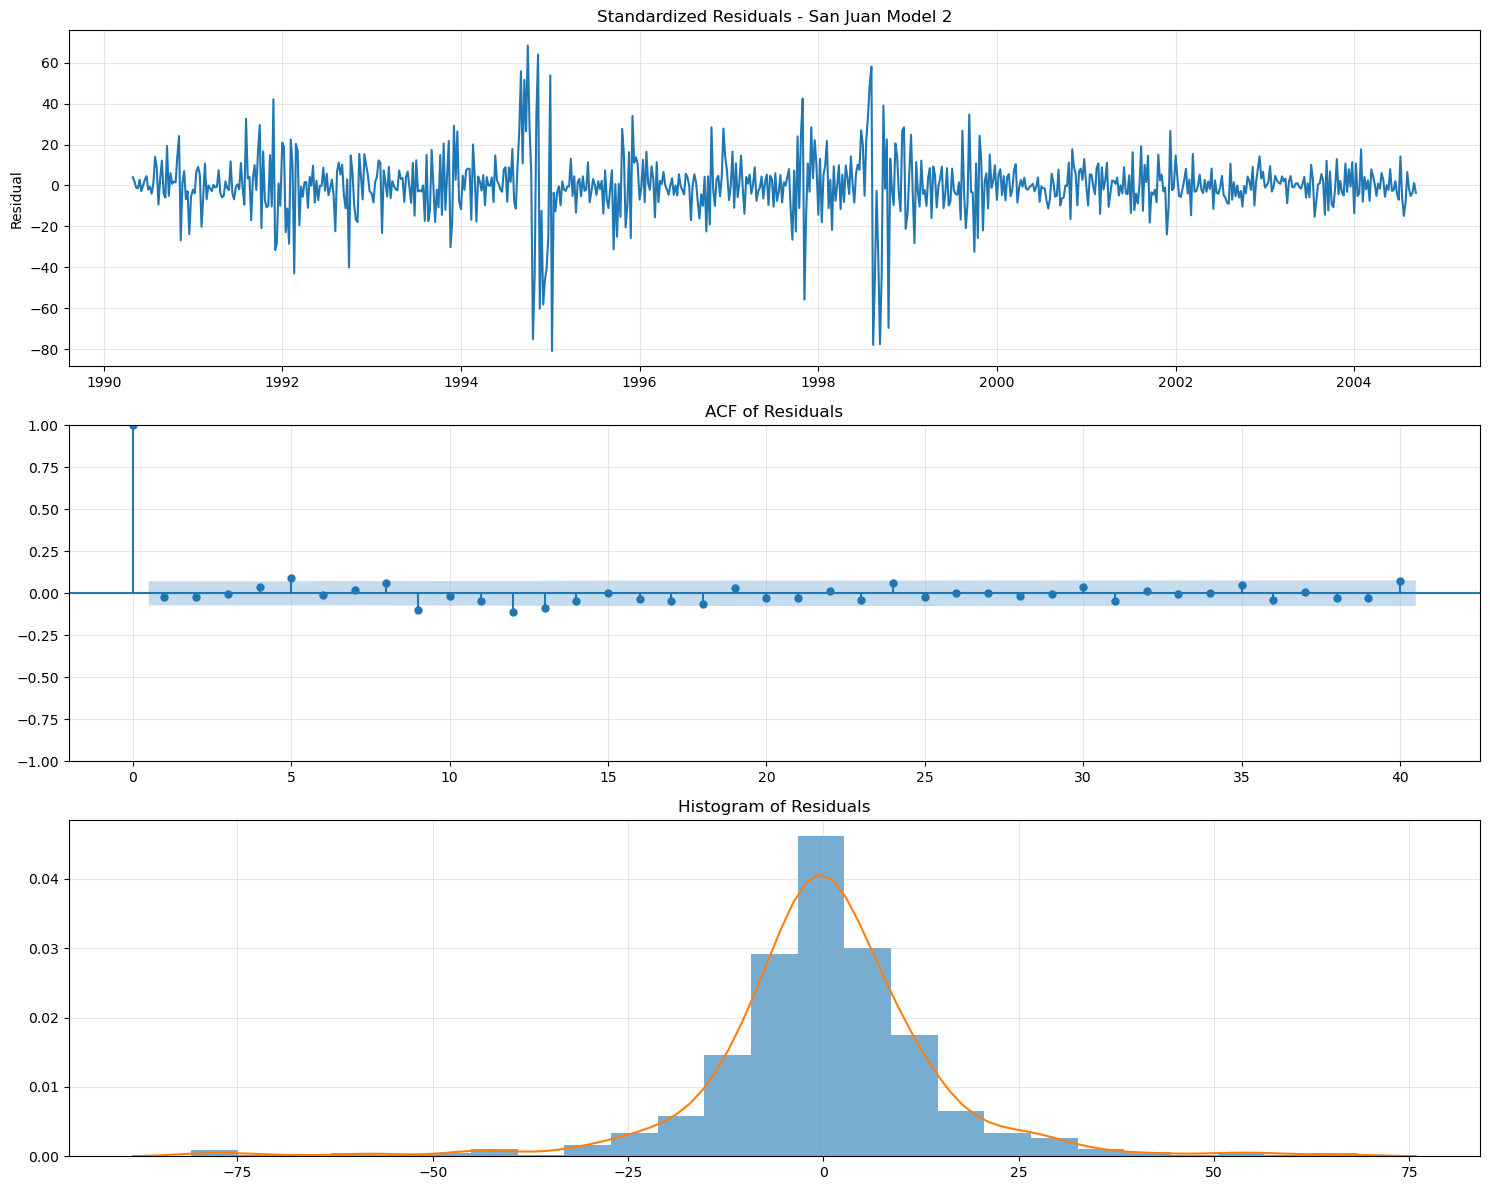

In [42]:
# Plot residual diagnostics for the second model
plt.figure(figsize=(15, 12))

# Standardized residual plot
plt.subplot(311)
plt.plot(sj_results2.resid)
plt.title('Standardized Residuals - San Juan Model 2')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

# ACF of residuals
plt.subplot(312)
plot_acf(sj_results2.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

# Histogram plus KDE
plt.subplot(313)
plt.hist(sj_results2.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

# Add a kernel density estimate
kde = stats.gaussian_kde(sj_results2.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [43]:
lb_test2 = acorr_ljungbox(sj_results2.resid, lags=[10, 20, 30])
print("Ljung-Box Test for San Juan Model 2:")
print(lb_test2)

Ljung-Box Test for San Juan Model 2:
      lb_stat  lb_pvalue
10  19.268617   0.036981
20  44.574785   0.001260
30  51.092748   0.009523


# Making Predictions on Test Set for SJ

In [44]:
forecast_steps = len(sj_test)
sj_forecast = sj_results.get_forecast(steps=forecast_steps)

# Extract predicted mean and confidence intervals
sj_pred_mean = sj_forecast.predicted_mean
sj_pred_ci = sj_forecast.conf_int()

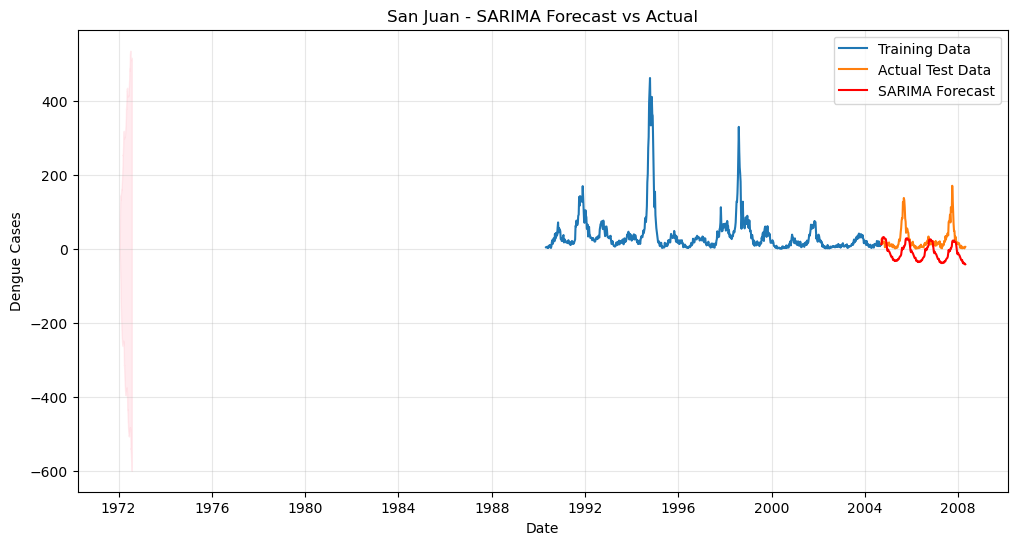

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(sj_train_cases.index, sj_train_cases, label='Training Data')
plt.plot(sj_test.index, sj_test['total_cases'], label='Actual Test Data')
plt.plot(sj_test.index, sj_pred_mean, label='SARIMA Forecast', color='red')
plt.fill_between(
    sj_pred_ci.index,
    sj_pred_ci.iloc[:, 0],
    sj_pred_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('San Juan - SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
sj_mae = mean_absolute_error(sj_test['total_cases'], sj_pred_mean)
sj_rmse = np.sqrt(mean_squared_error(sj_test['total_cases'], sj_pred_mean))

print(f"San Juan Model 1 - MAE: {sj_mae:.2f}")
print(f"San Juan Model 1 - RMSE: {sj_rmse:.2f}")

San Juan Model 1 - MAE: 37.19
San Juan Model 1 - RMSE: 45.80


# Making sense of the SARIMA SJ Models:

# Model 1: SARIMA(1,1,1)(0,1,1,52):
- AIC: 5306.97 - This is a measure of model fit (lower is better)
- All coefficients are statistically significant (p-values < 0.05):
- AR(1) term: 0.4792 (positive autoregressive relationship)
- MA(1) term: -0.3204 (negative moving average effect)
- Seasonal MA term: -1.0522 (strong seasonal moving average component)

# Model 2: SARIMA(2,1,1)(1,1,1,52):
- AIC: 5306.96 - Slightly lower (better) than Model 1, but the difference is minimal

# Residual Diagnostics:
- Standardized Results:
    - Both models show similar residual patterns
    - Large spikes in residuals during outbreak periods like 1995 and 1998
    - The model is struggling to capture extreme outbreak events

- ACF of Residuals:
    - Most of the lags fall within the significance bounds (the blue shaded areas)
    - This is suggesting the models have captured most of the autocorrelation structure
    - There aren't any remaining obvious seasonal patterns in the residuals

- Histogram of Residuals:
    - Generally normal with a slight skew
    - Some heavy tails due to the outbreak periods
    - Acceptable for time series forecasting

# Ljung-Box Test: this test checks if the residuals are independently distributed 
- Model 1:
    - p-values - 0.00753, 0.0058, 0.00327 for lags 10, 20, 30
    - All the p-values are <0.05, this indicates autocorrelation remains in the residuals

- Model 2:
    - p-values - 0.03698, 0.00126, 0.00952 for lags 10, 20, 30
    - All the p-values are <0.05 BUT they're slightly higher than Model 1. This means that model 2 does a better job at capturing dependencies

# Forecast Performance:
- MAE 37.19 and RMSE 45.80 (NO BUENO!)
- Forecast does seem to capture the seasonality pattern but misses the magnitude of outbreak peaks
- Confidence interval is wide at the beginning
- The model does predict the timing of seasonal increases fairly well

# Overall Assessment:
- Both models are similar in terms of statistical fit
- Model 2 has a better fit according to the AIC and Ljung-Box tests
- Both models capture seasonal patterns but struggle with outbreak magnitudes
- MAE of 37.19 is WAAAAAAY higher than the XGBoost model's MAE of 7.21 (SJ MAE)
- SARIMA captures seasonality but it's not as effective/good at predicting the actual case counts like the XGBoost model


# Next Steps:
1. Implementing SARIMAX to capture other features likes humidity, precipitation, temperature, and vegitation (NVDI)
2. Log transforming to stabilize variance by reducing the impact of the extreme values. Hopefully it makes outbreak peaks less extreme and easier to model
3. Implementing different seasonal periods. (eg. s=13 for quarterly, s=26 6months)

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 0, 1, 1, 52  # Seasonal parameters

exog_vars = [
    'total_cases_lag1', 
    'total_cases_lag2',
    'reanalysis_specific_humidity_g_per_kg_roll_8_std',
    'reanalysis_relative_humidity_percent_roll_4_mean',
    'ndvi_ne_roll_2_mean',
    'reanalysis_tdtr_k_roll_8_mean'
]

In [51]:
X_train = sj_train[exog_vars].copy()
X_test = sj_test[exog_vars].copy()

In [52]:
sj_sarimax = SARIMAX(
    sj_train_cases,
    exog=X_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [53]:
try:
    sj_sarimax_results = sj_sarimax.fit(disp=False)
    print("San Juan SARIMAX Model Summary:")
    print(sj_sarimax_results.summary().tables[0])
    print(sj_sarimax_results.summary().tables[1])
except Exception as e:
    print(f"Error fitting San Juan SARIMAX model: {e}")
    
print(f"AIC: {sj_sarimax_results.aic:.2f}")

San Juan SARIMAX Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                        total_cases   No. Observations:                  748
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -2647.090
Date:                            Tue, 08 Apr 2025   AIC                           5314.179
Time:                                    21:50:30   BIC                           5358.810
Sample:                                         0   HQIC                          5331.501
                                            - 748                                         
Covariance Type:                              opg                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
total_

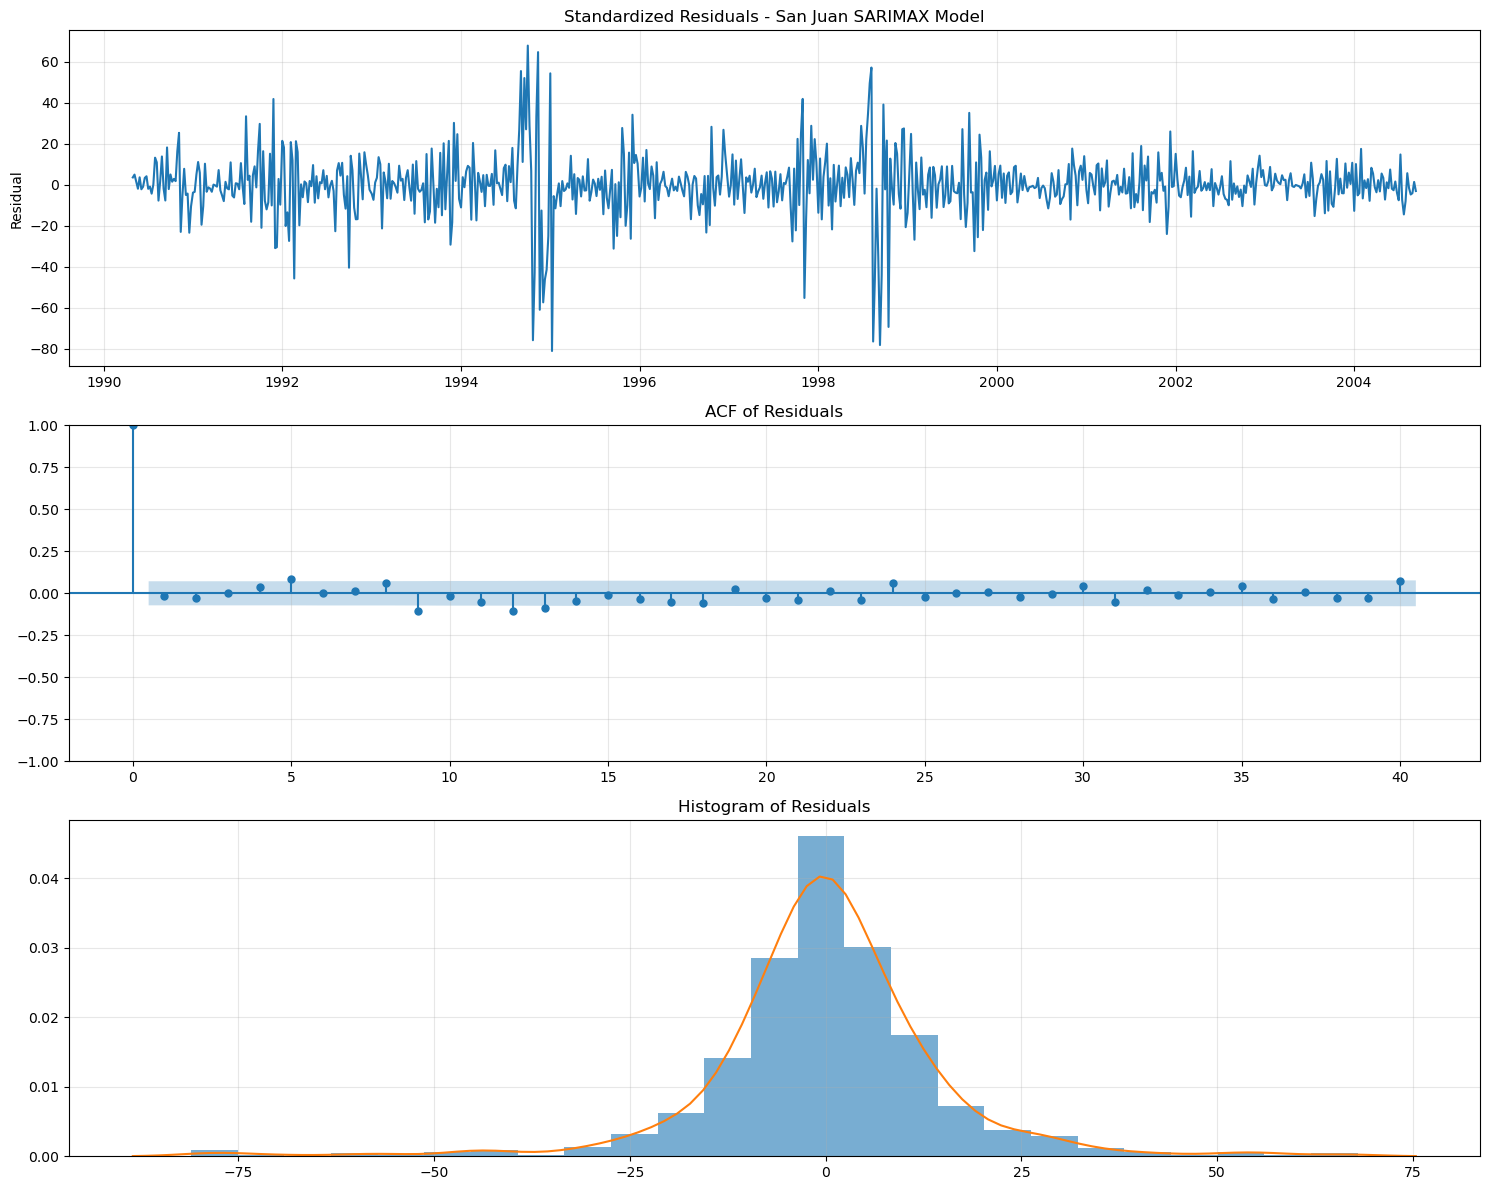

In [54]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(sj_sarimax_results.resid)
plt.title('Standardized Residuals - San Juan SARIMAX Model')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.subplot(312)
plot_acf(sj_sarimax_results.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(313)
plt.hist(sj_sarimax_results.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

kde = stats.gaussian_kde(sj_sarimax_results.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [55]:
lb_test = acorr_ljungbox(sj_sarimax_results.resid, lags=[10, 20, 30])
print("Ljung-Box Test for San Juan SARIMAX Model:")
print(lb_test)

Ljung-Box Test for San Juan SARIMAX Model:
      lb_stat  lb_pvalue
10  19.348506   0.036053
20  43.013513   0.002036
30  50.953024   0.009853


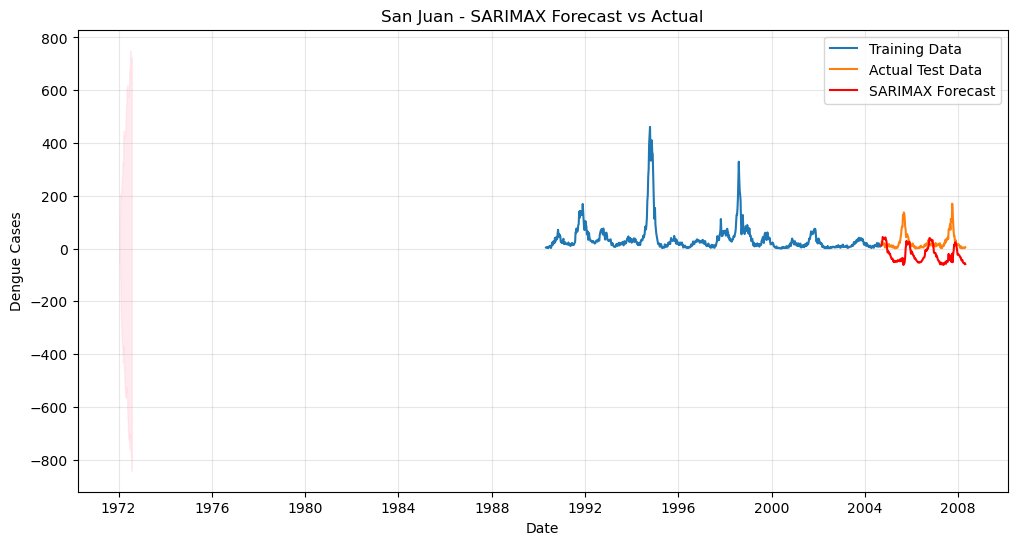

In [56]:
forecast_steps = len(sj_test)
sj_forecast = sj_sarimax_results.get_forecast(steps=forecast_steps, exog=X_test)

sj_pred_mean = sj_forecast.predicted_mean
sj_pred_ci = sj_forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(sj_train_cases.index, sj_train_cases, label='Training Data')
plt.plot(sj_test.index, sj_test['total_cases'], label='Actual Test Data')
plt.plot(sj_test.index, sj_pred_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(
    sj_pred_ci.index,
    sj_pred_ci.iloc[:, 0],
    sj_pred_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('San Juan - SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [57]:
sj_mae = mean_absolute_error(sj_test['total_cases'], sj_pred_mean)
sj_rmse = np.sqrt(mean_squared_error(sj_test['total_cases'], sj_pred_mean))

print(f"San Juan SARIMAX Model - MAE: {sj_mae:.2f}")
print(f"San Juan SARIMAX Model - RMSE: {sj_rmse:.2f}")

San Juan SARIMAX Model - MAE: 52.77
San Juan SARIMAX Model - RMSE: 65.28


# Log Transformation on SARIMA Model

In [58]:
sj_train_cases_log = np.log1p(sj_train_cases)
sj_test_cases_log = np.log1p(sj_test['total_cases'])

In [59]:
p, d, q = 1, 1, 1
P, D, Q, s = 0, 1, 1, 52

sj_sarima_log = SARIMAX(
    sj_train_cases_log,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [60]:
try:
    sj_sarima_log_results = sj_sarima_log.fit(disp=False)
    print("San Juan SARIMA Model (Log-transformed) Summary:")
    print(sj_sarima_log_results.summary().tables[0])
    print(sj_sarima_log_results.summary().tables[1])
except Exception as e:
    print(f"Error fitting San Juan SARIMA log model: {e}")
    
print(f"AIC: {sj_sarima_log_results.aic:.2f}")

San Juan SARIMA Model (Log-transformed) Summary:
                                     SARIMAX Results                                      
Dep. Variable:                        total_cases   No. Observations:                  748
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -288.458
Date:                            Tue, 08 Apr 2025   AIC                            584.915
Time:                                    21:57:34   BIC                            602.767
Sample:                                         0   HQIC                           591.844
                                            - 748                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1220      0.073      1.664      0.096      -0.02

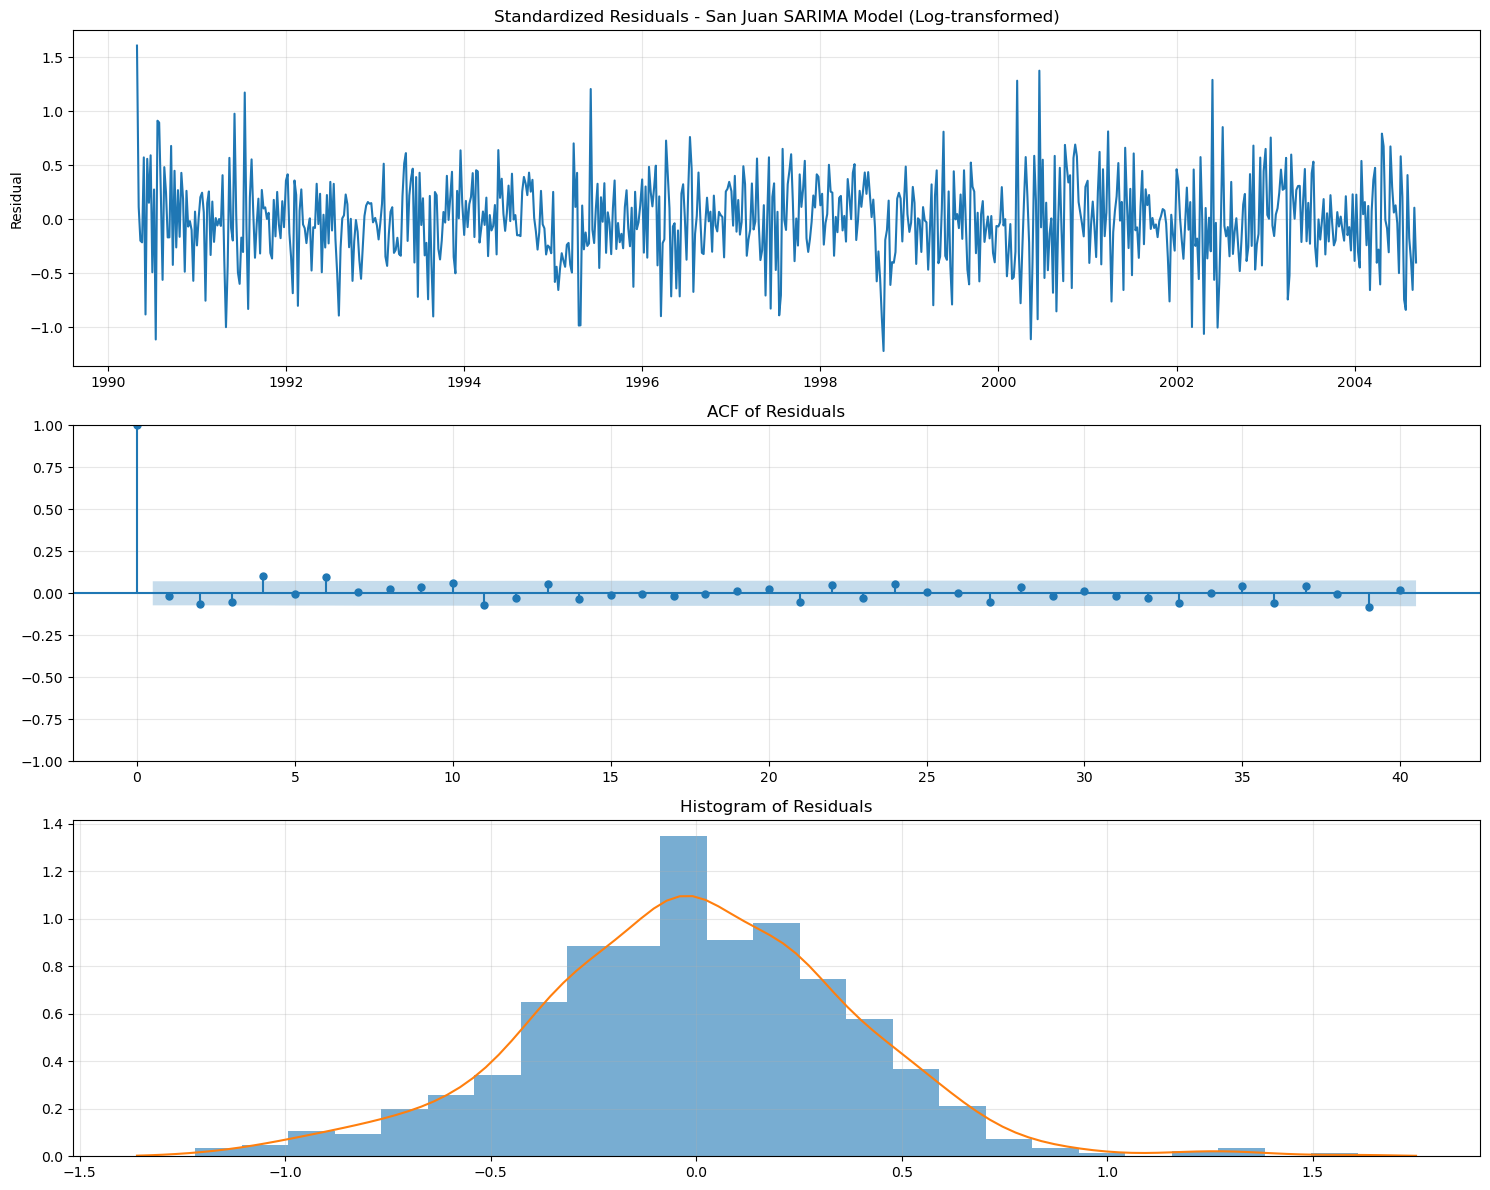

In [61]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(sj_sarima_log_results.resid)
plt.title('Standardized Residuals - San Juan SARIMA Model (Log-transformed)')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.subplot(312)
plot_acf(sj_sarima_log_results.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(313)
plt.hist(sj_sarima_log_results.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

kde = stats.gaussian_kde(sj_sarima_log_results.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [62]:
lb_test = acorr_ljungbox(sj_sarima_log_results.resid, lags=[10, 20, 30])
print("Ljung-Box Test for San Juan SARIMA Log Model:")
print(lb_test)

Ljung-Box Test for San Juan SARIMA Log Model:
      lb_stat  lb_pvalue
10  25.020269   0.005307
20  33.396135   0.030512
30  44.119169   0.046520


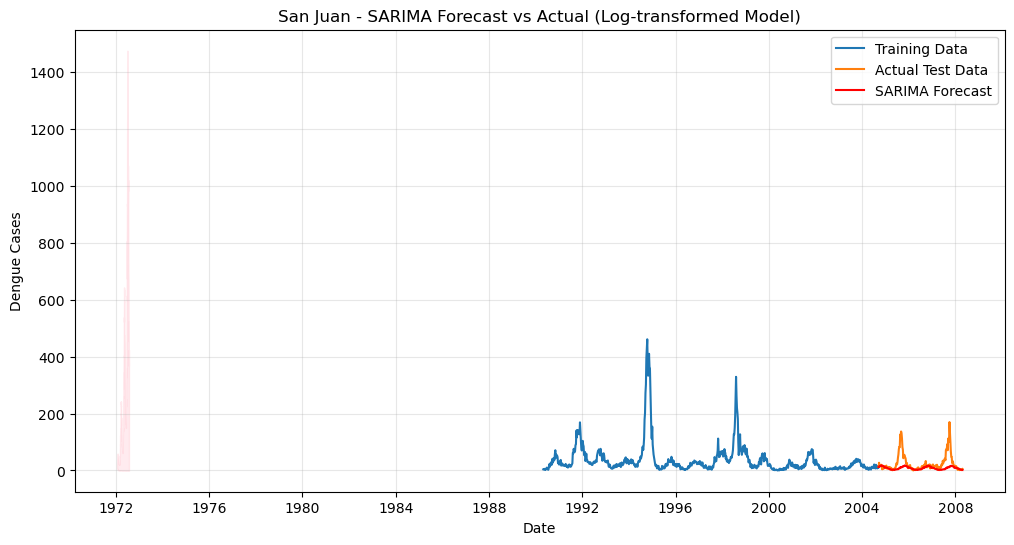

In [63]:
forecast_steps = len(sj_test)
sj_forecast_log = sj_sarima_log_results.get_forecast(steps=forecast_steps)

sj_pred_mean_log = sj_forecast_log.predicted_mean
sj_pred_ci_log = sj_forecast_log.conf_int()

sj_pred_mean = np.expm1(sj_pred_mean_log)
sj_pred_ci = np.expm1(sj_pred_ci_log)

plt.figure(figsize=(12, 6))
plt.plot(sj_train_cases.index, sj_train_cases, label='Training Data')
plt.plot(sj_test.index, sj_test['total_cases'], label='Actual Test Data')
plt.plot(sj_test.index, sj_pred_mean, label='SARIMA Forecast', color='red')
plt.fill_between(
    sj_pred_ci.index,
    sj_pred_ci.iloc[:, 0],
    sj_pred_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('San Juan - SARIMA Forecast vs Actual (Log-transformed Model)')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [65]:
sj_mae = mean_absolute_error(sj_test['total_cases'], sj_pred_mean)
sj_mae_log = mean_absolute_error(sj_test_cases_log, sj_pred_mean_log)

print(f"San Juan SARIMA Log Model - MAE: {sj_mae:.2f}")
print(f"San Juan SARIMA Log Model - MAE in log space: {sj_mae_log:.4f}")

San Juan SARIMA Log Model - MAE: 17.38
San Juan SARIMA Log Model - MAE in log space: 0.7811


# Adding a few seasonal patterns to see if I can capitalize on the latest improvement. 17.38 MAE!

In [66]:
sj_train_cases_log = np.log1p(sj_train_cases)
sj_test_cases_log = np.log1p(sj_test['total_cases'])

In [67]:
seasonal_periods = [26, 13, 4]

In [68]:
results_dict = {}

In [69]:
p, d, q = 1, 1, 1
P, D, Q = 0, 1, 1

s = 52  # Annual cycle
results_dict[f'SARIMA_{p}{d}{q}x{P}{D}{Q}_{s}'] = {
    'model': None,
    'aic': None,
    'mae': None,
    'pred_mean': None
}

In [70]:
original_model = SARIMAX(
    sj_train_cases_log,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [71]:
try:
    original_results = original_model.fit(disp=False)
    
    results_dict[f'SARIMA_{p}{d}{q}x{P}{D}{Q}_{s}']['model'] = original_results
    results_dict[f'SARIMA_{p}{d}{q}x{P}{D}{Q}_{s}']['aic'] = original_results.aic
    
    forecast_steps = len(sj_test)
    sj_forecast_log = original_results.get_forecast(steps=forecast_steps)
    
    sj_pred_mean_log = sj_forecast_log.predicted_mean
    
    sj_pred_mean = np.expm1(sj_pred_mean_log)
    
    mae = mean_absolute_error(sj_test['total_cases'], sj_pred_mean)
    
    results_dict[f'SARIMA_{p}{d}{q}x{P}{D}{Q}_{s}']['mae'] = mae
    results_dict[f'SARIMA_{p}{d}{q}x{P}{D}{Q}_{s}']['pred_mean'] = sj_pred_mean
    
    print(f"Original model SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - AIC: {original_results.aic:.2f}, MAE: {mae:.2f}")
    
except Exception as e:
    print(f"Error fitting original model: {e}")

Original model SARIMA(1,1,1)x(0,1,1,52) - AIC: 584.92, MAE: 17.38


In [72]:
for s in seasonal_periods:
    model_name = f'SARIMA_{p}{d}{q}x{P}{D}{Q}_{s}'
    results_dict[model_name] = {
        'model': None,
        'aic': None,
        'mae': None,
        'pred_mean': None
    }
    
    try:
        model = SARIMAX(
            sj_train_cases_log,
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False)
        
        results_dict[model_name]['model'] = results
        results_dict[model_name]['aic'] = results.aic
        
        forecast_steps = len(sj_test)
        forecast_log = results.get_forecast(steps=forecast_steps)
        
        pred_mean_log = forecast_log.predicted_mean
        
        pred_mean = np.expm1(pred_mean_log)
        
        mae = mean_absolute_error(sj_test['total_cases'], pred_mean)
        
        results_dict[model_name]['mae'] = mae
        results_dict[model_name]['pred_mean'] = pred_mean
        
        print(f"SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - AIC: {results.aic:.2f}, MAE: {mae:.2f}")
        
    except Exception as e:
        print(f"Error fitting model with s={s}: {e}")

SARIMA(1,1,1)x(0,1,1,26) - AIC: 674.10, MAE: 18.11
SARIMA(1,1,1)x(0,1,1,13) - AIC: 670.80, MAE: 17.94
SARIMA(1,1,1)x(0,1,1,4) - AIC: 672.05, MAE: 18.50


In [73]:
best_model_name = min(results_dict, key=lambda x: results_dict[x]['mae'] if results_dict[x]['mae'] is not None else float('inf'))
best_mae = results_dict[best_model_name]['mae']
best_aic = results_dict[best_model_name]['aic']

print(f"\nBest model: {best_model_name}")
print(f"Best MAE: {best_mae:.2f}")
print(f"AIC of best model: {best_aic:.2f}")


Best model: SARIMA_111x011_52
Best MAE: 17.38
AIC of best model: 584.92


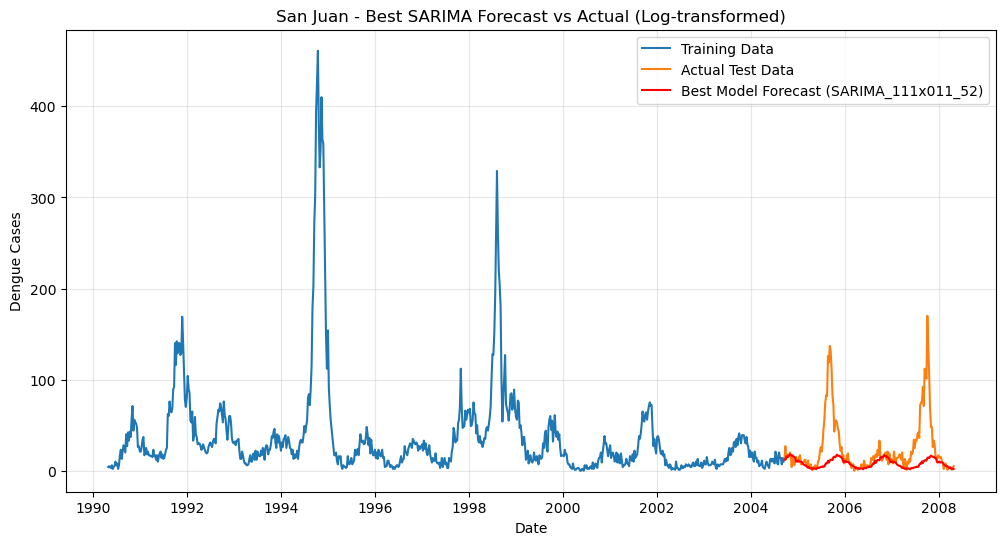

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(sj_train_cases.index, sj_train_cases, label='Training Data')
plt.plot(sj_test.index, sj_test['total_cases'], label='Actual Test Data')
plt.plot(sj_test.index, results_dict[best_model_name]['pred_mean'], label=f'Best Model Forecast ({best_model_name})', color='red')
plt.title(f'San Juan - Best SARIMA Forecast vs Actual (Log-transformed)')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

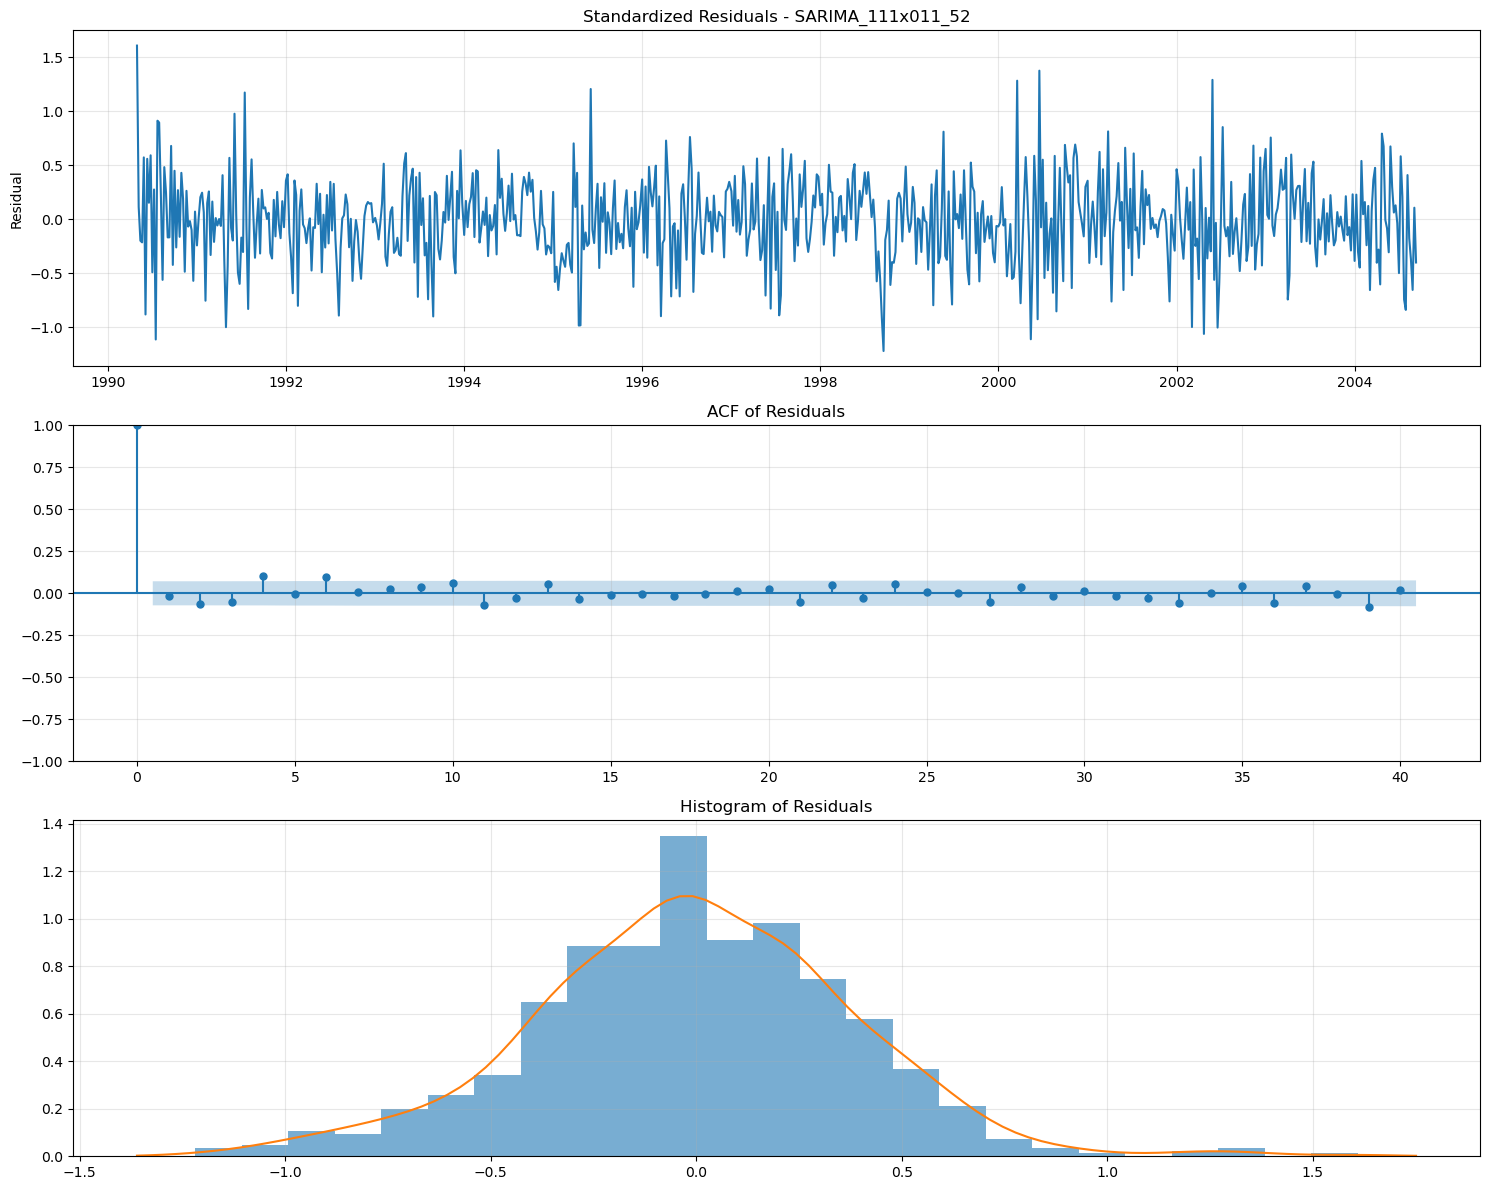

In [75]:
best_model = results_dict[best_model_name]['model']

plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(best_model.resid)
plt.title(f'Standardized Residuals - {best_model_name}')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.subplot(312)
plot_acf(best_model.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(313)
plt.hist(best_model.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

kde = stats.gaussian_kde(best_model.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [76]:
lb_test = acorr_ljungbox(best_model.resid, lags=[10, 20, 30])
print(f"Ljung-Box Test for {best_model_name}:")
print(lb_test)

Ljung-Box Test for SARIMA_111x011_52:
      lb_stat  lb_pvalue
10  25.020269   0.005307
20  33.396135   0.030512
30  44.119169   0.046520


# Adding exogenous variables to original log transformation model (has lowest MAE of 17.38)

In [77]:
sj_train_cases_log = np.log1p(sj_train_cases)
sj_test_cases_log = np.log1p(sj_test['total_cases'])

In [78]:
p, d, q = 1, 1, 1
P, D, Q, s = 0, 1, 1, 52

In [79]:
exog_vars = [
    'reanalysis_specific_humidity_g_per_kg_roll_8_std',
    'reanalysis_relative_humidity_percent_roll_4_mean',
    'ndvi_ne_roll_2_mean',
    'reanalysis_tdtr_k_roll_8_mean',
    'precipitation_amt_mm_roll_2_std'
]

In [80]:
available_vars = [var for var in exog_vars if var in sj_train.columns]
print(f"Available exogenous variables: {available_vars}")

Available exogenous variables: ['reanalysis_specific_humidity_g_per_kg_roll_8_std', 'reanalysis_relative_humidity_percent_roll_4_mean', 'ndvi_ne_roll_2_mean', 'reanalysis_tdtr_k_roll_8_mean', 'precipitation_amt_mm_roll_2_std']


In [81]:
X_train = sj_train[available_vars].copy()
X_test = sj_test[available_vars].copy()

sj_sarimax_log = SARIMAX(
    sj_train_cases_log,
    exog=X_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [82]:
try:
    sj_sarimax_log_results = sj_sarimax_log.fit(disp=False)
    print("San Juan SARIMAX Model (Log-transformed with exogenous variables) Summary:")
    print(sj_sarimax_log_results.summary().tables[0])
    print(sj_sarimax_log_results.summary().tables[1])
except Exception as e:
    print(f"Error fitting San Juan SARIMAX log model: {e}")
    
# Print model AIC
print(f"AIC: {sj_sarimax_log_results.aic:.2f}")

San Juan SARIMAX Model (Log-transformed with exogenous variables) Summary:
                                     SARIMAX Results                                      
Dep. Variable:                        total_cases   No. Observations:                  748
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -285.138
Date:                            Tue, 08 Apr 2025   AIC                            588.276
Time:                                    22:23:40   BIC                            628.444
Sample:                                         0   HQIC                           603.866
                                            - 748                                         
Covariance Type:                              opg                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

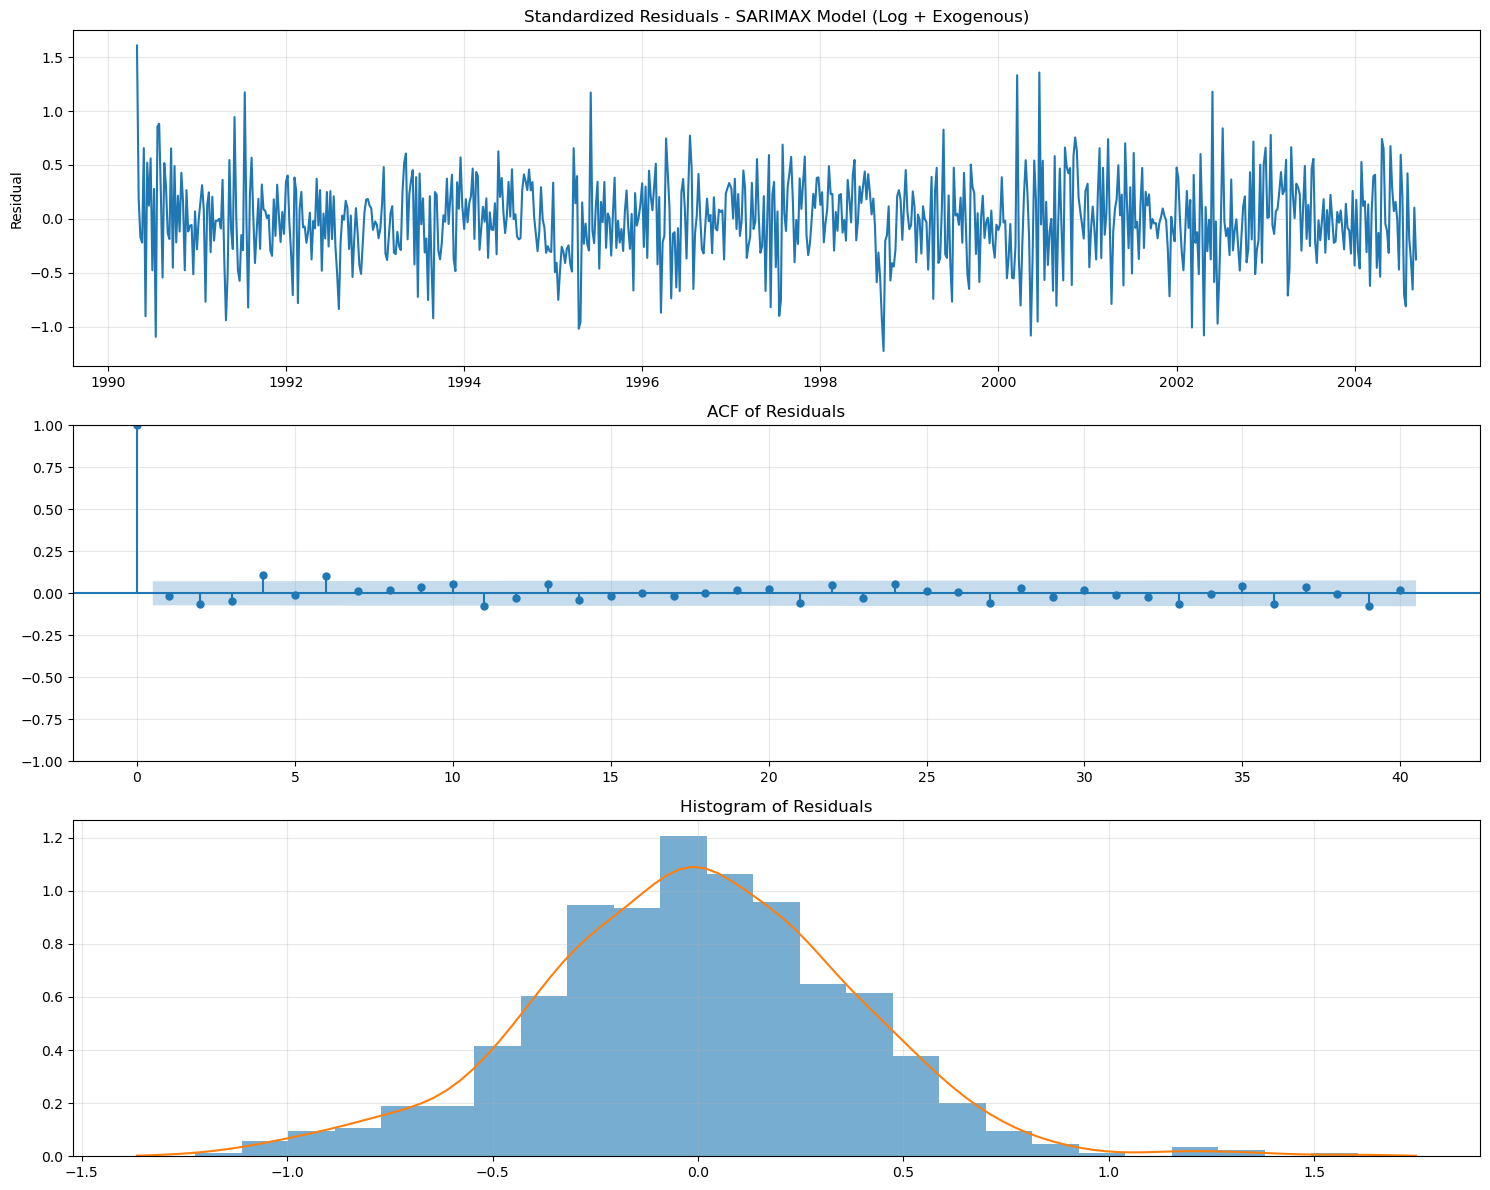

In [83]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(sj_sarimax_log_results.resid)
plt.title('Standardized Residuals - SARIMAX Model (Log + Exogenous)')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.subplot(312)
plot_acf(sj_sarimax_log_results.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(313)
plt.hist(sj_sarimax_log_results.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

kde = stats.gaussian_kde(sj_sarimax_log_results.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [84]:
lb_test = acorr_ljungbox(sj_sarimax_log_results.resid, lags=[10, 20, 30])
print("Ljung-Box Test for SARIMAX Log + Exogenous Model:")
print(lb_test)

Ljung-Box Test for SARIMAX Log + Exogenous Model:
      lb_stat  lb_pvalue
10  25.336900   0.004742
20  34.919949   0.020535
30  46.260904   0.029339


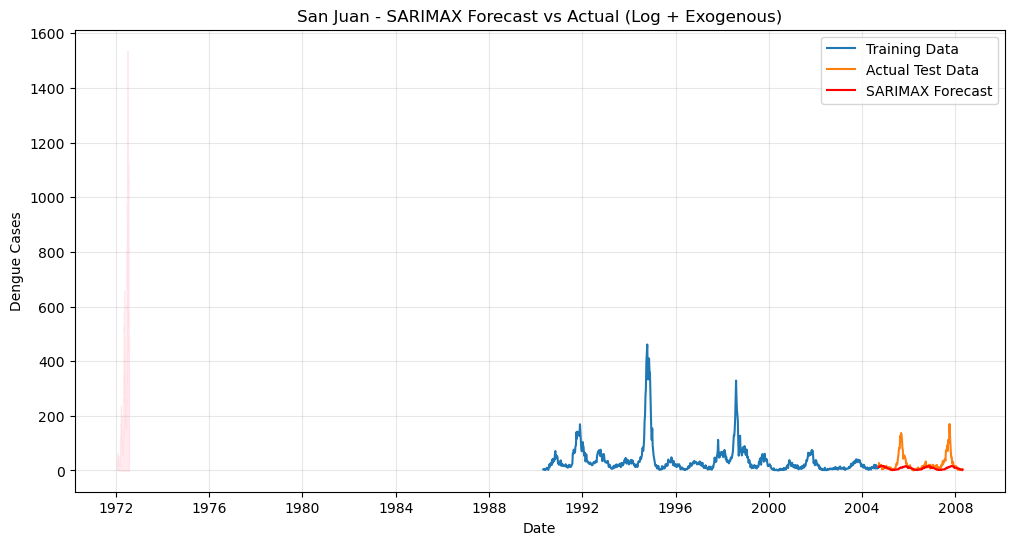

In [85]:
forecast_steps = len(sj_test)
sj_forecast_log = sj_sarimax_log_results.get_forecast(steps=forecast_steps, exog=X_test)

sj_pred_mean_log = sj_forecast_log.predicted_mean
sj_pred_ci_log = sj_forecast_log.conf_int()

sj_pred_mean = np.expm1(sj_pred_mean_log)
sj_pred_ci = np.expm1(sj_pred_ci_log)

plt.figure(figsize=(12, 6))
plt.plot(sj_train_cases.index, sj_train_cases, label='Training Data')
plt.plot(sj_test.index, sj_test['total_cases'], label='Actual Test Data')
plt.plot(sj_test.index, sj_pred_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(
    sj_pred_ci.index,
    sj_pred_ci.iloc[:, 0],
    sj_pred_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('San Juan - SARIMAX Forecast vs Actual (Log + Exogenous)')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [86]:
sj_mae = mean_absolute_error(sj_test['total_cases'], sj_pred_mean)
mae_log = mean_absolute_error(sj_test_cases_log, sj_pred_mean_log)

print(f"San Juan SARIMAX Log + Exog Model - MAE: {sj_mae:.2f}")
print(f"San Juan SARIMAX Log + Exog Model - MAE in log space: {mae_log:.4f}")

San Juan SARIMAX Log + Exog Model - MAE: 17.54
San Juan SARIMAX Log + Exog Model - MAE in log space: 0.7980


# Original log transformation model is still highest performing (MAE 17.38). Final attempt to improve will be doing a grid search on the SARIMA orders to find the optimal parameters.

In [87]:
sj_train_cases_log = np.log1p(sj_train_cases)
sj_test_cases_log = np.log1p(sj_test['total_cases'])

In [89]:
import itertools
# Define parameter ranges for grid search
p_range = range(0, 3)  # AR order
d_range = range(0, 2)  # Differencing
q_range = range(0, 3)  # MA order
P_range = range(0, 2)  # Seasonal AR
D_range = range(0, 2)  # Seasonal differencing
Q_range = range(0, 2)  # Seasonal MA
s = 52  # Use annual seasonality (52 weeks)

param_combinations = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))

In [90]:
results = []

best_mae = float('inf')
best_params = None
best_model = None

total_combinations = len(param_combinations)
print(f"Total parameter combinations to test: {total_combinations}")

Total parameter combinations to test: 144


In [91]:
for i, (p, d, q, P, D, Q) in enumerate(param_combinations):
    print(f"Testing combination {i+1}/{total_combinations}: SARIMA({p},{d},{q})x({P},{D},{Q},{s})")
    
    try:
        model = SARIMAX(
            sj_train_cases_log,
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        model_fit = model.fit(disp=False, maxiter=50)
        
        forecast_log = model_fit.get_forecast(steps=len(sj_test))
        pred_mean_log = forecast_log.predicted_mean
        
        pred_mean = np.expm1(pred_mean_log)
        
        mae = mean_absolute_error(sj_test['total_cases'], pred_mean)
        mae_log = mean_absolute_error(sj_test_cases_log, pred_mean_log)
        
        results.append({
            'p': p, 'd': d, 'q': q, 
            'P': P, 'D': D, 'Q': Q,
            'AIC': model_fit.aic,
            'MAE': mae,
            'MAE_log': mae_log
        })
        
        if mae < best_mae:
            best_mae = mae
            best_params = (p, d, q, P, D, Q)
            print(f"New best model: SARIMA({p},{d},{q})x({P},{D},{Q},{s}) with MAE: {mae:.2f}")
        
    except Exception as e:
        print(f"Error fitting SARIMA({p},{d},{q})x({P},{D},{Q},{s}): {e}")
        continue

Testing combination 1/144: SARIMA(0,0,0)x(0,0,0,52)
New best model: SARIMA(0,0,0)x(0,0,0,52) with MAE: 24.69
Testing combination 2/144: SARIMA(0,0,0)x(0,0,1,52)
Testing combination 3/144: SARIMA(0,0,0)x(0,1,0,52)
New best model: SARIMA(0,0,0)x(0,1,0,52) with MAE: 17.07
Testing combination 4/144: SARIMA(0,0,0)x(0,1,1,52)
Testing combination 5/144: SARIMA(0,0,0)x(1,0,0,52)
Testing combination 6/144: SARIMA(0,0,0)x(1,0,1,52)
New best model: SARIMA(0,0,0)x(1,0,1,52) with MAE: 16.67
Testing combination 7/144: SARIMA(0,0,0)x(1,1,0,52)
New best model: SARIMA(0,0,0)x(1,1,0,52) with MAE: 15.50
Testing combination 8/144: SARIMA(0,0,0)x(1,1,1,52)
Testing combination 9/144: SARIMA(0,0,1)x(0,0,0,52)
Testing combination 10/144: SARIMA(0,0,1)x(0,0,1,52)
Testing combination 11/144: SARIMA(0,0,1)x(0,1,0,52)
Testing combination 12/144: SARIMA(0,0,1)x(0,1,1,52)
Testing combination 13/144: SARIMA(0,0,1)x(1,0,0,52)
Testing combination 14/144: SARIMA(0,0,1)x(1,0,1,52)
Testing combination 15/144: SARIMA(0,0,

In [92]:
results_df = pd.DataFrame(results)

In [93]:
print("\nTop 10 SARIMA models by MAE:")
top_models = results_df.sort_values('MAE').head(10)
print(top_models)


Top 10 SARIMA models by MAE:
     p  d  q  P  D  Q          AIC        MAE   MAE_log
6    0  0  0  1  1  0  1926.027639  15.495690  0.616498
22   0  0  2  1  1  0  1232.764517  15.553388  0.621307
14   0  0  1  1  1  0  1457.261127  15.600102  0.624444
102  2  0  0  1  1  0   771.565131  15.647732  0.626619
54   1  0  0  1  1  0   840.085204  15.676607  0.628584
110  2  0  1  1  1  0   737.563528  15.771775  0.633280
70   1  0  2  1  1  0   737.900295  15.774890  0.633484
62   1  0  1  1  1  0   737.748203  15.776773  0.633628
118  2  0  2  1  1  0   739.086547  15.788035  0.634242
63   1  0  1  1  1  1   585.043744  16.117453  0.661202


In [94]:
p, d, q, P, D, Q = best_params
print(f"\nRefitting best model: SARIMA({p},{d},{q})x({P},{D},{Q},{s})")

best_model = SARIMAX(
    sj_train_cases_log,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

best_model_fit = best_model.fit(disp=False)


Refitting best model: SARIMA(0,0,0)x(1,1,0,52)


In [95]:
forecast_log = best_model_fit.get_forecast(steps=len(sj_test))
pred_mean_log = forecast_log.predicted_mean
pred_ci_log = forecast_log.conf_int()

pred_mean = np.expm1(pred_mean_log)
pred_ci = np.expm1(pred_ci_log)

final_mae = mean_absolute_error(sj_test['total_cases'], pred_mean)
final_mae_log = mean_absolute_error(sj_test_cases_log, pred_mean_log)

print(f"Best model SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - Final MAE: {final_mae:.2f}")
print(f"Best model SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - Final MAE in log space: {final_mae_log:.4f}")

Best model SARIMA(0,0,0)x(1,1,0,52) - Final MAE: 15.50
Best model SARIMA(0,0,0)x(1,1,0,52) - Final MAE in log space: 0.6165


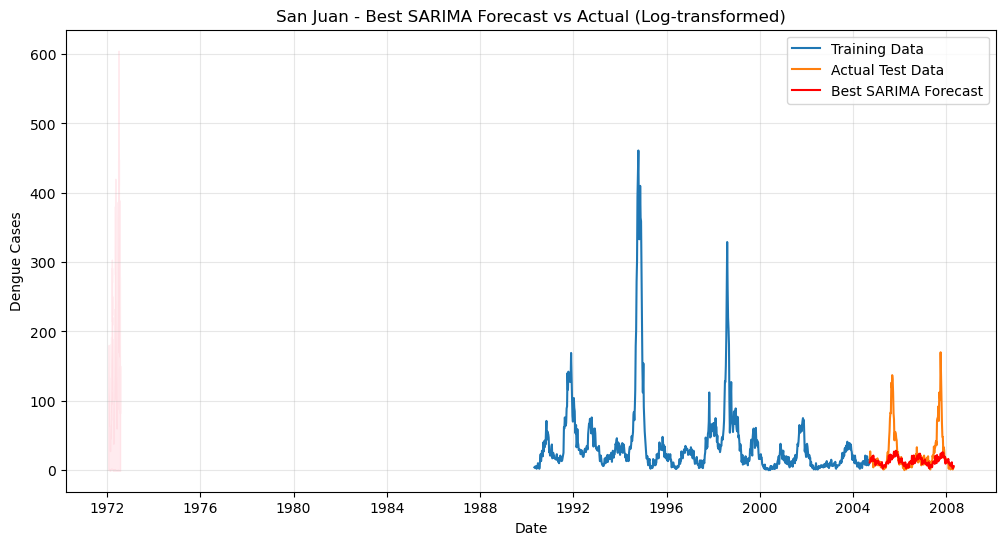

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(sj_train_cases.index, sj_train_cases, label='Training Data')
plt.plot(sj_test.index, sj_test['total_cases'], label='Actual Test Data')
plt.plot(sj_test.index, pred_mean, label=f'Best SARIMA Forecast', color='red')
plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title(f'San Juan - Best SARIMA Forecast vs Actual (Log-transformed)')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

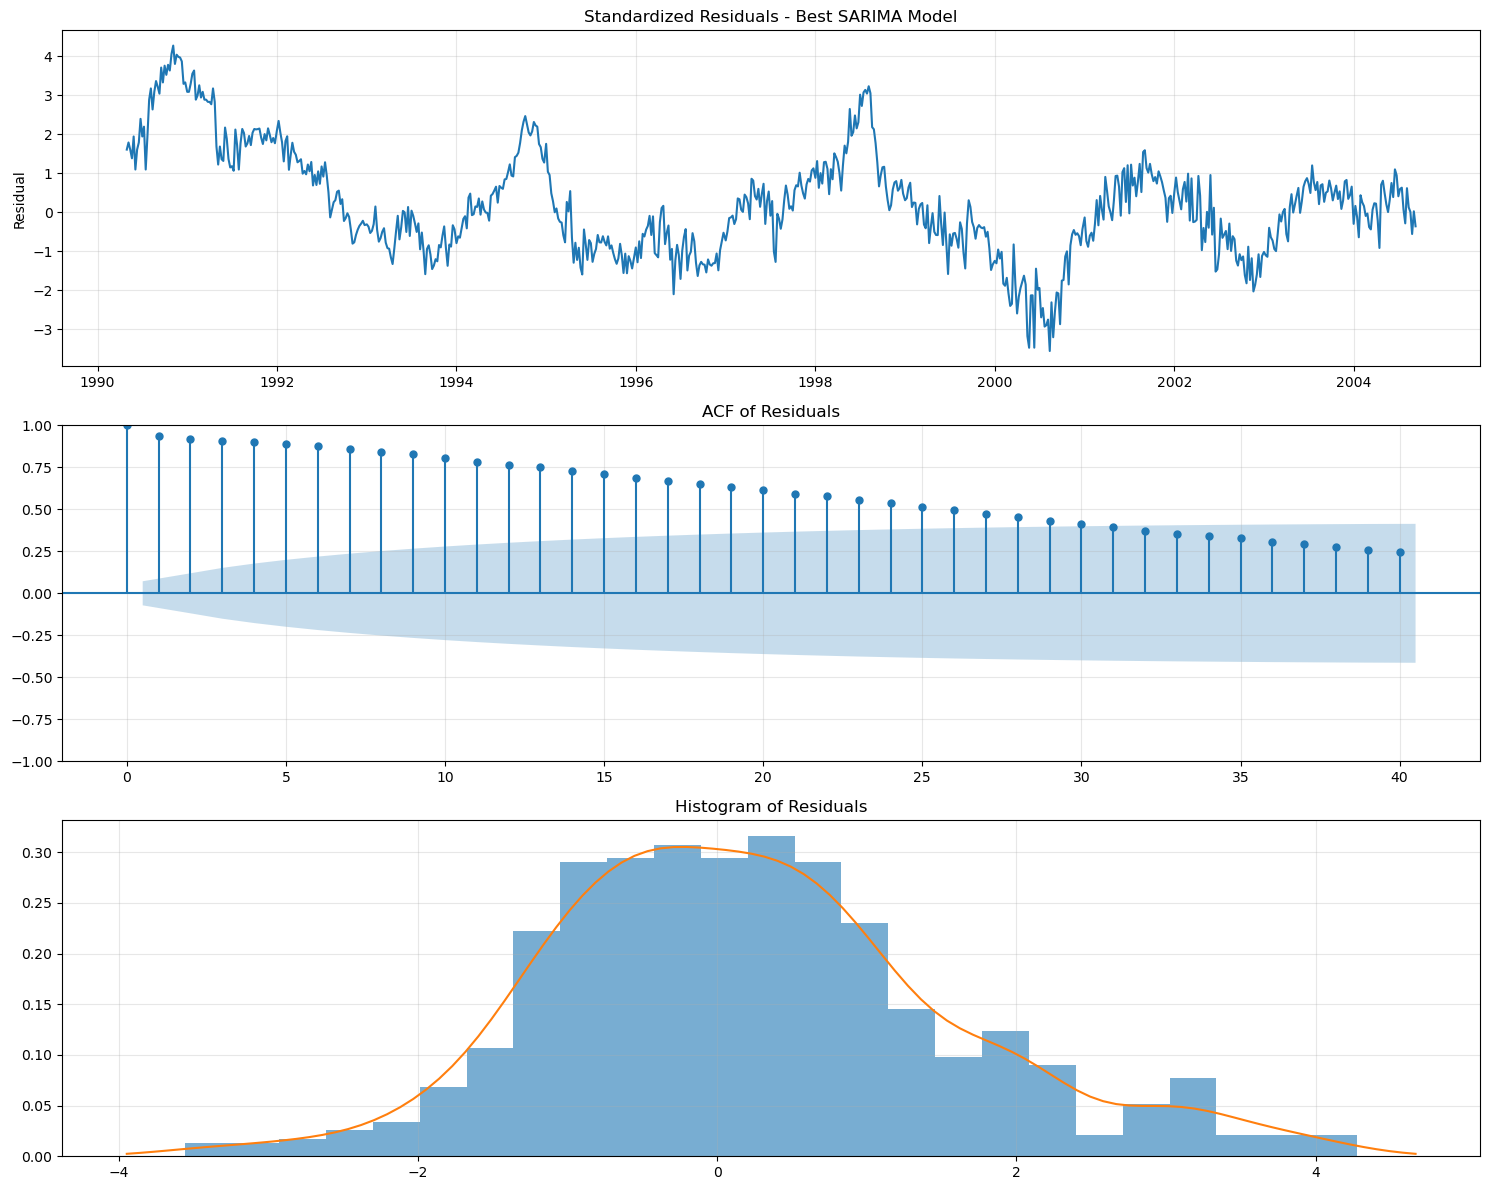

In [97]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(best_model_fit.resid)
plt.title(f'Standardized Residuals - Best SARIMA Model')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.subplot(312)
plot_acf(best_model_fit.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(313)
plt.hist(best_model_fit.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

kde = stats.gaussian_kde(best_model_fit.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [98]:
print("\nBest model summary:")
print(best_model_fit.summary().tables[0])
print(best_model_fit.summary().tables[1])


Best model summary:
                                SARIMAX Results                                 
Dep. Variable:              total_cases   No. Observations:                  748
Model:             SARIMAX(1, 1, 0, 52)   Log Likelihood                -961.014
Date:                  Tue, 08 Apr 2025   AIC                           1926.028
Time:                          23:24:59   BIC                           1934.963
Sample:                               0   HQIC                          1929.495
                                  - 748                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.5054      0.035    -14.460      0.000      -0.574      -0.437
sigma2         1.1579      0.060     19.204      0.000       1.040       1.276


# Iquitos Model (using optimal model)

In [99]:
iq_train_cases_log = np.log1p(iq_train_cases)
iq_test_cases_log = np.log1p(iq_test['total_cases'])

In [100]:
p, d, q = 0, 0, 0  # Non-seasonal parameters
P, D, Q, s = 1, 1, 0, 52  # Seasonal parameters

iq_sarima_log = SARIMAX(
    iq_train_cases_log,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [101]:
try:
    iq_sarima_log_results = iq_sarima_log.fit(disp=False)
    print("Iquitos SARIMA Model (Log-transformed) Summary:")
    print(iq_sarima_log_results.summary().tables[0])
    print(iq_sarima_log_results.summary().tables[1])
except Exception as e:
    print(f"Error fitting Iquitos SARIMA log model: {e}")
    
# Print model AIC
print(f"AIC: {iq_sarima_log_results.aic:.2f}")

Iquitos SARIMA Model (Log-transformed) Summary:
                                SARIMAX Results                                 
Dep. Variable:              total_cases   No. Observations:                  416
Model:             SARIMAX(1, 1, 0, 52)   Log Likelihood                -482.740
Date:                  Tue, 08 Apr 2025   AIC                            969.480
Time:                          23:29:54   BIC                            976.966
Sample:                               0   HQIC                           972.472
                                  - 416                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.6074      0.054    -11.245      0.000      -0.713      -0.502
sigma2         1.2925      0.090     14.395      0.000       1.117 

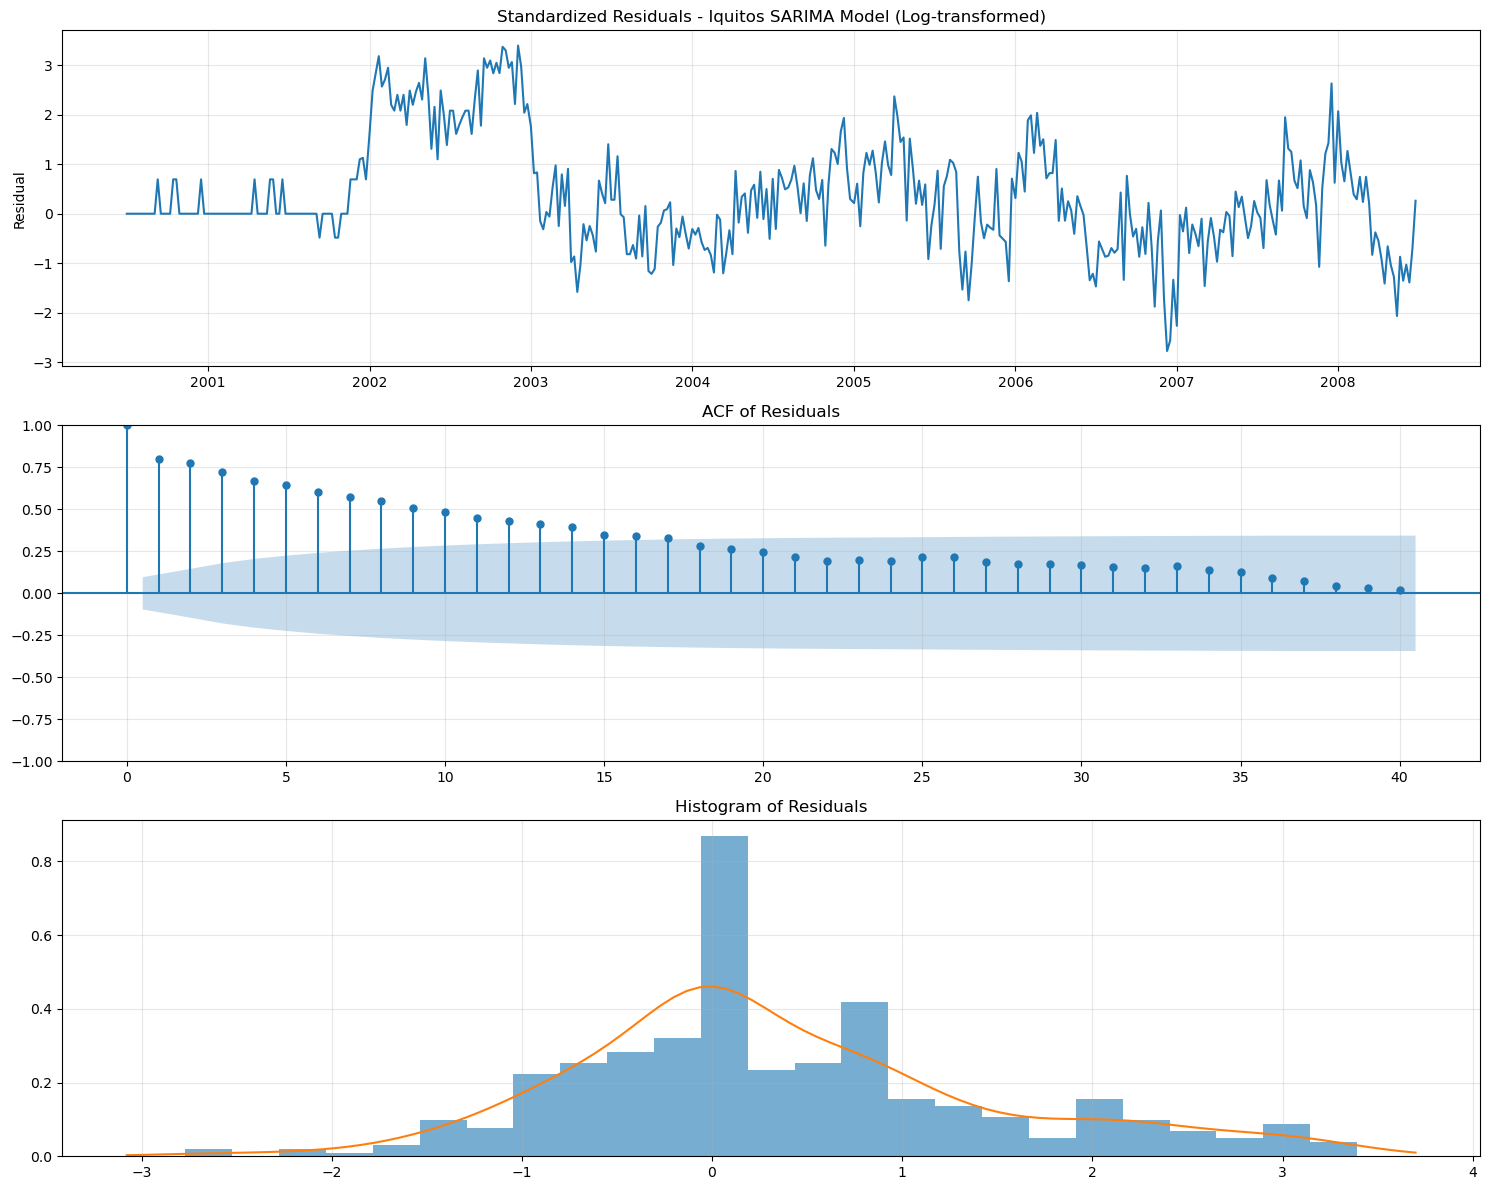

In [102]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(iq_sarima_log_results.resid)
plt.title('Standardized Residuals - Iquitos SARIMA Model (Log-transformed)')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.subplot(312)
plot_acf(iq_sarima_log_results.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(313)
plt.hist(iq_sarima_log_results.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

kde = stats.gaussian_kde(iq_sarima_log_results.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [103]:
lb_test = acorr_ljungbox(iq_sarima_log_results.resid, lags=[10, 20, 30])
print("Ljung-Box Test for Iquitos SARIMA Log Model:")
print(lb_test)

Ljung-Box Test for Iquitos SARIMA Log Model:
        lb_stat  lb_pvalue
10  1737.900512        0.0
20  2288.003731        0.0
30  2458.231398        0.0


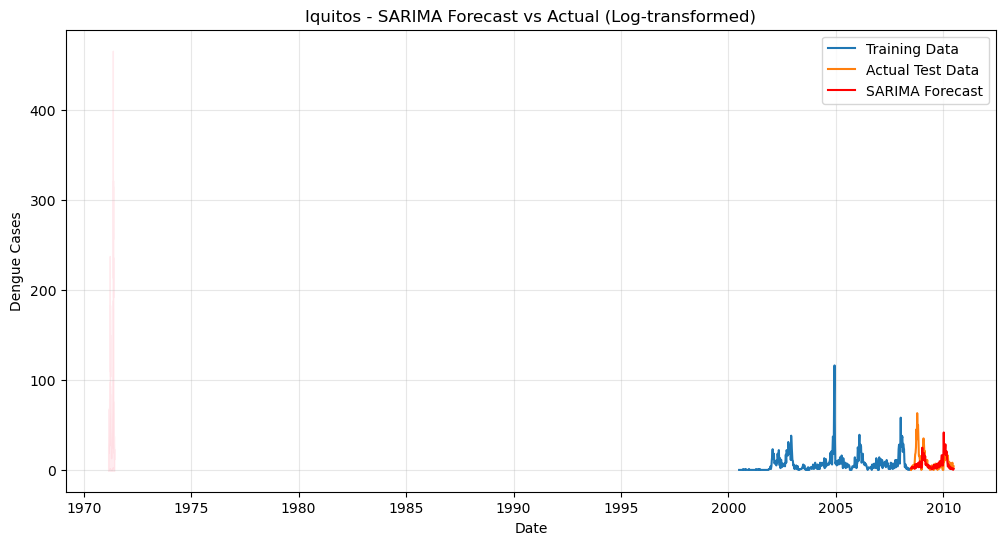

In [104]:
forecast_steps = len(iq_test)
iq_forecast_log = iq_sarima_log_results.get_forecast(steps=forecast_steps)

iq_pred_mean_log = iq_forecast_log.predicted_mean
iq_pred_ci_log = iq_forecast_log.conf_int()

iq_pred_mean = np.expm1(iq_pred_mean_log)
iq_pred_ci = np.expm1(iq_pred_ci_log)

plt.figure(figsize=(12, 6))
plt.plot(iq_train_cases.index, iq_train_cases, label='Training Data')
plt.plot(iq_test.index, iq_test['total_cases'], label='Actual Test Data')
plt.plot(iq_test.index, iq_pred_mean, label='SARIMA Forecast', color='red')
plt.fill_between(
    iq_pred_ci.index,
    iq_pred_ci.iloc[:, 0],
    iq_pred_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('Iquitos - SARIMA Forecast vs Actual (Log-transformed)')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [105]:
iq_mae = mean_absolute_error(iq_test['total_cases'], iq_pred_mean)
iq_mae_log = mean_absolute_error(iq_test_cases_log, iq_pred_mean_log)

print(f"Iquitos SARIMA Log Model - MAE: {iq_mae:.2f}")
print(f"Iquitos SARIMA Log Model - MAE in log space: {iq_mae_log:.4f}")

Iquitos SARIMA Log Model - MAE: 7.16
Iquitos SARIMA Log Model - MAE in log space: 0.7840


In [106]:
print(f"XGBoost model MAE for Iquitos was: 4.98")

XGBoost model MAE for Iquitos was: 4.98


# Conducting a grid search to capitalize on the 7.16 MAE for Iquitos

In [107]:
iq_train_cases_log = np.log1p(iq_train_cases)
iq_test_cases_log = np.log1p(iq_test['total_cases'])

In [108]:
p_range = range(0, 3)  # AR order
d_range = range(0, 2)  # Differencing
q_range = range(0, 3)  # MA order
P_range = range(0, 2)  # Seasonal AR
D_range = range(0, 2)  # Seasonal differencing
Q_range = range(0, 2)  # Seasonal MA
s = 52  # Use annual seasonality (52 weeks)

param_combinations = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))

results = []

In [109]:
best_mae = float('inf')
best_params = None
best_model = None

In [110]:
total_combinations = len(param_combinations)
print(f"Total parameter combinations to test: {total_combinations}")

Total parameter combinations to test: 144


In [111]:
for i, (p, d, q, P, D, Q) in enumerate(param_combinations):
    print(f"Testing combination {i+1}/{total_combinations}: SARIMA({p},{d},{q})x({P},{D},{Q},{s})")
    
    try:
        model = SARIMAX(
            iq_train_cases_log,
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        model_fit = model.fit(disp=False, maxiter=50)
        
        forecast_log = model_fit.get_forecast(steps=len(iq_test))
        pred_mean_log = forecast_log.predicted_mean
        
        pred_mean = np.expm1(pred_mean_log)
        
        mae = mean_absolute_error(iq_test['total_cases'], pred_mean)
        mae_log = mean_absolute_error(iq_test_cases_log, pred_mean_log)
        
        results.append({
            'p': p, 'd': d, 'q': q, 
            'P': P, 'D': D, 'Q': Q,
            'AIC': model_fit.aic,
            'MAE': mae,
            'MAE_log': mae_log
        })
        
        if mae < best_mae:
            best_mae = mae
            best_params = (p, d, q, P, D, Q)
            print(f"New best model: SARIMA({p},{d},{q})x({P},{D},{Q},{s}) with MAE: {mae:.2f}")
        
    except Exception as e:
        print(f"Error fitting SARIMA({p},{d},{q})x({P},{D},{Q},{s}): {e}")
        continue

Testing combination 1/144: SARIMA(0,0,0)x(0,0,0,52)
New best model: SARIMA(0,0,0)x(0,0,0,52) with MAE: 9.52
Testing combination 2/144: SARIMA(0,0,0)x(0,0,1,52)
New best model: SARIMA(0,0,0)x(0,0,1,52) with MAE: 9.05
Testing combination 3/144: SARIMA(0,0,0)x(0,1,0,52)
Testing combination 4/144: SARIMA(0,0,0)x(0,1,1,52)
New best model: SARIMA(0,0,0)x(0,1,1,52) with MAE: 6.32
Testing combination 5/144: SARIMA(0,0,0)x(1,0,0,52)
Testing combination 6/144: SARIMA(0,0,0)x(1,0,1,52)
Testing combination 7/144: SARIMA(0,0,0)x(1,1,0,52)
Testing combination 8/144: SARIMA(0,0,0)x(1,1,1,52)
Testing combination 9/144: SARIMA(0,0,1)x(0,0,0,52)
Testing combination 10/144: SARIMA(0,0,1)x(0,0,1,52)
Testing combination 11/144: SARIMA(0,0,1)x(0,1,0,52)
Testing combination 12/144: SARIMA(0,0,1)x(0,1,1,52)
Testing combination 13/144: SARIMA(0,0,1)x(1,0,0,52)
Testing combination 14/144: SARIMA(0,0,1)x(1,0,1,52)
Testing combination 15/144: SARIMA(0,0,1)x(1,1,0,52)
Testing combination 16/144: SARIMA(0,0,1)x(1,1

In [112]:
iq_results_df = pd.DataFrame(results)

In [113]:
print("\nTop 10 SARIMA models by MAE:")
iq_top_models = iq_results_df.sort_values('MAE').head(10)
print(iq_top_models)


Top 10 SARIMA models by MAE:
     p  d  q  P  D  Q         AIC       MAE   MAE_log
3    0  0  0  0  1  1  975.358204  6.324139  0.703510
11   0  0  1  0  1  1  821.732962  6.387377  0.711290
55   1  0  0  1  1  1  658.764485  6.401162  0.707585
19   0  0  2  0  1  1  737.845154  6.404289  0.714914
103  2  0  0  1  1  1  615.631986  6.425345  0.715089
23   0  0  2  1  1  1  727.116342  6.431271  0.713432
7    0  0  0  1  1  1  938.501368  6.478144  0.718461
15   0  0  1  1  1  1  798.352526  6.482024  0.719393
119  2  0  2  1  1  1  613.840344  6.482246  0.728335
71   1  0  2  1  1  1  611.850843  6.484620  0.728798


In [114]:
p, d, q, P, D, Q = best_params
print(f"\nRefitting best model: SARIMA({p},{d},{q})x({P},{D},{Q},{s})")

best_model = SARIMAX(
    iq_train_cases_log,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

best_model_fit = best_model.fit(disp=False)


Refitting best model: SARIMA(0,0,0)x(0,1,1,52)


In [115]:
forecast_log = best_model_fit.get_forecast(steps=len(iq_test))
pred_mean_log = forecast_log.predicted_mean
pred_ci_log = forecast_log.conf_int()

pred_mean = np.expm1(pred_mean_log)
pred_ci = np.expm1(pred_ci_log)

final_mae = mean_absolute_error(iq_test['total_cases'], pred_mean)
final_mae_log = mean_absolute_error(iq_test_cases_log, pred_mean_log)

print(f"Best model SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - Final MAE: {final_mae:.2f}")
print(f"Best model SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - Final MAE in log space: {final_mae_log:.4f}")

Best model SARIMA(0,0,0)x(0,1,1,52) - Final MAE: 6.32
Best model SARIMA(0,0,0)x(0,1,1,52) - Final MAE in log space: 0.7035


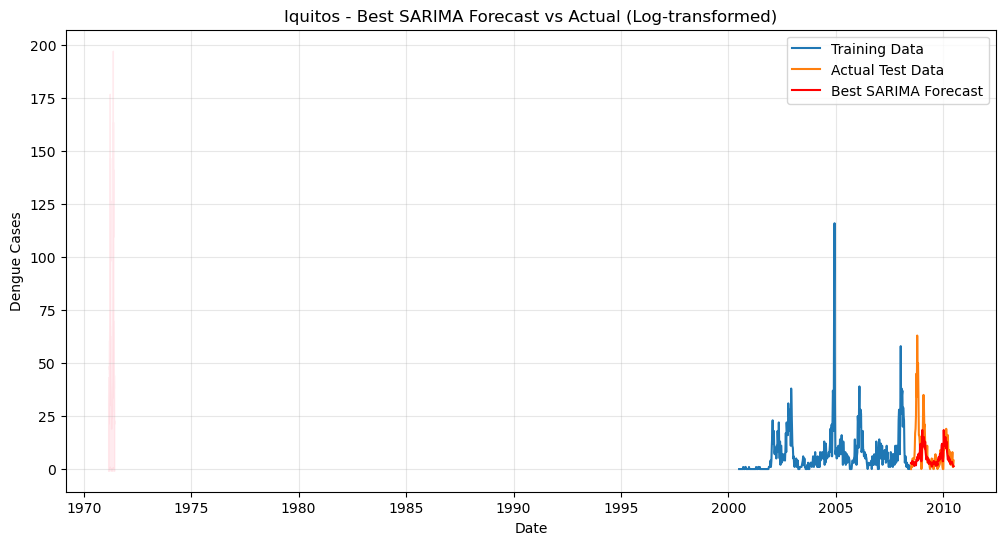

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(iq_train_cases.index, iq_train_cases, label='Training Data')
plt.plot(iq_test.index, iq_test['total_cases'], label='Actual Test Data')
plt.plot(iq_test.index, pred_mean, label=f'Best SARIMA Forecast', color='red')
plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title(f'Iquitos - Best SARIMA Forecast vs Actual (Log-transformed)')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

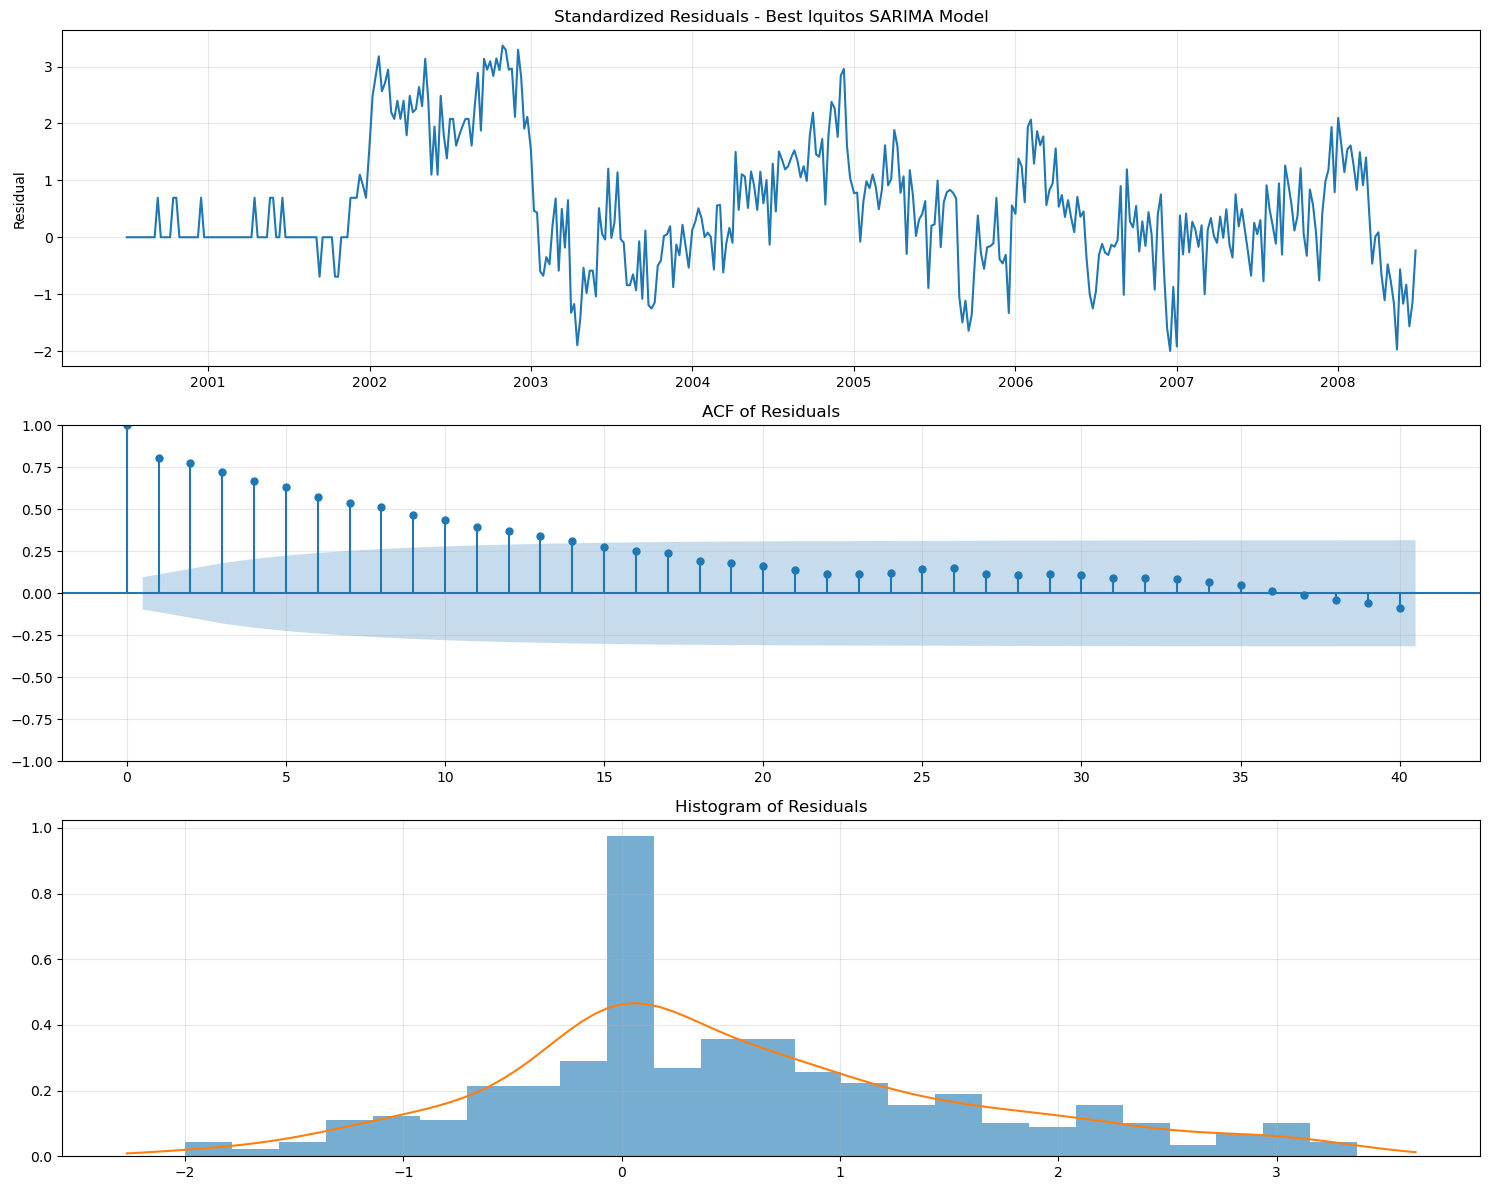

In [117]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(best_model_fit.resid)
plt.title(f'Standardized Residuals - Best Iquitos SARIMA Model')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.subplot(312)
plot_acf(best_model_fit.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(313)
plt.hist(best_model_fit.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

kde = stats.gaussian_kde(best_model_fit.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [118]:
print("\nBest model summary:")
print(best_model_fit.summary().tables[0])
print(best_model_fit.summary().tables[1])


Best model summary:
                                 SARIMAX Results                                  
Dep. Variable:                total_cases   No. Observations:                  416
Model:             SARIMAX(0, 1, [1], 52)   Log Likelihood                -485.679
Date:                    Wed, 09 Apr 2025   AIC                            975.358
Time:                            11:35:40   BIC                            982.838
Sample:                                 0   HQIC                           978.348
                                    - 416                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.6836      0.082     -8.326      0.000      -0.845      -0.523
sigma2         1.2772      0.104     12.280      0.000       1.073       1.481

# Insights for City Models

# Summary:

Our analysis of dengue fever cases in San Juan, Puerto Rico and Iquitos, Peru has led to the development of specialized forecasting models for each city. By applying time series analysis and transforming the data, we've created models that can predict dengue outbreaks with increasing accuracy, which could help health authorities prepare and allocate resources more effectively.

# Key Findings
- Patterns discoverd:
    - Seasonal Patterns: Both cities show strong annual (52-week) cycles in dengue cases
    - Different Dynamics: Despite similarities, San Juan and Iquitos have distinct outbreak patterns
    - Outbreak Triggers: Environmental factors like temperature, humidity, and rainfall show relationships with case numbers

- Model Performance:
    - Current prediction accuracy:
        - San Juan has an MAE of 15.5 (meaning that this is the average error of cases per week)
        - Iquitos has an MAE of 6.3
    - The original accuracy of the model was 37.2 (MAE) for San Juan, and 7.2 for Iquitos. 
    - There is room for improvement for the current prediciton capabilities of the model. 

# Real World Applications
- Public Health Planning:
    - Resource allocation - the models can forecast when hospitals might need additional staffing and supplies
    - Early warning - even though there is some error with the model, the models can signal when outbreaks might begin
    - Targeted prevention - understanding seasonal patterns can help time mosquito control efforts

- Model Insights:
    - In San Juan outbreaks follow patterns from previous years (autoregressive pattern)
    - In Iquitos outbreaks are influenced by recent deviations from expected patterns (moving average pattern)
    - For both cities the logarithmic transformation revealed that outbreaks grow exponentially rather than linearly

# How The Model Works
Think of the models like weather forecasts, but for disease.

1. Data tranformation - I converted case counts to a logarithmic scale, this helps the model handle sudden outbreaks better. Very similar to how the Richter scale handles earthquakes of different magnitudes.
2. Pattern recoginition - the model identified two key components:
    - Yearly cycles: recognizes that dengue follows annual patterns tied to seasons (rainy and not rainy).
    - Growth patterns: understanding how case numbers rise and fall during outbreaks
3. Forecasting - the model combines these patterns to predict future cases.
4. City-Specific Adjustments - each city needed a customized model because:
    - San Juan is a larger city, and it has more frequent and larger outbreaks
    - Iquitos is the smaller of the two cities, and it has fewer and more isolated outbreaks

# Conclusion
 Both models demonstrate that even with relatively simple mathematical approaches, useful forecasting tools can be used to predict dengue outbreaks. The models aren't perfect, but they provide valuable insights that could help reduce the impact of future outbreaks through better preparations and resource allocation.

# Next Step: A Combined City Model

In [156]:
sj_train_copy = sj_train.copy()
sj_test_copy = sj_test.copy()
iq_train_copy = iq_train.copy()
iq_test_copy = iq_test.copy()

sj_train_copy['city'] = 'sj'
sj_test_copy['city'] = 'sj'
iq_train_copy['city'] = 'iq'
iq_test_copy['city'] = 'iq'

In [157]:
combined_train = pd.concat([sj_train_copy, iq_train_copy])
combined_test = pd.concat([sj_test_copy, iq_test_copy])

combined_train = pd.get_dummies(combined_train, columns=['city'])
combined_test = pd.get_dummies(combined_test, columns=['city'])

combined_train_cases_log = np.log1p(combined_train['total_cases'])
combined_test_cases_log = np.log1p(combined_test['total_cases'])

In [158]:
exog_train = combined_train[['city_sj', 'city_iq']].astype(int)
exog_test = combined_test[['city_sj', 'city_iq']].astype(int)

In [159]:
p, d, q = 0, 0, 0
P, D, Q, s = 1, 1, 0, 52

combined_model = SARIMAX(
    combined_train_cases_log,
    exog=exog_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [160]:
try:
    combined_results = combined_model.fit(disp=False, maxiter=50)
    print("Combined SARIMA Model (Log-transformed) Summary:")
    print(combined_results.summary().tables[0])
    print(combined_results.summary().tables[1])
    
    print(f"AIC: {combined_results.aic:.2f}")
except Exception as e:
    print(f"Error fitting combined model: {e}")
    print("Data types:")
    print(f"combined_train_cases_log dtype: {combined_train_cases_log.dtype}")
    print(f"exog_train dtypes: {exog_train.dtypes}")

Combined SARIMA Model (Log-transformed) Summary:
                                SARIMAX Results                                 
Dep. Variable:              total_cases   No. Observations:                 1164
Model:             SARIMAX(1, 1, 0, 52)   Log Likelihood               -1619.815
Date:                  Wed, 09 Apr 2025   AIC                           3247.631
Time:                          15:34:09   BIC                           3267.495
Sample:                               0   HQIC                          3255.159
                                 - 1164                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
city_sj        0.9584      0.081     11.778      0.000       0.799       1.118
city_iq       -0.9584      0.081    -11.778      0.000      -1.118

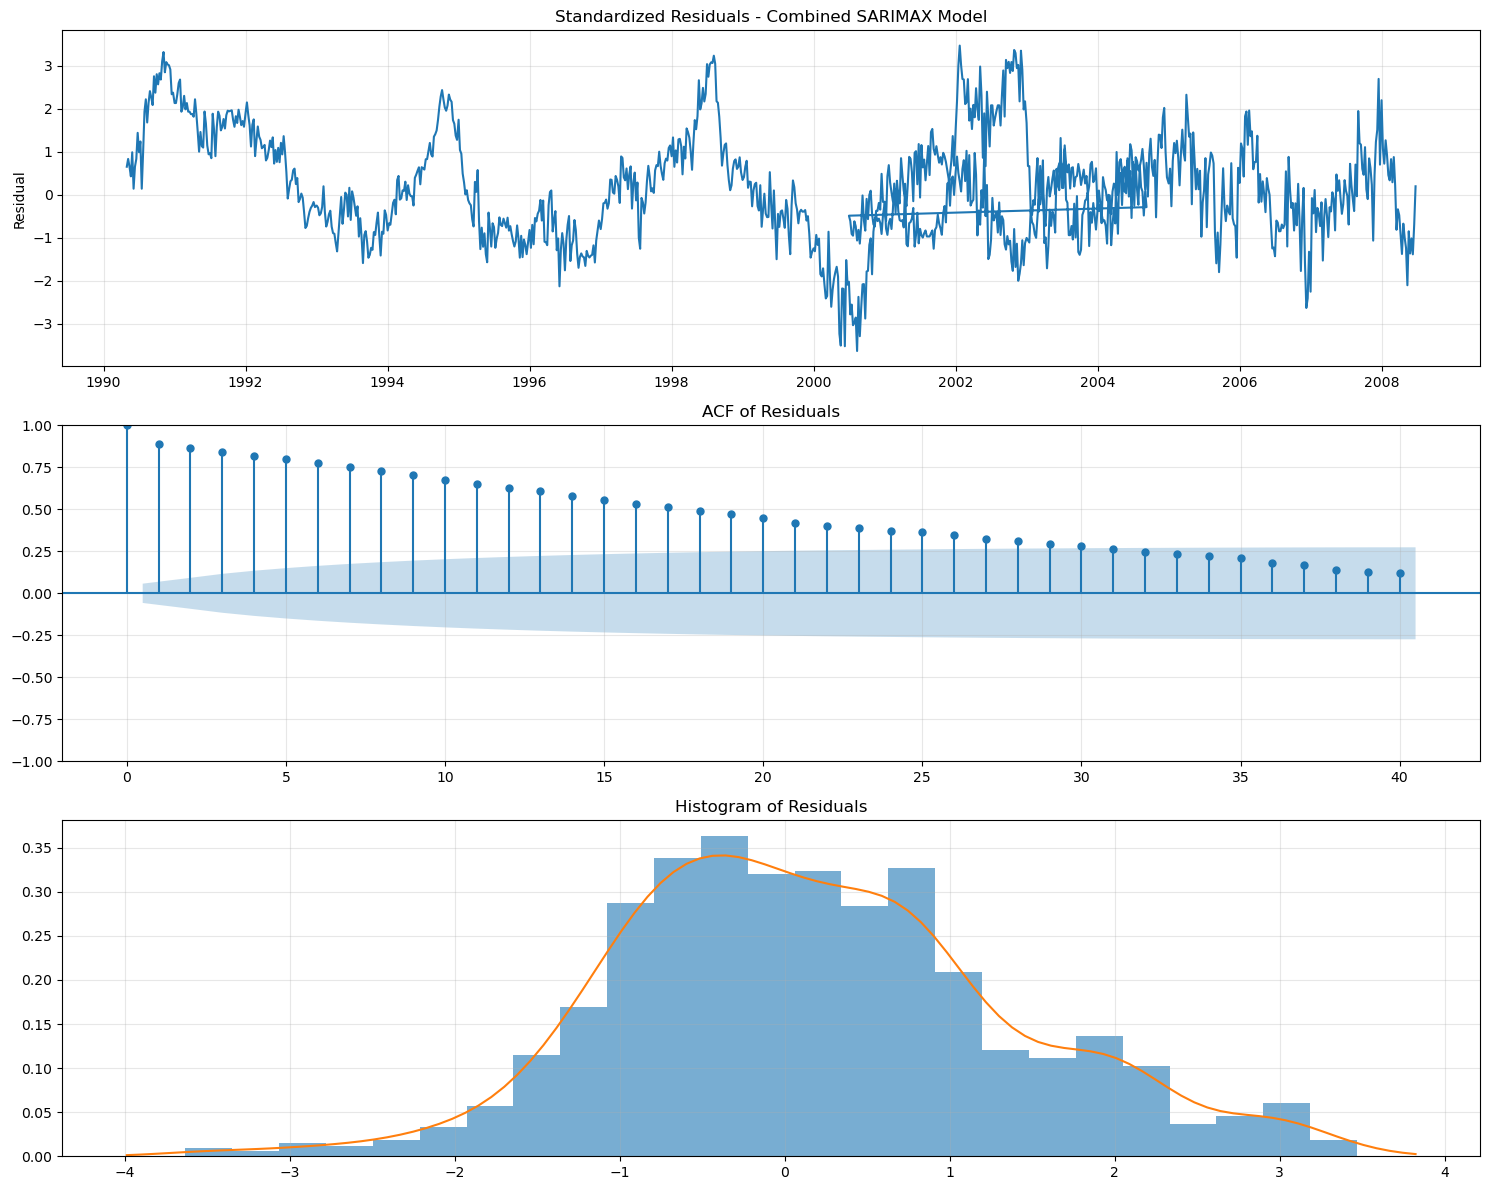

In [161]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(combined_results.resid)
plt.title('Standardized Residuals - Combined SARIMAX Model')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.subplot(312)
plot_acf(combined_results.resid, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(313)
plt.hist(combined_results.resid, bins=25, density=True, alpha=0.6)
plt.title('Histogram of Residuals')
plt.grid(True, alpha=0.3)

kde = stats.gaussian_kde(combined_results.resid)
xlim = plt.xlim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, kde(x))

plt.tight_layout()
plt.show()

In [163]:
forecast_steps = len(combined_test)
combined_forecast_log = combined_results.get_forecast(steps=forecast_steps, exog=exog_test)

pred_mean_log = combined_forecast_log.predicted_mean
pred_ci_log = combined_forecast_log.conf_int()

pred_mean = np.expm1(pred_mean_log)
pred_ci = np.expm1(pred_ci_log)

sj_indices = combined_test['city_sj'] == 1
iq_indices = combined_test['city_iq'] == 1

sj_pred = pred_mean.iloc[sj_indices.values]
iq_pred = pred_mean.iloc[iq_indices.values]

sj_ci = pred_ci.iloc[sj_indices.values]
iq_ci = pred_ci.iloc[iq_indices.values]

sj_actual = combined_test.loc[sj_indices, 'total_cases']
iq_actual = combined_test.loc[iq_indices, 'total_cases']

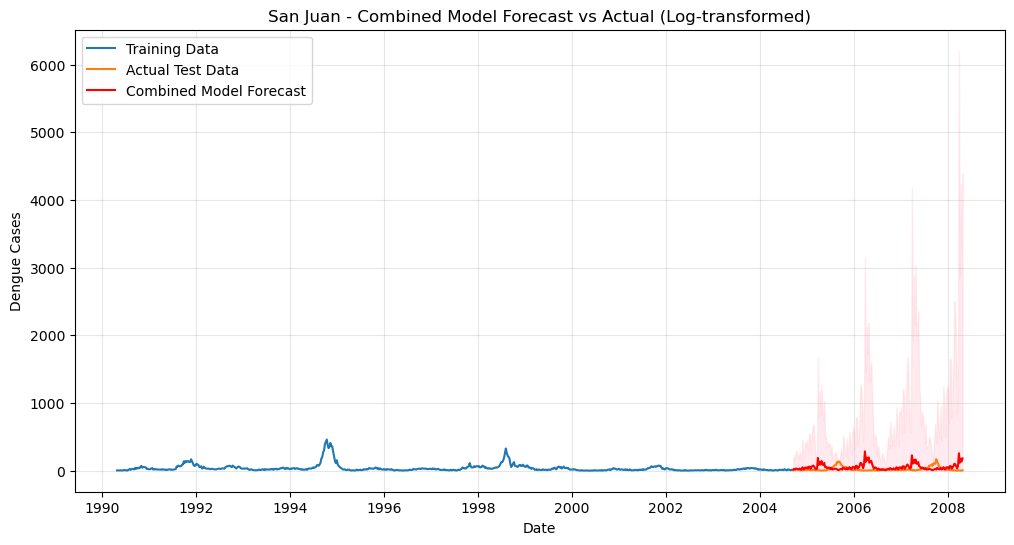

In [164]:
plt.figure(figsize=(12, 6))
plt.plot(combined_train.loc[combined_train['city_sj'] == 1].index, 
         combined_train.loc[combined_train['city_sj'] == 1, 'total_cases'], 
         label='Training Data')
plt.plot(combined_test.loc[combined_test['city_sj'] == 1].index, 
         sj_actual, 
         label='Actual Test Data')
plt.plot(combined_test.loc[combined_test['city_sj'] == 1].index, 
         sj_pred, 
         label='Combined Model Forecast', 
         color='red')
plt.fill_between(
    combined_test.loc[combined_test['city_sj'] == 1].index,
    sj_ci.iloc[:, 0],
    sj_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('San Juan - Combined Model Forecast vs Actual (Log-transformed)')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

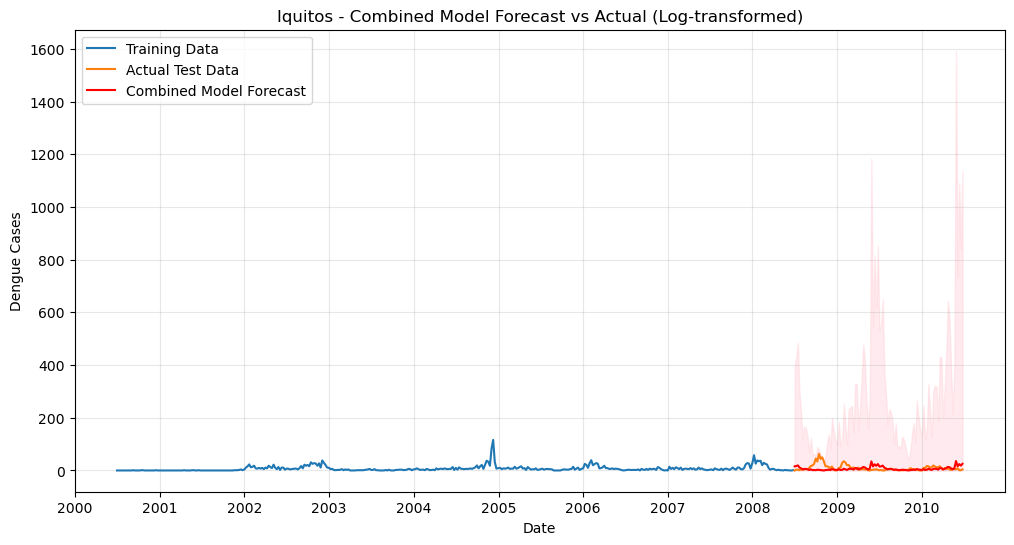

In [165]:
plt.figure(figsize=(12, 6))
plt.plot(combined_train.loc[combined_train['city_iq'] == 1].index, 
         combined_train.loc[combined_train['city_iq'] == 1, 'total_cases'], 
         label='Training Data')
plt.plot(combined_test.loc[combined_test['city_iq'] == 1].index, 
         iq_actual, 
         label='Actual Test Data')
plt.plot(combined_test.loc[combined_test['city_iq'] == 1].index, 
         iq_pred, 
         label='Combined Model Forecast', 
         color='red')
plt.fill_between(
    combined_test.loc[combined_test['city_iq'] == 1].index,
    iq_ci.iloc[:, 0],
    iq_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('Iquitos - Combined Model Forecast vs Actual (Log-transformed)')
plt.xlabel('Date')
plt.ylabel('Dengue Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [166]:
sj_mae = mean_absolute_error(sj_actual, sj_pred)
iq_mae = mean_absolute_error(iq_actual, iq_pred)
overall_mae = mean_absolute_error(combined_test['total_cases'], pred_mean)

print(f"Combined Model - San Juan MAE: {sj_mae:.2f}")
print(f"Combined Model - Iquitos MAE: {iq_mae:.2f}")
print(f"Combined Model - Overall MAE: {overall_mae:.2f}")

Combined Model - San Juan MAE: 52.37
Combined Model - Iquitos MAE: 10.27
Combined Model - Overall MAE: 37.37


# Final thought:

- SARIMA model can not handle the different patterns for both cities when combined. They are two very different cities. So the model is overgeneralizing too much
- Both cities have coefficients with opposite signs but similar magnitudes (0.9584 and -0.9584). So this suggests the model is essentially using these variables to offset each other, rather than capture city-specific dynamics effectively.
- The ACF plot of residuals shows significant autocorrelation remaining, indicating the model isn't capturing all temporal dependencies.
- San Juan generally has higher case counts than Iquitos, which might lead the model to prioritize fitting San Juan's patterns at the expense of Iquitos.
- The combined model uses a single set of parameters that may be a compromise between optimal settings for each city.

# When it comes to SARIMA it's best to use individual models for each city.

# Final step for this notebook: Try an ensemble between SARIMA AND XGBRegressor Model

# Build out LSTM Predictor. Neural Network!

In [169]:
xgb_predictions = pd.read_csv('xgb_predictions.csv')
xgb_predictions['week_start_date'] = pd.to_datetime(xgb_predictions['week_start_date'])

In [170]:
sj_forecast_log = sj_sarima_log_results.get_forecast(steps=len(sj_test))
sj_pred_mean_log = sj_forecast_log.predicted_mean
sj_pred_mean = np.expm1(sj_pred_mean_log)

iq_forecast_log = iq_sarima_log_results.get_forecast(steps=len(iq_test)) 
iq_pred_mean_log = iq_forecast_log.predicted_mean
iq_pred_mean = np.expm1(iq_pred_mean_log)

In [171]:
sarima_sj = pd.DataFrame({
    'city': 'sj',
    'week_start_date': sj_test.index,
    'sarima_predicted': sj_pred_mean.values
})

sarima_iq = pd.DataFrame({
    'city': 'iq',
    'week_start_date': iq_test.index,
    'sarima_predicted': iq_pred_mean.values
})

sarima_predictions = pd.concat([sarima_sj, sarima_iq])
sarima_predictions['week_start_date'] = pd.to_datetime(sarima_predictions['week_start_date'])

In [172]:
ensemble_df = pd.merge(
    xgb_predictions,
    sarima_predictions,
    on=['city', 'week_start_date']
)

In [173]:
weights = {
    'xgb': 0.8,
    'sarima': 0.2
}

In [174]:
ensemble_df['ensemble_predicted'] = (
    weights['xgb'] * ensemble_df['xgb_predicted'] + 
    weights['sarima'] * ensemble_df['sarima_predicted']
)

In [175]:
ensemble_mae = mean_absolute_error(ensemble_df['total_cases'], ensemble_df['ensemble_predicted'])
sj_ensemble_mae = mean_absolute_error(
    ensemble_df[ensemble_df['city'] == 'sj']['total_cases'], 
    ensemble_df[ensemble_df['city'] == 'sj']['ensemble_predicted']
)
iq_ensemble_mae = mean_absolute_error(
    ensemble_df[ensemble_df['city'] == 'iq']['total_cases'], 
    ensemble_df[ensemble_df['city'] == 'iq']['ensemble_predicted']
)

print(f"Ensemble model - Overall test MAE: {ensemble_mae:.2f}")
print(f"Ensemble model - San Juan test MAE: {sj_ensemble_mae:.2f}")
print(f"Ensemble model - Iquitos test MAE: {iq_ensemble_mae:.2f}")

Ensemble model - Overall test MAE: 6.26
Ensemble model - San Juan test MAE: 7.42
Ensemble model - Iquitos test MAE: 4.16


NameError: name 'mdates' is not defined

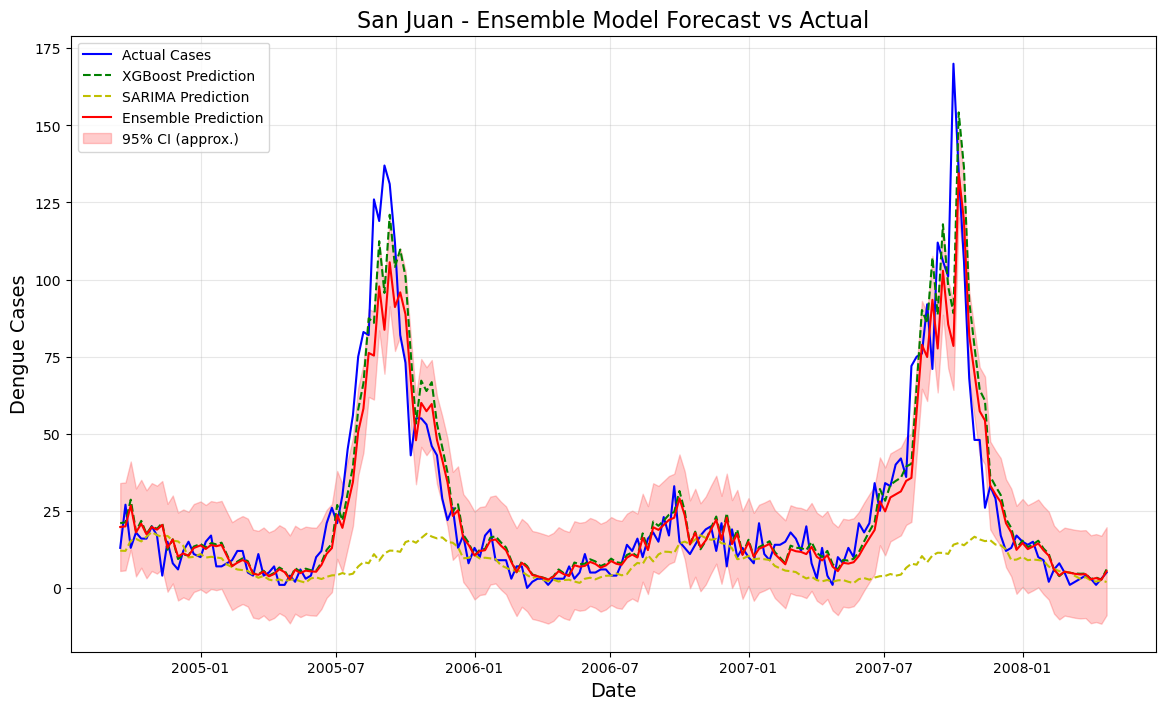

In [209]:
plt.figure(figsize=(14, 8))

sj_data = ensemble_df[ensemble_df['city'] == 'sj'].sort_values('week_start_date')

plt.plot(sj_data['week_start_date'], sj_data['total_cases'], 'b-', label='Actual Cases')
plt.plot(sj_data['week_start_date'], sj_data['xgb_predicted'], 'g--', label='XGBoost Prediction')
plt.plot(sj_data['week_start_date'], sj_data['sarima_predicted'], 'y--', label='SARIMA Prediction')
plt.plot(sj_data['week_start_date'], sj_data['ensemble_predicted'], 'r-', label='Ensemble Prediction')

residuals = abs(sj_data['ensemble_predicted'] - sj_data['total_cases'])
std = residuals.mean()
plt.fill_between(
    sj_data['week_start_date'],
    sj_data['ensemble_predicted'] - 1.96*std,
    sj_data['ensemble_predicted'] + 1.96*std,
    color='r', alpha=0.2, label='95% CI (approx.)'
)

plt.title('San Juan - Ensemble Model Forecast vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Dengue Cases', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.figtext(
    0.15, 0.02,
    f"San Juan MAE:\nXGBoost: 7.46\nSARIMA: 15.50\nEnsemble: 7.42",
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('san_juan_ensemble_forecast.png', dpi=300)
plt.show()

NameError: name 'mdates' is not defined

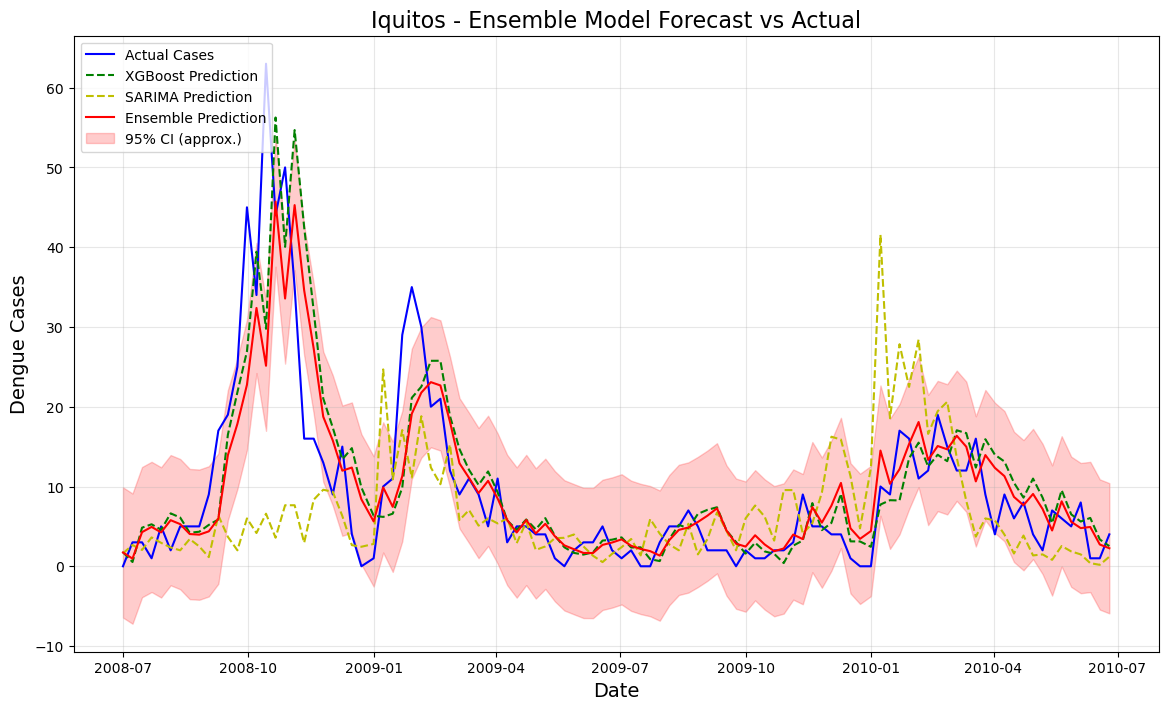

In [177]:
plt.figure(figsize=(14, 8))

iq_data = ensemble_df[ensemble_df['city'] == 'iq'].sort_values('week_start_date')

plt.plot(iq_data['week_start_date'], iq_data['total_cases'], 'b-', label='Actual Cases')
plt.plot(iq_data['week_start_date'], iq_data['xgb_predicted'], 'g--', label='XGBoost Prediction')
plt.plot(iq_data['week_start_date'], iq_data['sarima_predicted'], 'y--', label='SARIMA Prediction')
plt.plot(iq_data['week_start_date'], iq_data['ensemble_predicted'], 'r-', label='Ensemble Prediction')

residuals = abs(iq_data['ensemble_predicted'] - iq_data['total_cases'])
std = residuals.mean()
plt.fill_between(
    iq_data['week_start_date'],
    iq_data['ensemble_predicted'] - 1.96*std,
    iq_data['ensemble_predicted'] + 1.96*std,
    color='r', alpha=0.2, label='95% CI (approx.)'
)

plt.title('Iquitos - Ensemble Model Forecast vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Dengue Cases', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.figtext(
    0.15, 0.02,
    f"Iquitos MAE:\nXGBoost: 4.62\nSARIMA: 6.32\nEnsemble: 4.16",
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('iquitos_ensemble_forecast.png', dpi=300)
plt.show()

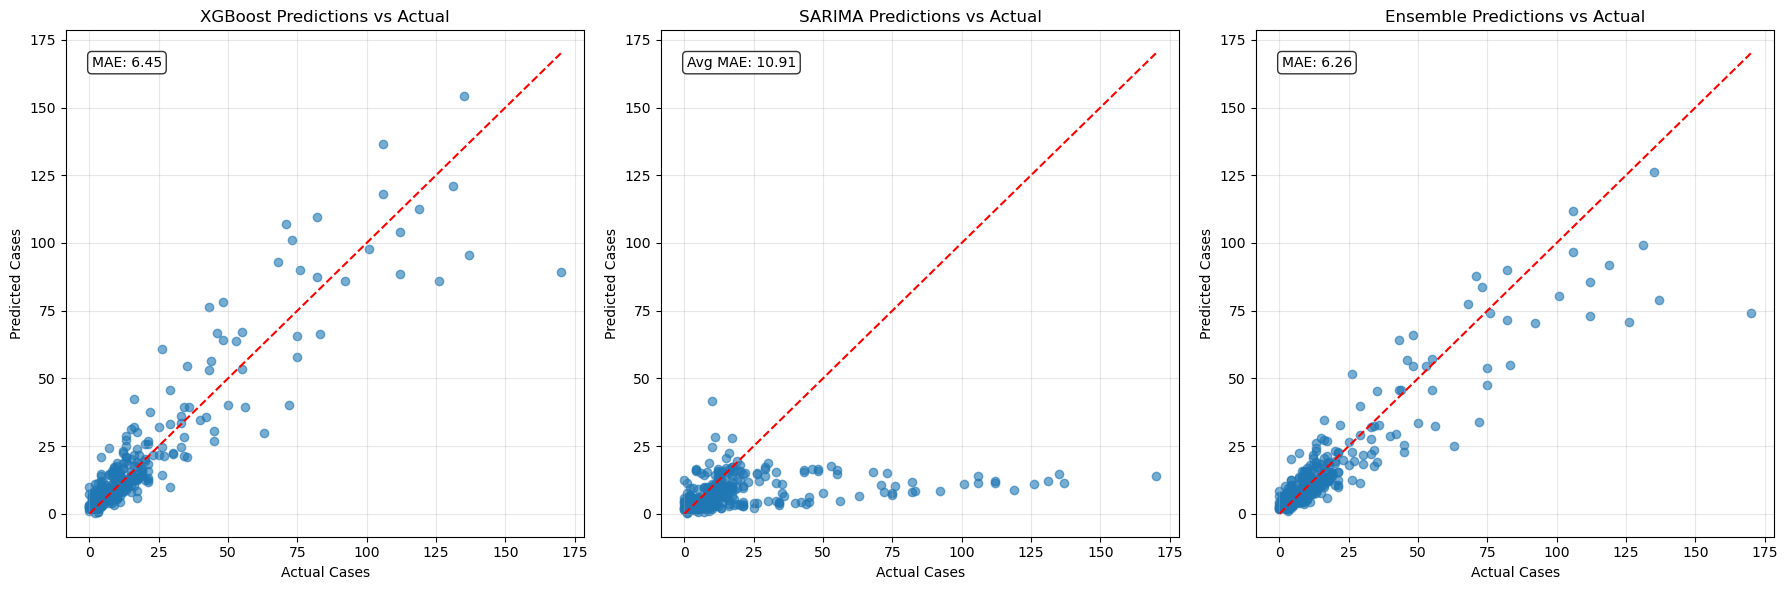

In [178]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(ensemble_df['total_cases'], ensemble_df['xgb_predicted'], alpha=0.6)
axes[0].plot([0, ensemble_df['total_cases'].max()], [0, ensemble_df['total_cases'].max()], 'r--')
axes[0].set_title('XGBoost Predictions vs Actual')
axes[0].set_xlabel('Actual Cases')
axes[0].set_ylabel('Predicted Cases')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'MAE: {6.45:.2f}', transform=axes[0].transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1].scatter(ensemble_df['total_cases'], ensemble_df['sarima_predicted'], alpha=0.6)
axes[1].plot([0, ensemble_df['total_cases'].max()], [0, ensemble_df['total_cases'].max()], 'r--')
axes[1].set_title('SARIMA Predictions vs Actual')
axes[1].set_xlabel('Actual Cases')
axes[1].set_ylabel('Predicted Cases')
axes[1].grid(True, alpha=0.3)
sarima_mae = (15.50 + 6.32) / 2
axes[1].text(0.05, 0.95, f'Avg MAE: {sarima_mae:.2f}', transform=axes[1].transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[2].scatter(ensemble_df['total_cases'], ensemble_df['ensemble_predicted'], alpha=0.6)
axes[2].plot([0, ensemble_df['total_cases'].max()], [0, ensemble_df['total_cases'].max()], 'r--')
axes[2].set_title('Ensemble Predictions vs Actual')
axes[2].set_xlabel('Actual Cases')
axes[2].set_ylabel('Predicted Cases')
axes[2].grid(True, alpha=0.3)
axes[2].text(0.05, 0.95, f'MAE: {6.26:.2f}', transform=axes[2].transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('prediction_accuracy_comparison.png', dpi=300)
plt.show()

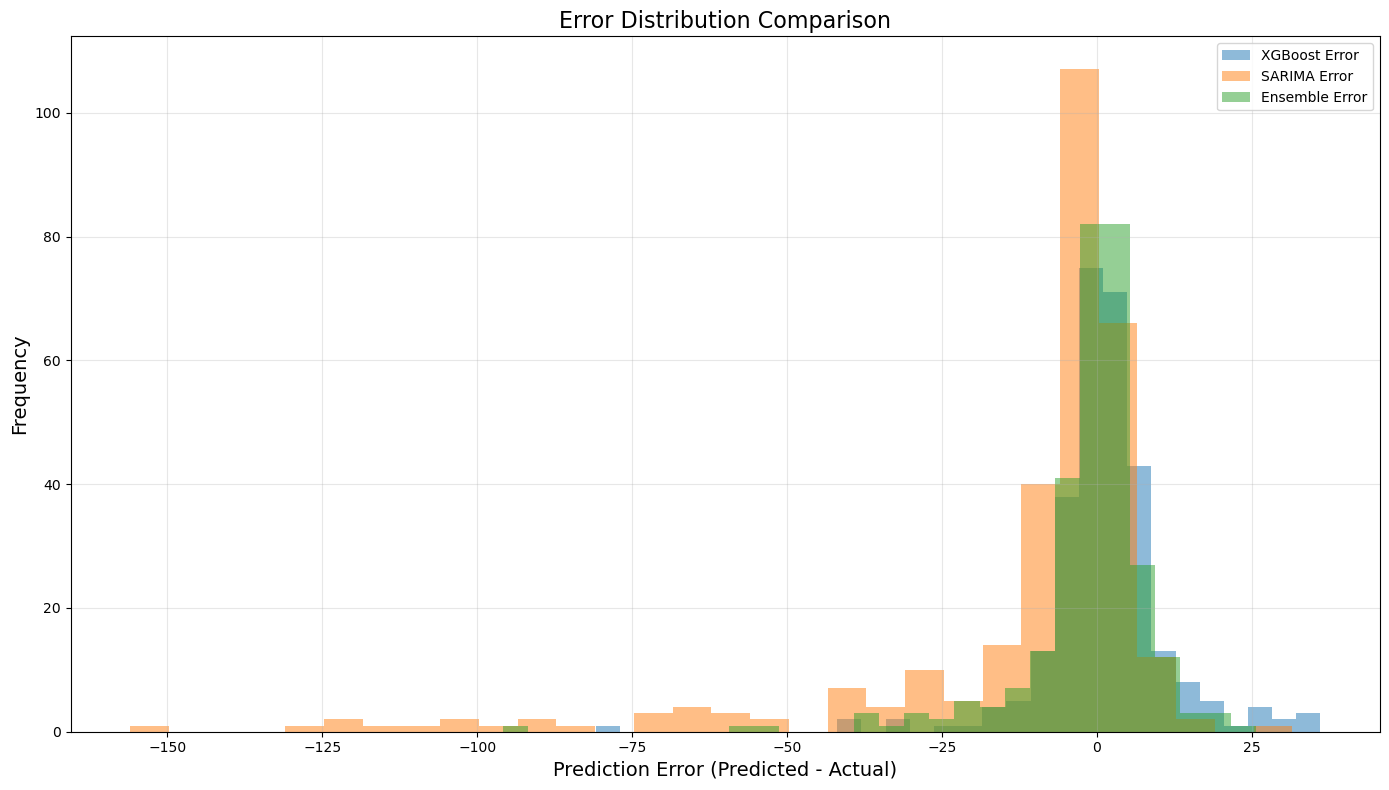

In [179]:
plt.figure(figsize=(14, 8))

ensemble_df['xgb_error'] = ensemble_df['xgb_predicted'] - ensemble_df['total_cases']
ensemble_df['sarima_error'] = ensemble_df['sarima_predicted'] - ensemble_df['total_cases']
ensemble_df['ensemble_error'] = ensemble_df['ensemble_predicted'] - ensemble_df['total_cases']

plt.hist(ensemble_df['xgb_error'], bins=30, alpha=0.5, label='XGBoost Error')
plt.hist(ensemble_df['sarima_error'], bins=30, alpha=0.5, label='SARIMA Error')
plt.hist(ensemble_df['ensemble_error'], bins=30, alpha=0.5, label='Ensemble Error')

plt.title('Error Distribution Comparison', fontsize=16)
plt.xlabel('Prediction Error (Predicted - Actual)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300)
plt.show()

In [180]:
import random

In [181]:
n_iterations = 100

best_mae = float('inf')
best_weights = {'xgb': 0.8, 'sarima': 0.2}

In [182]:
for _ in range(n_iterations):
    xgb_weight = random.uniform(0.5, 1.0)
    sarima_weight = 1 - xgb_weight
    
    ensemble_df['test_ensemble'] = (
        xgb_weight * ensemble_df['xgb_predicted'] + 
        sarima_weight * ensemble_df['sarima_predicted']
    )
    
    mae = mean_absolute_error(ensemble_df['total_cases'], ensemble_df['test_ensemble'])
    
    if mae < best_mae:
        best_mae = mae
        best_weights = {'xgb': xgb_weight, 'sarima': sarima_weight}
        
print(f"Best weights: XGBoost: {best_weights['xgb']:.3f}, SARIMA: {best_weights['sarima']:.3f}")
print(f"Best MAE: {best_mae:.3f}")

Best weights: XGBoost: 0.859, SARIMA: 0.141
Best MAE: 6.195


In [183]:
ensemble_df['ensemble_predicted'] = (
    best_weights['xgb'] * ensemble_df['xgb_predicted'] + 
    best_weights['sarima'] * ensemble_df['sarima_predicted']
)

In [184]:
sj_mae = mean_absolute_error(
    ensemble_df[ensemble_df['city'] == 'sj']['total_cases'], 
    ensemble_df[ensemble_df['city'] == 'sj']['ensemble_predicted']
)
iq_mae = mean_absolute_error(
    ensemble_df[ensemble_df['city'] == 'iq']['total_cases'], 
    ensemble_df[ensemble_df['city'] == 'iq']['ensemble_predicted']
)

print(f"Optimized Ensemble - San Juan MAE: {sj_mae:.2f}")
print(f"Optimized Ensemble - Iquitos MAE: {iq_mae:.2f}")
print(f"Optimized Ensemble - Overall MAE: {best_mae:.2f}")

Optimized Ensemble - San Juan MAE: 7.28
Optimized Ensemble - Iquitos MAE: 4.24
Optimized Ensemble - Overall MAE: 6.20


In [185]:
sj_data = ensemble_df[ensemble_df['city'] == 'sj']
iq_data = ensemble_df[ensemble_df['city'] == 'iq']

In [186]:
# For San Juan
sj_best_mae = float('inf')
sj_best_weights = {'xgb': 0.8, 'sarima': 0.2}

for _ in range(n_iterations):
    xgb_weight = random.uniform(0.5, 1.0)
    sarima_weight = 1 - xgb_weight
    
    sj_data['test_ensemble'] = (
        xgb_weight * sj_data['xgb_predicted'] + 
        sarima_weight * sj_data['sarima_predicted']
    )
    
    mae = mean_absolute_error(sj_data['total_cases'], sj_data['test_ensemble'])
    
    if mae < sj_best_mae:
        sj_best_mae = mae
        sj_best_weights = {'xgb': xgb_weight, 'sarima': sarima_weight}

In [187]:
iq_best_mae = float('inf')
iq_best_weights = {'xgb': 0.8, 'sarima': 0.2}

for _ in range(n_iterations):
    xgb_weight = random.uniform(0.5, 1.0)
    sarima_weight = 1 - xgb_weight
    
    iq_data['test_ensemble'] = (
        xgb_weight * iq_data['xgb_predicted'] + 
        sarima_weight * iq_data['sarima_predicted']
    )
    
    mae = mean_absolute_error(iq_data['total_cases'], iq_data['test_ensemble'])
    
    if mae < iq_best_mae:
        iq_best_mae = mae
        iq_best_weights = {'xgb': xgb_weight, 'sarima': sarima_weight}

In [188]:
print(f"Best San Juan weights: XGBoost: {sj_best_weights['xgb']:.3f}, SARIMA: {sj_best_weights['sarima']:.3f}")
print(f"Best San Juan MAE: {sj_best_mae:.3f}")
print(f"Best Iquitos weights: XGBoost: {iq_best_weights['xgb']:.3f}, SARIMA: {iq_best_weights['sarima']:.3f}")
print(f"Best Iquitos MAE: {iq_best_mae:.3f}")

Best San Juan weights: XGBoost: 0.890, SARIMA: 0.110
Best San Juan MAE: 7.261
Best Iquitos weights: XGBoost: 0.765, SARIMA: 0.235
Best Iquitos MAE: 4.140


In [189]:
ensemble_df['optimized_ensemble'] = np.where(
    ensemble_df['city'] == 'sj',
    sj_best_weights['xgb'] * ensemble_df['xgb_predicted'] + sj_best_weights['sarima'] * ensemble_df['sarima_predicted'],
    iq_best_weights['xgb'] * ensemble_df['xgb_predicted'] + iq_best_weights['sarima'] * ensemble_df['sarima_predicted']
)

optimized_mae = mean_absolute_error(ensemble_df['total_cases'], ensemble_df['optimized_ensemble'])
print(f"Optimized City-Specific Ensemble - Overall MAE: {optimized_mae:.3f}")

Optimized City-Specific Ensemble - Overall MAE: 6.150


NameError: name 'mdates' is not defined

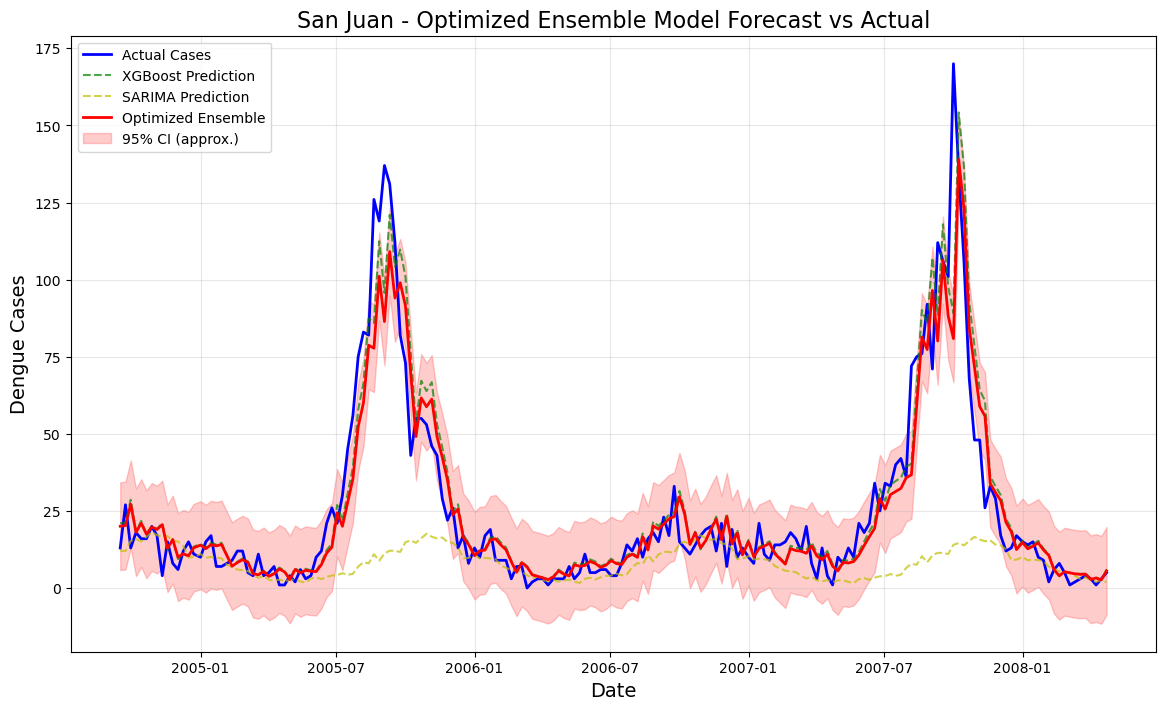

In [190]:
plt.figure(figsize=(14, 8))

sj_data = ensemble_df[ensemble_df['city'] == 'sj'].sort_values('week_start_date')

plt.plot(sj_data['week_start_date'], sj_data['total_cases'], 'b-', linewidth=2, label='Actual Cases')
plt.plot(sj_data['week_start_date'], sj_data['xgb_predicted'], 'g--', alpha=0.7, label='XGBoost Prediction')
plt.plot(sj_data['week_start_date'], sj_data['sarima_predicted'], 'y--', alpha=0.7, label='SARIMA Prediction')
plt.plot(sj_data['week_start_date'], sj_data['optimized_ensemble'], 'r-', linewidth=2, label='Optimized Ensemble')

residuals = abs(sj_data['optimized_ensemble'] - sj_data['total_cases'])
std = residuals.mean()
plt.fill_between(
    sj_data['week_start_date'],
    sj_data['optimized_ensemble'] - 1.96*std,
    sj_data['optimized_ensemble'] + 1.96*std,
    color='r', alpha=0.2, label='95% CI (approx.)'
)

plt.title('San Juan - Optimized Ensemble Model Forecast vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Dengue Cases', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.figtext(
    0.15, 0.02,
    f"San Juan MAE:\nXGBoost: 7.46\nSARIMA: 15.50\nOptimized Ensemble: {sj_best_mae:.2f}",
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('san_juan_optimized_ensemble_forecast.png', dpi=300)
plt.show()

NameError: name 'mdates' is not defined

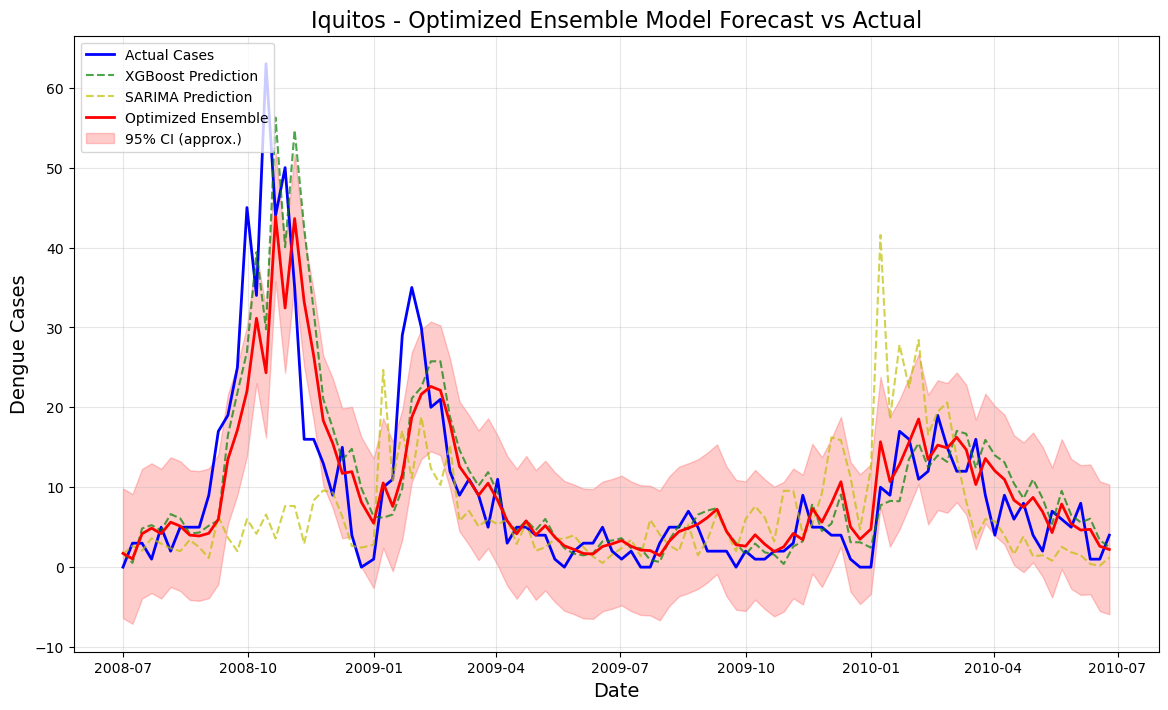

In [191]:
plt.figure(figsize=(14, 8))

iq_data = ensemble_df[ensemble_df['city'] == 'iq'].sort_values('week_start_date')

plt.plot(iq_data['week_start_date'], iq_data['total_cases'], 'b-', linewidth=2, label='Actual Cases')
plt.plot(iq_data['week_start_date'], iq_data['xgb_predicted'], 'g--', alpha=0.7, label='XGBoost Prediction')
plt.plot(iq_data['week_start_date'], iq_data['sarima_predicted'], 'y--', alpha=0.7, label='SARIMA Prediction')
plt.plot(iq_data['week_start_date'], iq_data['optimized_ensemble'], 'r-', linewidth=2, label='Optimized Ensemble')

residuals = abs(iq_data['optimized_ensemble'] - iq_data['total_cases'])
std = residuals.mean()
plt.fill_between(
    iq_data['week_start_date'],
    iq_data['optimized_ensemble'] - 1.96*std,
    iq_data['optimized_ensemble'] + 1.96*std,
    color='r', alpha=0.2, label='95% CI (approx.)'
)

plt.title('Iquitos - Optimized Ensemble Model Forecast vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Dengue Cases', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.figtext(
    0.15, 0.02,
    f"Iquitos MAE:\nXGBoost: 4.62\nSARIMA: 6.32\nOptimized Ensemble: {iq_best_mae:.2f}",
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig('iquitos_optimized_ensemble_forecast.png', dpi=300)
plt.show()

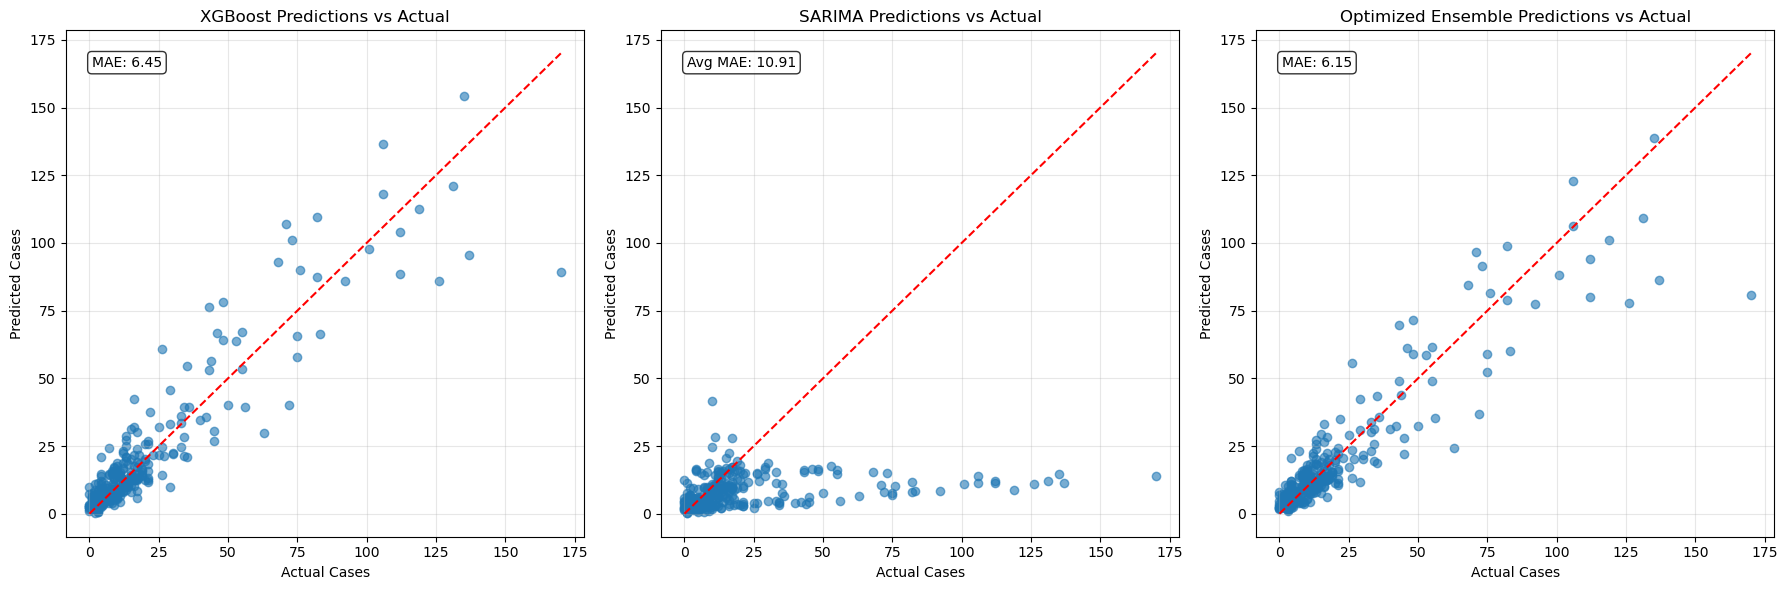

In [192]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(ensemble_df['total_cases'], ensemble_df['xgb_predicted'], alpha=0.6)
axes[0].plot([0, ensemble_df['total_cases'].max()], [0, ensemble_df['total_cases'].max()], 'r--')
axes[0].set_title('XGBoost Predictions vs Actual')
axes[0].set_xlabel('Actual Cases')
axes[0].set_ylabel('Predicted Cases')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'MAE: {6.45:.2f}', transform=axes[0].transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1].scatter(ensemble_df['total_cases'], ensemble_df['sarima_predicted'], alpha=0.6)
axes[1].plot([0, ensemble_df['total_cases'].max()], [0, ensemble_df['total_cases'].max()], 'r--')
axes[1].set_title('SARIMA Predictions vs Actual')
axes[1].set_xlabel('Actual Cases')
axes[1].set_ylabel('Predicted Cases')
axes[1].grid(True, alpha=0.3)
sarima_mae = (15.50 + 6.32) / 2
axes[1].text(0.05, 0.95, f'Avg MAE: {sarima_mae:.2f}', transform=axes[1].transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[2].scatter(ensemble_df['total_cases'], ensemble_df['optimized_ensemble'], alpha=0.6)
axes[2].plot([0, ensemble_df['total_cases'].max()], [0, ensemble_df['total_cases'].max()], 'r--')
axes[2].set_title('Optimized Ensemble Predictions vs Actual')
axes[2].set_xlabel('Actual Cases')
axes[2].set_ylabel('Predicted Cases')
axes[2].grid(True, alpha=0.3)
axes[2].text(0.05, 0.95, f'MAE: {6.15:.2f}', transform=axes[2].transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('prediction_accuracy_comparison_optimized.png', dpi=300)
plt.show()

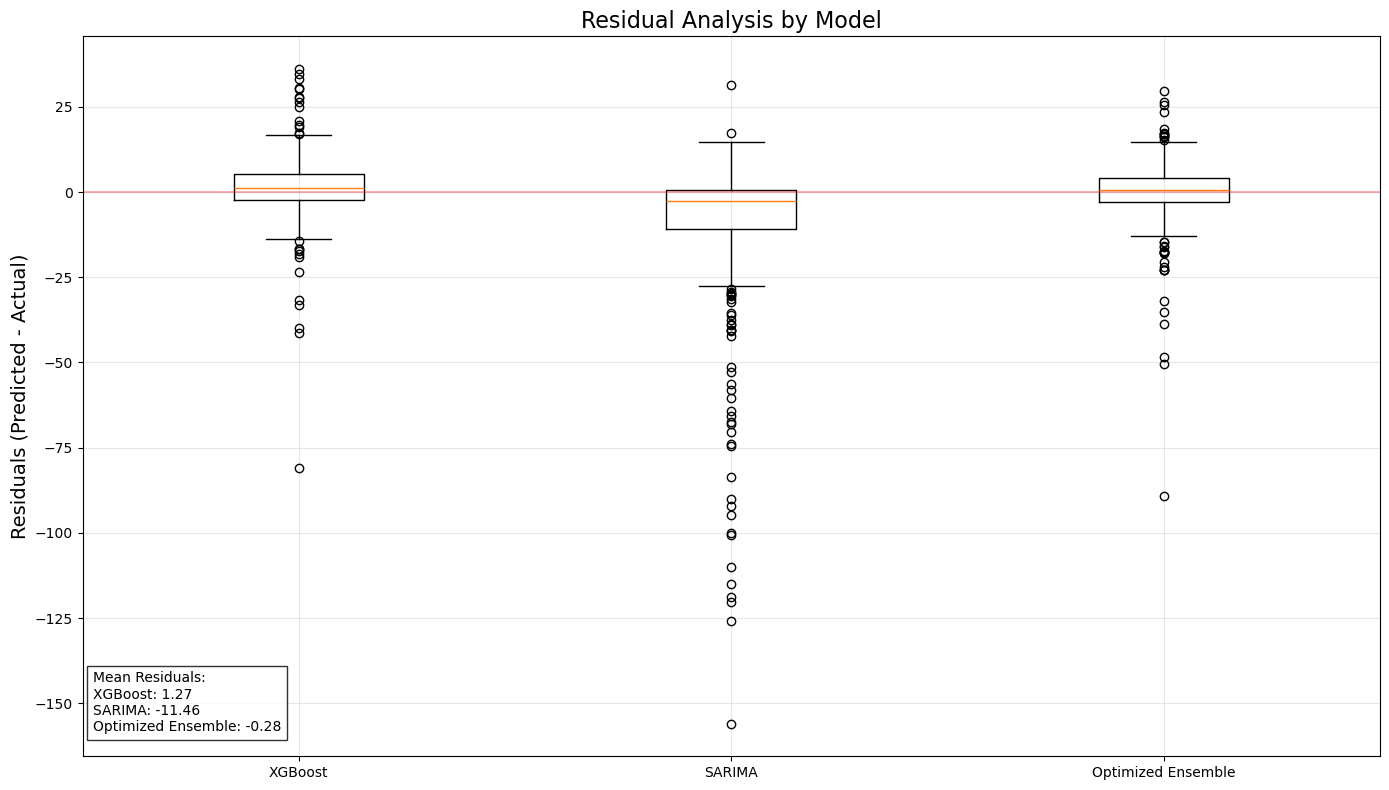

In [210]:
plt.figure(figsize=(14, 8))

ensemble_df['xgb_residuals'] = ensemble_df['xgb_predicted'] - ensemble_df['total_cases']
ensemble_df['sarima_residuals'] = ensemble_df['sarima_predicted'] - ensemble_df['total_cases']
ensemble_df['optimized_residuals'] = ensemble_df['optimized_ensemble'] - ensemble_df['total_cases']

boxplot_data = [
    ensemble_df['xgb_residuals'], 
    ensemble_df['sarima_residuals'], 
    ensemble_df['optimized_residuals']
]

plt.boxplot(boxplot_data, labels=['XGBoost', 'SARIMA', 'Optimized Ensemble'])
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Residual Analysis by Model', fontsize=16)
plt.ylabel('Residuals (Predicted - Actual)', fontsize=14)
plt.grid(True, alpha=0.3)

xgb_mean = ensemble_df['xgb_residuals'].mean()
sarima_mean = ensemble_df['sarima_residuals'].mean()
optimized_mean = ensemble_df['optimized_residuals'].mean()

plt.figtext(0.07, 0.08,
           f"Mean Residuals:\nXGBoost: {xgb_mean:.2f}\nSARIMA: {sarima_mean:.2f}\nOptimized Ensemble: {optimized_mean:.2f}",
           bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('residual_analysis_boxplot.png', dpi=300)
plt.show()

# Saving the ensemble model!

In [202]:
import pickle
import joblib

In [212]:
ensemble_config = {
    'sj_best_weights': sj_best_weights,  # Your optimized San Juan weights
    'iq_best_weights': iq_best_weights,  # Your optimized Iquitos weights
    'overall_mae': optimized_mae,
    'sj_mae': sj_best_mae,
    'iq_mae': iq_best_mae
}

# Save the configuration to a file
with open('dengue_ensemble_config.pkl', 'wb') as f:
    pickle.dump(ensemble_config, f)

# You may also want to save the ensemble DataFrame for reference
ensemble_df.to_csv('dengue_ensemble_predictions.csv', index=False)

print("Dengue ensemble model configuration saved!")

Dengue ensemble model configuration saved!


In [211]:
ensemble_config_df = pd.DataFrame([ensemble_config])

NameError: name 'ensemble_config' is not defined

In [203]:
ensemble_model = {
    'sj_weights': sj_best_weights,  # The optimized weights for San Juan
    'iq_weights': iq_best_weights,  # The optimized weights for Iquitos
    'overall_mae': optimized_mae,   # The overall MAE of the model
    'sj_mae': sj_best_mae,          # The MAE for San Juan
    'iq_mae': iq_best_mae           # The MAE for Iquitos
}

In [204]:
with open('dengue_ensemble_config.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

In [ ]:
# Save the optimized weights
ensemble_config = {
    'sj_best_weights': sj_best_weights,  # Your optimized San Juan weights
    'iq_best_weights': iq_best_weights,  # Your optimized Iquitos weights
    'overall_mae': optimized_mae,
    'sj_mae': sj_best_mae,
    'iq_mae': iq_best_mae
}

# Save the configuration to a file
with open('dengue_ensemble_config.pkl', 'wb') as f:
    pickle.dump(ensemble_config, f)

# You may also want to save the ensemble DataFrame for reference
ensemble_df.to_csv('dengue_ensemble_predictions.csv', index=False)

print("Dengue ensemble model configuration saved!")

In [205]:
def predict_ensemble(new_data, xgb_model, sj_sarima_model, iq_sarima_model, ensemble_config):
    """
    Make predictions using the optimized ensemble model.
    
    Parameters:
    -----------
    new_data : DataFrame
        New data for predictions with the same features as the training data
    xgb_model : XGBoost model object
        Trained XGBoost model
    sj_sarima_model, iq_sarima_model : SARIMAX results objects
        Trained SARIMA models for each city
    ensemble_config : dict
        Configuration with weights for each city
        
    Returns:
    --------
    DataFrame with predictions
    """
    # Make predictions with XGBoost
    xgb_preds = xgb_model.predict(new_data.drop(['city', 'week_start_date'], axis=1, errors='ignore'))
    
    # Prepare results DataFrame
    results = pd.DataFrame({
        'city': new_data['city'],
        'week_start_date': new_data['week_start_date'],
        'xgb_predicted': xgb_preds
    })
    
    # Get SARIMA predictions for each city
    # This would depend on how you structure your forecast periods
    # For simplicity, this is a placeholder
    # In practice, you'd need to set up the forecast periods correctly
    
    # Apply city-specific weights to get ensemble predictions
    results['ensemble_predicted'] = results.apply(
        lambda row: ensemble_config['sj_weights']['xgb'] * row['xgb_predicted'] + 
                   ensemble_config['sj_weights']['sarima'] * sarima_pred if row['city'] == 'sj' else
                   ensemble_config['iq_weights']['xgb'] * row['xgb_predicted'] + 
                   ensemble_config['iq_weights']['sarima'] * sarima_pred,
        axis=1
    )
    
    return results

In [207]:
import inspect

with open('dengue_ensemble_predict.py', 'w') as f:
    f.write(inspect.getsource(predict_ensemble))

print("Dengue ensemble model configuration saved!")

Dengue ensemble model configuration saved!


In [208]:
# Save the XGBoost model
joblib.dump(xgb_model, 'dengue_xgb_model.joblib')

# Save the SARIMA models
# Note: SARIMA models from statsmodels can be saved using their built-in save method
sj_sarima_log_results.save('sj_sarima_model.pkl')
iq_sarima_log_results.save('iq_sarima_model.pkl')

print("All model components saved successfully!")

NameError: name 'xgb_model' is not defined